# Imports

In [136]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import math
import random
import warnings
import stats
import calendar

from datetime                       import date, datetime, timedelta
from scipy.stats import norm


from reliability                    import Repairable_systems as rs
from reliability.Repairable_systems import MCF_nonparametric, MCF_parametric
from matplotlib                     import pyplot as plt
         
from scipy                          import stats as ss
         
from IPython.core.display           import HTML
from IPython.display                import Image

from pandas.tseries.offsets import DateOffset

warnings.filterwarnings('ignore')
#warnings.filterwarnings('default')

# Helper Functions

In [137]:
warnings.filterwarnings('ignore')

def jupyter_settings():
     %matplotlib inline
     %pylab inline
     plt.style.use( 'bmh' )
     plt.rcParams['figure.figsize'] = [25, 12]
     plt.rcParams['font.size'] = 24
     display( HTML( '<style>.container { width:100% !important; }</style>') )
     pd.options.display.max_columns = None
     pd.options.display.max_rows = None
     pd.set_option( 'display.expand_frame_repr', False )
     sns.set()
 
jupyter_settings()

def calculate_mtbf(hours, num_failures):
    # Calculate MTBF while handling 0 and NaN cases
    mtbf = np.where(num_failures == 0, np.nan, hours / num_failures)
    return mtbf

# Custom aggregation function
def custom_aggregation(df):
    return pd.Series({
        'n_falhas': df[df['tipo_falha'] == 'F']['n_serie'].count(),
    })

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Failure Details Tab

In [138]:
# Import Excel - each tab will be a different dataframe
df_fdata = pd.read_excel('Dados/Battery failure data for RAMS analysis - 20250202.xlsx',sheet_name ='Failure Details')

### Data Description

In [139]:
# checking data dimensions
df_fdata.shape

(334, 29)

In [140]:
# Remove unnecessary coluns in Failure Details

# columns to keep in dataset
keep_columns = ['Train No', 'Asset Configuration', 'Failure Mode', 'Battery Location',
       'Failure Category','Failed Battery Serial Number', 'Failure Reported Date',
       'FW Version','Installed serial number', 'Post Repair, Installed on',
       'Installed location', 'Installed Date Post repair']

# keep these columns and have the rest removed
df_fdata = df_fdata[keep_columns]

#rename columns
df_fdata.columns=['train', 'battery_config', 'failure_mode', 'battery_location',
       'failure_category','serial_number', 'failure_date',
       'fw_version','installed_sn', 'train_post_repair',
       'config_post_repair', 'install_date_postrepair']

# change the type
df_fdata['serial_number'] = df_fdata['serial_number'].astype(str)
df_fdata['failure_mode'] = df_fdata['failure_mode'].astype(str)

# remove undesired spaces from the strings
df_fdata['installed_sn'] = df_fdata['installed_sn'].astype(str).str.replace(r'\D+', '', regex=True)

# change from float to str and remove the decimal part, without removing the zeros at the end.
df_fdata['installed_sn'] = pd.to_numeric(df_fdata['installed_sn'],errors='raise',downcast='integer').astype(str).str.replace('.0', '')

# Replace string "nan" with actual NaN
df_fdata.replace('nan', np.nan, inplace=True)

### Data Cleaning

In [141]:
# Remove all the rows that contains only NaN values
df_fdata = df_fdata.dropna(how='all')

In [142]:
# Remove lines with this failure mode: Fault Clear Itself
df_fdata = df_fdata[~df_fdata['failure_mode'].str.contains('Fault Clear Itself')]

In [143]:
# check if there are any new values in 'battery_location'
df_fdata['battery_location'].unique()

array(['Repaired, reinstalled in train', 'ON TRAIN',
       'Battery Scrapped, batteries were heavily rigged by SERMA for test and for this reason they cannot be repaired',
       'Battery Scrapped due to irreparable (Battery went to Thermal Runaway in Riyadh site)',
       'Repaired, in Warehouse', 'With FZSoNick in Stabio for repair',
       'Battery Scrapped due to irreparable (Battery destroyed duirng K1S Experimental test. Part of reliability improvement & K1S root cause analysis investigation test)',
       'In SESTO Lab for Invest-Test',
       'With FZSoNick_PEDCO Riyadh for repair',
       'With FZSoNick in Stabio for Repair',
       'Battery Scrapped due to irreparable', 'Reinstalled in Train',
       'In Warehouse', 'Repaired, in warehouse', 'Faulty in Warehouse',
       'Still on train to be replaced'], dtype=object)

In [144]:
# Simplification of Battery Location classification
# not reinstalled: never reinstalled in any train (scrapped, sent to FZS or Paris and Warehouse)
# it was verified that these types of location doesn't have anything in post repair information (and doesn't have any other failure information after)
df_fdata['battery_location'] = df_fdata['battery_location'].replace(['Sent to Paris for SERMA (Inve_Support)',
                                                                     'Sent to Paris for SERMA (INve_Support)',
                                                                    'With FZS in Stabio for RCA',
                                                                    'With FZS in Stabio for repair',
                                                                    'With FZS_LSC Riyadh for repair',
                                                                    'With FZS in Stabio for Repair',
                                                                    'Faulty in Riyadh Warehouse',
                                                                    'Battery Scrapped due to irreparable (Battery went to Thermal Runaway in Riyadh site)',
                                                                    'Repaired, in Warehouse',
                                                                    'With FZSoNick_PEDCO Riyadh for repair',
                                                                    'Battery Scrapped due to irreparable',
                                                                    'Batteries were heavily rigged by SERMA for test and for this reason they cannot be repaired',
                                                                    'Battery Scrapped due to irreparable (Battery destroyed duirng K1S Experimental test. Part of reliability improvement & K1S root cause analysis investigation test)',
                                                                    'In transit to FZSoNick',
                                                                    'Faulty in Warehouse',
                                                                    'Faulty in warehouse',
                                                                    'False Detection, in Warehouse',
                                                                    'Battery Scrapped, batteries were heavily rigged by SERMA for test and for this reason they cannot be repaired'],
                                                                    'Not Reinstalled')

# repaired: repaired batteries that can be (or not) send to another position
df_fdata['battery_location'] = df_fdata['battery_location'].replace(['Repaired, reinstalled in train',
                                                                     'Alarm Cleared with V1B5A, reinstalled in train',
                                                                     'False Detection, reinstalled in train',
                                                                     'Reinstalled in Train'],
                                                                     'Repaired')
# still on train: repaired or not
df_fdata['battery_location'] = df_fdata['battery_location'].replace(['On train ( Fault has not repeated)',
                                                                     'STILL ON TRAIN',
                                                                     'Alarm Cleared with V1B5A',
                                                                     'Still on train to be replaced',
                                                                     'ON TRAIN'],
                                                                     'Still on Train')

# transform 'nan' values into real NaN values
df_fdata.replace('nan', np.nan, inplace=True)

In [145]:
# For 'still on train' cases (which I have no post repair information): copy failure information for date, train and position
mask = df_fdata['battery_location'] == 'Still on Train'
df_fdata.loc[mask, 'config_post_repair'] = df_fdata.loc[mask, 'battery_config'].fillna('')
df_fdata.loc[mask, 'train_post_repair'] = df_fdata.loc[mask, 'train'].fillna('')
df_fdata.loc[mask, 'install_date_postrepair'] = df_fdata.loc[mask, 'failure_date'].fillna('')

In [146]:
# dataframe in chronological order by the failure date
df_fdata = df_fdata.sort_values(by='failure_date').reset_index(drop=True)

In [147]:
# New column ('no_failures') - support column: counts how many failures this battery has had in total
df_fdata['no_failures'] = df_fdata['serial_number'].map(df_fdata['serial_number'].value_counts())
# New column ('counter') - support column: counts how many faliures this battery has had until that line
counter = {}
df_fdata['counter'] = 0
for i, row in df_fdata.iterrows():
    s_number = row['serial_number']
    if s_number not in counter:
        counter[s_number] = 0
    counter[s_number] += 1
    df_fdata.loc[i, 'counter'] = counter[s_number]

In [148]:
# copy and paste the 'serial_number' value to the 'installed_sn' column where the conditions are met
df_fdata['installed_sn'] = np.where((df_fdata['battery_location']=='Still on Train') &
                                    (df_fdata['installed_sn'].isnull()), 
                                    df_fdata['serial_number'], 
                                    df_fdata['installed_sn'])

In [149]:
# check on which lines there are missing trains
df_fdata[~df_fdata['train'].str.startswith('TS')]

,train,battery_config,failure_mode,battery_location,failure_category,serial_number,failure_date,fw_version,installed_sn,train_post_repair,config_post_repair,install_date_postrepair,no_failures,counter
4,-,BA11,Temperature Probe Mismatch,Repaired,Need Same Day Action,1207867.0,2019-04-19,1054,NaN,TS15,BA23,2020-09-08,1,1
93,-,-,Communication Error,Repaired,Need Same Day Action,1229704.0,2021-10-14,1056,NaN,TS11,BA21,2023-08-15,1,1
98,-,-,Low Battery Voltage,Repaired,Need Same Day Action,1229702.0,2021-10-25,1056,NaN,TS12,BA21,2023-01-17,1,1


In [150]:
# There are missing informations about train failures (the next lines are to allocate manually)

# 1st: Index = 04 ; Battery = 1207867
df_fdata.loc[4, 'train'] = 'TS10'
df_fdata.loc[4, 'serial_number'] = '120823'

# 2nd: Index = 84 ; Battery = 1229704
df_fdata.loc[93, 'train'] = 'TS12'
df_fdata.loc[93, 'battery_config'] = 'BA21'
df_fdata.loc[93, 'serial_number'] = '1220750'

# 3rd: Index = 88 ; Battery = 1229702
df_fdata.loc[98, 'train'] = 'TS11'
df_fdata.loc[98, 'battery_config'] = 'BA21'
df_fdata.loc[98, 'serial_number'] = '1216376'

# END: df_fdata (Failure Details tab)  ==================================================
# =======================================================================================

## Production Year Tab

In [151]:
# import data from Production Year tab
df_pyear = pd.read_excel('Dados/Battery failure data for RAMS analysis - 20250202.xlsx',sheet_name ='Production Year')

In [152]:
df_pyear.shape

(344, 3)

In [153]:
# columns to keep in df_pyear
keep_columns = ['Production month','Serial Number']

# keep these columns and have the rest removed in df_pyear
df_pyear = df_pyear[keep_columns]

In [154]:
#rename columns
df_pyear.columns=['production_month','serial_number']

In [155]:
# For batteries with more than one production date: consider only the first one
df_pyear = df_pyear.groupby('serial_number', as_index=False)['production_month'].min()
df_pyear.drop_duplicates(subset='serial_number', inplace=True)
df_pyear['serial_number'] = df_pyear['serial_number'].astype(str)

In [156]:
# Create column: 'first event' - checks whether failure or replacement occurred first (service start date support)

In [157]:
# Create a first failure dataframe (all registered first failures of batteries)
fi_fail=df_fdata.copy()
fi_fail=fi_fail[fi_fail['counter']==1]
fi_fail = fi_fail.filter(['serial_number','train','battery_config','failure_date'])

In [158]:
# Create a first replaced dataframe (all registered first replacements of batteries)
fi_repla=df_fdata.copy()
fi_repla.drop_duplicates(subset='installed_sn', keep='first', inplace=True)
fi_repla = fi_repla.filter(['installed_sn','train','battery_config','failure_date'])
fi_repla.rename(columns={'failure_date': 'replacement_date'}, inplace=True)

Preciso checar o código abaixo, baseado na preocupação da Beatriz
- VERIFICAR COM O CAIO: Acho que fiz algum comando errado, queria pegar TODOS do dataframe
- firepla e fifail, pra pegar todos os valores de failure e replacement de ambos os casos
- mas achei estranho que o fr (resultante) tem a mesma quantidade de linhas que o fifail

In [159]:
# Merge first failure and first replacement
df_fr=pd.merge(fi_fail,fi_repla, left_on=['serial_number'],right_on=['installed_sn'], how='outer')
df_fr.dropna(subset=['serial_number'], inplace=True) # Delete NaN results from merge

In [160]:
# Create and classify the start info
df_fr['start_info'] = np.where(df_fr['failure_date'].isnull(), 'replacement',
                            np.where(df_fr['replacement_date'].isnull(), 'failure',np.where(df_fr['failure_date'] < df_fr['replacement_date'], 'failure', 'replacement')))

In [161]:
# Create and classify start_train and start_position
df_fr.loc[df_fr['start_info'] == 'replacement', 'start_train'] = df_fr['train_y']
df_fr.loc[df_fr['start_info'] == 'replacement', 'start_position'] = df_fr['battery_config_y']
df_fr.loc[df_fr['start_info'] != 'replacement', 'start_train'] = df_fr['train_x']
df_fr.loc[df_fr['start_info'] != 'replacement', 'start_position'] = df_fr['battery_config_x']

In [162]:
# Drop unecessary columns
df_fr = df_fr.drop(df_fr.loc[:, 'train_x':'start_info'].columns, axis=1)
# Output: list of all batteries that we know the start condition (train and position)

# END: pyear (Production Year tab)  =====================================================
# =======================================================================================

## Train 1st Power On Tab

In [163]:
# import data from Train 1st Power ON Date tab
df_tpower = pd.read_excel('Dados/Battery failure data for RAMS analysis - 20250202.xlsx',sheet_name ='Train 1st Power ON Date')

In [164]:
# rename columns
df_tpower.columns = ['train','power_on_date']

In [165]:
# Organize df_tpower dataframe: remove not ready trains and create a line for every single position
df_tpower = df_tpower.loc[df_tpower.index.repeat(6)].reset_index(drop=True)
df_tpower['position'] = ['BA11', 'BA12', 'BA13', 'BA21', 'BA22', 'BA23'] * int(df_tpower.shape[0]/6)
df_tpower['power_on_date'] = df_tpower.groupby(level=0)['power_on_date'].transform(lambda x: x.iloc[0])
df_tpower = df_tpower[df_tpower['power_on_date'] != 'Not Ready']
df_tpower['train'] = df_tpower['train'].apply(lambda x: 'TS' + (str(x).zfill(2) if x < 10 else str(x)))
df_tpower = df_tpower[['train', 'position', 'power_on_date']]

In [166]:
# Return the first failure of the train
merged = df_tpower.merge(df_fdata, left_on='train', right_on='train', how='inner')
first_failure = merged.groupby('train')['failure_date'].first()
df_tpower['1st_failure'] = df_tpower['train'].map(first_failure)

In [167]:
# use only the date
df_tpower['power_on_date'] = pd.to_datetime(df_tpower['power_on_date'])

In [168]:
#create a full_config, which concatenates 'train' and 'position'
df_tpower.insert(2,'full_config',df_tpower['train']+df_tpower['position'])

In [169]:
# Check if '1st_failure' is BEFORE the 'power_on_date'. If yes, modify the 'power_on_date' to '1st_failure' - 6 months. If no, keep the original value for 'power_on_date'
df_tpower['power_on_date'] = np.where(df_tpower['1st_failure'] < df_tpower['power_on_date'], df_tpower['1st_failure'] - DateOffset(months=6), df_tpower['power_on_date'])


In [170]:
# CHECAR DEPOIS O fdata COM REPLACED E SEM REPLACED SERIAL NUMBER
  
    # 2.6 Verifica a data da 1a falha dessa bateria na fdata (se tiver) e verifica a data em que essa bateria substituiu outra (se tiver)
    # 2.7 Cria +2 colunas (Start train e postion) retornando o trem e o carro da 1a falha ou reposição (o que ocorreu primeiro)
    # 2.8 Cria +1 coluna (Considered Start Date): se a primeira falha foi primeiro retorna a data (que está na tpower) desse trem, caso contrário é a data da reposição
    # 2.9 Saída: pyear com todas as baterias com data de fabricação, trem, posição e data de inicio
    # 2.10 Depois teremos que voltar aqui    
    
# 3.0 A partir de train power (obs: precisamos pensar na alternativa para os casos das datas que a falha vem antes do power on)
        # Para a data de inicio, vamos colocar a data da falha - 3 meses SÓ QUANDO TEMOS DATA DA FALHA ANTES
    # 3.1 Criar uma array com TODAS as posições: 3 colunas = trem, posição, power on date (deve ter 282 linhas)
    # 3.2 Remover as posições not ready
    # 3.3 Remover as posições mencionadas em 2.7 - o que sobrar nessa lista são as posições de trens que entraram em serviço, mas não têm nenhuma bateria atribuída
    # 3.4 Atribuir para as 3 colunas mencionadas em 2.7 e 2.8: atribuir aleatoriamente as posições dessa lista para as baterias (colocar uma condicional para verificar se sobraram espaços ou baterias)
    # 3.5 Se sobrar bateria: deletar as baterias sem posição (elas serão consideradas spare parts)
    # 3.6 Se sobrar espaço: Não vai acontecer inicialmente, imagino que seria um problema possível apenas com a implementação da 2.3

# 4.0 Dados finais:

## Assets tab

Summary of each column for Assets' tab  

Asset - Unknown  
BDI Status - Unknown  
Description - Irrelevant  
Rotating Item - Irrelevant  
External Asset - Empty Column  
Serial - Battery Serial Number  
Type - Empty Column  
Status - Current status  
External Reference - Empty Column  
TLA - Unknown  
Location - Unknown  
Location Description - Unknown  
Derived Position - Battery position in the train (See Arman's email with the necessary information)  
Service Address - Empty Column  
Parent - Unknown  
Model - Empty Column  
CM Item - Irrelevant  
Registration - Empty Column  
Project - Empty Column  
Site - Irrelevant  

In [171]:
# import data from Assets tab
df_assets = pd.read_excel('Dados/Battery.xlsx',sheet_name='Assets')

In [172]:
#list of columns containing following types of columns: irrelevant, empty columns and some unknown columns
drop_columns = ['Description','Rotating Item','CM Item','Site','External Asset','Type','External Reference ID',
'Service Address','Model','Registration','Project','BDI status','Asset']

# drop unnecessary columns
df_assets.drop(drop_columns,axis=1,inplace=True)

In [173]:
# rename columns
df_assets.columns=['serial_number','status','tla','location','location_description','battery_position','parent']

In [174]:
# change from float to str and remove the decimal part, without removing the zeros at the end.
df_assets['serial_number'] = pd.to_numeric(df_assets['serial_number'],errors='coerce',downcast='integer').astype(str).str.replace('.0', '')

In [175]:
# replace values according to Arman's email
df_assets['battery_position'].replace({'A/UC/BATLS1':'BA11',
                                       'A/UC/BATLS2':'BA12',
                                      'A/UC/BATRS':'BA13',
                                      'B/UC/BATLS1':'BA21',
                                      'B/UC/BATLS2':'BA22',
                                      'B/UC/BATRS':'BA23'},inplace=True)

In [176]:
# replace part of the wording in 'tla' column. Replace 'TRAIN30' by 'TS'.
df_assets['tla'] = df_assets['tla'].str.replace('TRAIN30','TS')

In [177]:
##create a full_config, which concatenates 'train' and 'battery_config'
df_assets.insert(6,'full_config',df_assets['tla']+df_assets['battery_position'])

# Data Processing

In [178]:
# create the final dataframe, that will be used to perform the analysis
df_final = df_fdata.copy()

In [179]:
# there are some values in 'train_post_repair' that should begin with 'TS' instead of 'T'. I need to change that. That means, if the first 2 letters are 'T' + a number, like '2', or '0', I should replace 'T' by 'TS'. Otherwise, I should keep the same value.
df_final['train_post_repair'] = np.where(df_final['train_post_repair'].str.contains('^T[0-9]'), df_final['train_post_repair'].str.replace('T', 'TS'), df_final['train_post_repair'])
df_final['train_post_repair'] = df_final['train_post_repair'].str.replace(' ','')
df_final['train'] = df_final['train'].str.replace(' ','')

In [180]:
# create the column 'type of failure', with 'F', which means 'failure' for every row
df_final.insert(6, 'type_failure', 'F')

# create the column 'start_date', which will be empty at first
df_final.insert(5, 'start_date',np.nan)

In [181]:
#create a full_config, which concatenates 'train' and 'battery_config'
df_final.insert(2,'full_config',df_final['train'] +df_final['battery_config'])


In [182]:
#create a full_config_postrepair, which concatenates 'train' and 'battery_config'
df_final.insert(12,'full_config_postrepair',df_final['train_post_repair'].astype(str)+df_final['config_post_repair'].astype(str))

In [183]:
# New column ('no_failures_fullconfig') - support column: counts how many failures this specific position has had in total
df_final['no_failures_fullconfig'] = df_final['full_config'].map(df_final['full_config'].value_counts())
# New column ('counter_fullconfig') - support column: counts how many faliures this specific position has had until that line
counter_fullconfig = {}
df_final['counter_fullconfig'] = 0
for i, row in df_final.iterrows():
    f_config = row['full_config']
    if f_config not in counter_fullconfig:
        counter_fullconfig[f_config] = 0
    counter_fullconfig[f_config] += 1
    df_final.loc[i, 'counter_fullconfig'] = counter_fullconfig[f_config]

## Missing Values

In [184]:
# identify which rows contains missing value for 'installed_sn', which shouldn't be empty at this point
df_final[df_final['installed_sn'].isnull()]

,train,battery_config,full_config,failure_mode,battery_location,failure_category,start_date,serial_number,type_failure,failure_date,fw_version,installed_sn,full_config_postrepair,train_post_repair,config_post_repair,install_date_postrepair,no_failures,counter,no_failures_fullconfig,counter_fullconfig
1,TS08,BA21,TS08BA21,String Voltage Unbalance Alarm,Repaired,Need Same Day Action,NaN,1208208.0,F,2019-01-14,1054,NaN,TS30BA21,TS30,BA21,2020-09-16,2,1,4,2
4,TS10,BA11,TS10BA11,Temperature Probe Mismatch,Repaired,Need Same Day Action,NaN,120823,F,2019-04-19,1054,NaN,TS15BA23,TS15,BA23,2020-09-08,1,1,4,1
5,TS16,BA11,TS16BA11,String Voltage Unbalance Alarm,Repaired,Need Same Day Action,NaN,1216633.0,F,2019-06-23,1054,NaN,TS33BA23,TS33,BA23,2021-03-08,1,1,1,1
93,TS12,BA21,TS12BA21,Communication Error,Repaired,Need Same Day Action,NaN,1220750,F,2021-10-14,1056,NaN,TS11BA21,TS11,BA21,2023-08-15,1,1,4,2
98,TS11,BA21,TS11BA21,Low Battery Voltage,Repaired,Need Same Day Action,NaN,1216376,F,2021-10-25,1056,NaN,TS12BA21,TS12,BA21,2023-01-17,1,1,2,1


In [185]:
# manullay fill the missing values in 'installed_sn' column, based on the history of each 'full_config' and 'failure_date'

df_final.loc[(df_final['full_config']=='TS08BA21') & (df_final['failure_date']=='2019-01-14'), 'installed_sn'] = '1208044'
df_final.loc[(df_final['full_config']=='TS10BA11') & (df_final['failure_date']=='2019-04-19'), 'installed_sn'] = '1208203'
df_final.loc[(df_final['full_config']=='TS11BA21') & (df_final['failure_date']=='2021-10-25'), 'installed_sn'] = '1216376'
df_final.loc[(df_final['full_config']=='TS12BA21') & (df_final['failure_date']=='2021-10-14'), 'installed_sn'] = '1220750'
# this one was particularly difficult to understand. I had to check df_assets to understand the whole situation, but there was some conflict information. I went with what made most sense
df_final.loc[(df_final['full_config']=='TS16BA11') & (df_final['failure_date']=='2019-06-23'), 'installed_sn'] = '1207869'

## First Failures

In [186]:
# obtain the first failure for every train and position
df_final_mindate = df_final.groupby('full_config')[['serial_number','failure_date']].first().reset_index()

In [187]:
# merged both datasets to obtain the 'power_on_date' for each 'full_config', that will be used as 'start_date'
df_merged_mindate_tpower = pd.merge(df_final_mindate,df_tpower,on='full_config',how='left').reset_index(drop=True)

In [188]:
# convert to datetime
df_merged_mindate_tpower['failure_date'] = pd.to_datetime(df_merged_mindate_tpower['failure_date'],format='%Y-%m-%d')
df_merged_mindate_tpower['power_on_date'] = pd.to_datetime(df_merged_mindate_tpower['power_on_date'],format='%Y-%m-%d')
df_final['failure_date'] = pd.to_datetime(df_final['failure_date'],format='%Y-%m-%d')
df_final['start_date'] = pd.to_datetime(df_final['start_date'],format='%Y-%m-%d')

In [189]:
# fill 'start_date' column with 'power_on_date' values where 'full_config','serial_number' and 'failure_date' are equal in both dataframes (df_final and df_merged_mindate_tpower)

df_final['start_date'] = df_final.apply(lambda row:
    df_merged_mindate_tpower.loc[
        (df_merged_mindate_tpower['full_config'] == row['full_config']) &
        (df_merged_mindate_tpower['failure_date'] == row['failure_date'])
    ]['power_on_date'].iloc[0] \
    if not df_merged_mindate_tpower.loc[
        (df_merged_mindate_tpower['full_config'] == row['full_config']) &
        (df_merged_mindate_tpower['failure_date'] == row['failure_date'])
    ].empty else row['start_date'],
    axis=1
)

## Other failures

The logic here is to define the start date for all the existant missing values, using the last failure_date for each full_config.

In [190]:
# Sort the dataframe by 'full_config' and 'failure_date'
df_final.sort_values(['full_config', 'failure_date'], inplace=True)

# Group the dataframe by 'full_config'
grouped = df_final.groupby('full_config')

# Iterate over each group
for _, group in grouped:
    # Get the index of the last row in the group
    last_index = group.index[-1]
    
    # Iterate over each row in the group
    for index, row in group.iterrows():
        # Check if the current row is not the last row in the group
        if index != last_index:
            # Get the next row in the group
            next_row = group.loc[group.index > index].iloc[0]
            
            # Update the 'start_date' of the next row with the 'failure_date' of the current row
            df_final.at[next_row.name, 'start_date'] = row['failure_date']

## Censored Data

### Existing Install Date Post Repair

To get the censored data for the last failure date for each serial number. The missing values on 'install_date_postrepair' will be handled later.

In [191]:
# create an empty dataframe, based on df_final columns
df_censored = pd.DataFrame(columns=df_final.columns)

In [192]:
# the comment/code below was used when I tried to get the censored data by serial_number instead of full_config. I changed because I wasn't able to fully track each serial_number
# # remove the missing values in 'install_date_postrepair' column
# aux = df_final.dropna(subset=['install_date_postrepair'])
# # get the maximum value of 'counter' for each 'serial_number'
# df_max_counter = aux.groupby('serial_number')['counter'].max().reset_index()

# # for every 'serial_number', get the highest value in 'counter' column, check if there's a value in 'install_date_postrepair'. If yes,
# # create and copy/paste the following values in the new row:
# # 'train_post_repair' -> 'train'
# # 'config_post_repair' -> 'battery_config'
# # full_config_postrepair -> full_config
# # 'install_date_postrepair' -> 'start_date'
# # 'failure_date' -> '2023-10-23'
# # 'type_failure' -> 'S'

# # Iterate through each row in df_max_counter
# for index, row in df_max_counter.iterrows():
#     # Get the 'counter' and 'serial_number' values
#     counter = row['counter']
#     serial_number = row['serial_number']
    
#     # Find the matching row in df_final
#     match_row = df_final[(df_final['counter'] == counter) & (df_final['serial_number'] == serial_number)]
    
#     # Copy the values from df_final to df_censored
#     df_censored.loc[index, 'train'] = match_row['train_post_repair'].values[0]
#     df_censored.loc[index, 'battery_config'] = match_row['config_post_repair'].values[0]
#     df_censored.loc[index, 'full_config'] = match_row['full_config_postrepair'].values[0]
#     df_censored.loc[index, 'serial_number'] = match_row['installed_sn'].values[0]
#     df_censored.loc[index, 'start_date'] = match_row['install_date_postrepair'].values[0]
#     df_censored.loc[index, 'type_failure'] = 'S'
#     df_censored.loc[index, 'failure_date'] = '2023-10-23'
#     df_censored.loc[index, 'battery_location'] = 'Operating'

# df_censored['start_date'] = pd.to_datetime(df_censored['start_date'],format='%Y-%m-%d')
# df_censored['failure_date'] = pd.to_datetime(df_censored['failure_date'],format='%Y-%m-%d')

# # Concatenate df_final and df_censored
# df_final = pd.concat([df_final, df_censored])

In [193]:
df_max_counter = df_final.groupby('full_config')['counter_fullconfig'].max().reset_index()

In [194]:
# Iterate through each row in df_max_counter
for index, row in df_max_counter.iterrows():
    # Get the 'counter' and 'full_config' values
    counter_fullconfig = row['counter_fullconfig']
    f_config = row['full_config']
    
    # Find the matching row in df_final
    match_row = df_final[(df_final['counter_fullconfig'] == counter_fullconfig) & (df_final['full_config'] == f_config)]
    
    # Copy the values from df_final to df_censored
    df_censored.loc[index, 'train'] = match_row['train'].values[0]
    df_censored.loc[index, 'battery_config'] = match_row['battery_config'].values[0]
    df_censored.loc[index, 'full_config'] = match_row['full_config'].values[0]
    df_censored.loc[index, 'serial_number'] = match_row['installed_sn'].values[0]
    df_censored.loc[index, 'start_date'] = match_row['failure_date'].values[0]
    df_censored.loc[index, 'type_failure'] = 'S'
    df_censored.loc[index, 'failure_date'] = '2025-02-02' # date of the last file
    df_censored.loc[index, 'battery_location'] = 'Operating'

df_censored['start_date'] = pd.to_datetime(df_censored['start_date'],format='%Y-%m-%d')
df_censored['failure_date'] = pd.to_datetime(df_censored['failure_date'],format='%Y-%m-%d')

# Concatenate df_final and df_censored
df_final = pd.concat([df_final, df_censored])

In [195]:
print(str(len(df_censored)) + ' rows were added to df_final dataframe, and the dataframe contains ' + str(len(df_final)) + ' rows in total.')

159 rows were added to df_final dataframe, and the dataframe contains 429 rows in total.


### Missing Values - Installed Date Post Repair

This section is only necessary if we're analyzing the performance by a battery perspective. As I changed to a full_config perspective, this step is no longer necessary.

-----

As all the 39 serial numbers that doesn't contain a date in 'installed_date_postrepair', also contains the information of 'Not Reinstalled' in 'battery_location' column, I checked every serial number in df_assets, and it matched perfectly the information that all of these batteries are not operating since the last failuure. So, for those batteries, I'll not consider a censored data.

In [196]:
# create a list of serial numbers that are theorically not running anymore. These batteries were not reinstalled in any train
aux = df_final[df_final['battery_location']=='Not Reinstalled'].serial_number.tolist()

# check if any of these batteries are still running in any train
df_assets.loc[df_assets['serial_number'].isin(aux)].head()

,serial_number,status,tla,location,location_description,battery_position,full_config,parent


### Batteries that weren't mentioned

The idea here is to compare the serial numbers between the failure's dataframe and assets' dataframe. The ones in assets' dataframe that were not mentioned and are running, will be considered as censored data.

In [197]:
# in df_assets, there are all the possible combinations of 'full_config'. In df_final, there are only a few of combinations of 'full_config'. I want to check which combinations were not mentioned in df_final
# create a list of unique 'full_config' in df_final
aux = df_final.full_config.unique().tolist()

# create a list of unique 'full_config' in df_assets, removing the ones that doens't have 'TS' in 'tla' column
aux2 = df_assets[df_assets['tla'].fillna('').str.contains('TS')].full_config.unique().tolist()

# compare which 'full_config' are not in df_final
full_config_cens = set(aux2) - set(aux)

print('There are ' + str(len(full_config_cens)) + ' full_config that are not in df_final.')

There are 120 full_config that are not in df_final.


The serial numbers that never had a failure will not be checked this time. Probably there are some batteries that could have failed before, but to make this evaluation will take some extra time, and probably wouldn't add much value to the analysis. So, the full_config's that never had a failure will be added into the final datarame, as a censored data, and the corresponding serial_number on df_assets will be added.

In [198]:
# For each full_config in full_config_cens, I need to get the 'power_on_date' in df_tpower
df_aux = pd.DataFrame(columns=df_final.columns)
for full_config in full_config_cens:
    # Check if there is at least one row in df_tpower that matches the condition
    if len(df_tpower[df_tpower['full_config'] == full_config]) > 0:
        # Get the 'power_on_date' from df_tpower
        power_on_date = df_tpower[df_tpower['full_config'] == full_config]['power_on_date'].values[0]

        # Get the 'train' and 'battery_config' from df_assets
        train = df_assets[df_assets['full_config'] == full_config]['tla'].values[0]
        battery_config = df_assets[df_assets['full_config'] == full_config]['battery_position'].values[0]

        # Get the 'serial_number' from df_assets
        serial_number = df_assets[df_assets['full_config'] == full_config]['serial_number'].values[0]

        # Create a new row for df_aux
        df_aux = pd.concat([df_aux, pd.DataFrame({
            'train': [train],
            'battery_config': [battery_config],
            'full_config': [full_config],
            'serial_number': [serial_number],
            'start_date': [power_on_date],
            'type_failure': ['S'],
            'failure_date': ['2025-02-02'], # last day of the file
            'battery_location': ['Operating']
        })], ignore_index=True)

In [199]:
# # Concatenate df_aux and df_censored
# df_censored = pd.concat([df_aux, df_censored])

# concatenate df_aux and df_final
df_final = pd.concat([df_aux, df_final])

df_final['start_date'] = pd.to_datetime(df_final['start_date'],format='%Y-%m-%d')
df_final['failure_date'] = pd.to_datetime(df_final['failure_date'],format='%Y-%m-%d')

In [200]:
print(str(len(df_aux)) + ' rows were added to df_final dataframe, and the dataframe contains ' + str(len(df_final)) + ' rows in total.')

114 rows were added to df_final dataframe, and the dataframe contains 543 rows in total.


It was expected to have 158 rows added to df_final dataframe, but only 152 were added, because the train 36 is missing from df_assets dataframe, and this car is operating normally, so these positions won't be considered in the analysis.

# Finishing Dataframe to Analyse

In [201]:
# create a new dataframe, which contains only the values that will be used in the analysis
df_analysis = df_final[['train','battery_config','full_config','failure_mode','serial_number','start_date','failure_date','type_failure','failure_category','counter_fullconfig']]

In [202]:
# create a new column, 'ttf', which is the difference between 'failure_date' and 'start_date'
df_analysis['ttf'] = df_analysis['failure_date'] - df_analysis['start_date']
# transform the value into days
df_analysis['ttf'] = df_analysis['ttf'].dt.days

# create a column that will contain the 'ttf' in hours
df_analysis['hourstf'] = df_analysis['ttf'] * 24

# create 'arrival_day' column, which will contain the cumulative time of operation for each 'full_config'
df_analysis['arrival_days'] = df_analysis.groupby('full_config')['ttf'].cumsum()

# create 'arrival_hours' column, which will be the 'arrival_day' column, multiplied by 24
df_analysis['arrival_hours'] = df_analysis['arrival_days'] * 24

In [203]:
# correct some mistakes in 'failure_mode' column, by replacing some values
df_analysis['failure_mode'] = df_analysis['failure_mode'].replace({'String Voltage Unbalance Alarm' : 'String Voltage Unbalance',
                                                                   'String Voltage Unbalance Warning' : 'String Voltage Unbalance',
                                                                       'Temperature Probe Mismatch':'Temperature Probe Error',
                                                                       'Battery Controller failure':'Battery Controller Failure',
                                                                       'Communication Error ':'Communication Error',
                                                                       'Heating System Fault with Battery controller failure':'Heating System Fault',
                                                                       'Heating system':'Heating System Fault',
                                                                       'False detection (Battery had not sent to repir. Alarm clear with reset command)':'False Detection'})

In [204]:
# sort values by 'full_config' and 'failure_date'
df_analysis.sort_values(['full_config', 'failure_date'], inplace=True)

## Reliability Growth Analysis

In [205]:
# create a copy of df_analysis dataframe
df_rga = df_analysis[['train','battery_config','full_config','failure_mode','hourstf','arrival_hours','arrival_days','type_failure','failure_category']].copy()

In [206]:
# create 'classification' column, which will contain the information about how we'll handle each failure mode. It'll receive NaN values at first
df_rga['classification'] = np.nan

# create a new column, 'rga_type', which is the type of failure for reliability growth analysis. The values can be 'S' (start),'E' (event) or 'F' (final)
df_rga['rga_type']= np.nan

In [207]:
# for rga_type column:
# if there's a failure - rga_type = 'E'
# if there's a censored data - rga_type = 'F'
# at arrival_day = 0, rga_type = 'S'

# every failure will receive 'E' in 'rga_type' column, and every censored data will receive 'S'
df_rga['rga_type'] = np.where(df_rga['type_failure']=='F','F',df_rga['rga_type'])
df_rga['rga_type'] = np.where(df_rga['type_failure']=='S','E',df_rga['rga_type'])


In [208]:
# for every 'full_config' in df_final, create a row that will contain the start. To do this, create a row with the following values
# 'train' -> 'train'
# 'battery_config' -> 'battery_config'
# 'full_config' -> 'full_config'
# 'rga_type' -> 'S'
# 'arrival_day' -> 0

aux = df_rga.full_config.unique().tolist()

df_rga_start = pd.DataFrame(columns=df_rga.columns)
for full_config in aux:
    # Check if there is at least one row in df_tpower that matches the condition
    if len(df_rga[df_rga['full_config'] == full_config]) > 0:

        # Get the 'train' and 'battery_config' from df_assets
        train = df_rga[df_rga['full_config'] == full_config]['train'].values[0]
        battery_config = df_rga[df_rga['full_config'] == full_config]['battery_config'].values[0]

        # Create a new row for df_aux
        
        df_rga_start = pd.concat([df_rga_start, pd.DataFrame({
            'train': [train],
            'battery_config': [battery_config],
            'full_config': [full_config],
            'rga_type': ['S'],
            'arrival_days': [0],
            'arrival_hours': [0]
        })], ignore_index=True)

In [209]:
# Concatenate df_final and df_censored
df_rga = pd.concat([df_rga, df_rga_start])

print(str(len(df_rga_start)) + ' rows were added to df_final dataframe, and the dataframe contains ' + str(len(df_rga)) + ' rows in total.')

273 rows were added to df_final dataframe, and the dataframe contains 816 rows in total.


In [210]:
# sort by 'full_config' and 'arrival_day'
df_rga.sort_values(['full_config', 'arrival_days'], inplace=True)

# modify the order of the columns to prepare for reliasoft import
df_rga = df_rga[['train','battery_config','full_config','rga_type','arrival_hours','classification','failure_mode','arrival_days','hourstf','type_failure','failure_category']]


In [211]:
# check if there's one 'S' for each 'full_config' in 'rga_type' column. We can do this by checking the amount of 'S' we have, and then compare with the amount of unique 'full_config'
if len(df_rga[df_rga['rga_type']=='F']) == len(df_rga.full_config.unique()):
    print("There's one 'E' for each full_config in rga_type column.")
else:
    print('There are ' + str(len(df_rga.full_config.unique()) - len(df_rga[df_rga['rga_type']=='E'])) + ' full_config with missing E in rga_type column.')

There are 0 full_config with missing E in rga_type column.


In [212]:
# check what are the failure modes
df_rga['failure_mode'].unique()

array([nan, 'String Voltage Unbalance', 'Battery Main Contactor Failure',
       'High Battery Voltage', 'Communication Error',
       'Charge Regulator Failure', 'Temperature Probe Error',
       'False Detection', 'Low Battery Voltage',
       'Battery Controller Failure', 'Heating System Fault'], dtype=object)

In [213]:
# failure modes that won't be corrected will receive the classification as 'A'
df_rga['classification'] = np.where(df_rga['failure_mode'].isin([np.nan,'Temperature Probe Error',
                                                                 'Battery Controller Failure',
                                                                 'Fault Clear itself']),'A', df_rga['classification'])

# failure modes that can be mitigated will receive the classification as 'BD'
df_rga['classification'] = np.where(df_rga['failure_mode'].isin(['String Voltage Unbalance',
                                                                 'Battery Main Contactor Failure',
                                                                 'High Battery Voltage',
                                                                 'Communication Error',
                                                                 'Charge Regulator Failure',
                                                                 'Low Battery Voltage',
                                                                 'Heating System Fault',
                                                                 'False Detection']),'BD',df_rga['classification'])

In [214]:
# Get current date and time
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

# Construct the file name
file_name = f'Dados/df_rga_{timestamp}.xlsx'

# Export to an Excel file
df_rga.to_excel(file_name, index=False)

# Analysis

In this section, the dataframe that will be used is df_analysis

## Descriptive Statistics

In [70]:
#allocating the numerical columns on a new variable
num_attributes = df_analysis.select_dtypes(include = ['int64','float64'])

# allocating the categorical columns on a new variable
cat_attributes = df_analysis.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

In [71]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T # mean
ct2 = pd.DataFrame(num_attributes.apply(np.median) ).T # median

# Dispersion - std, min, max, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T # standard deviation
d2 = pd.DataFrame(num_attributes.apply(min) ).T # min
d3 = pd.DataFrame(num_attributes.apply(max) ).T # max
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()) ).T # range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T # skew
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T # kurtosis

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std', 'Skew', 'Kurtosis']

m

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,ttf,2,1952,1950,795.431,779.5,509.885,0.146433,-1.26244
1,hourstf,48,46848,46800,19090.3,18708,12237.2,0.146433,-1.26244
2,arrival_days,43,1952,1909,1104.7,1316,486.803,-0.618934,-0.726605
3,arrival_hours,1032,46848,45816,26512.8,31584,11683.3,-0.618934,-0.726605


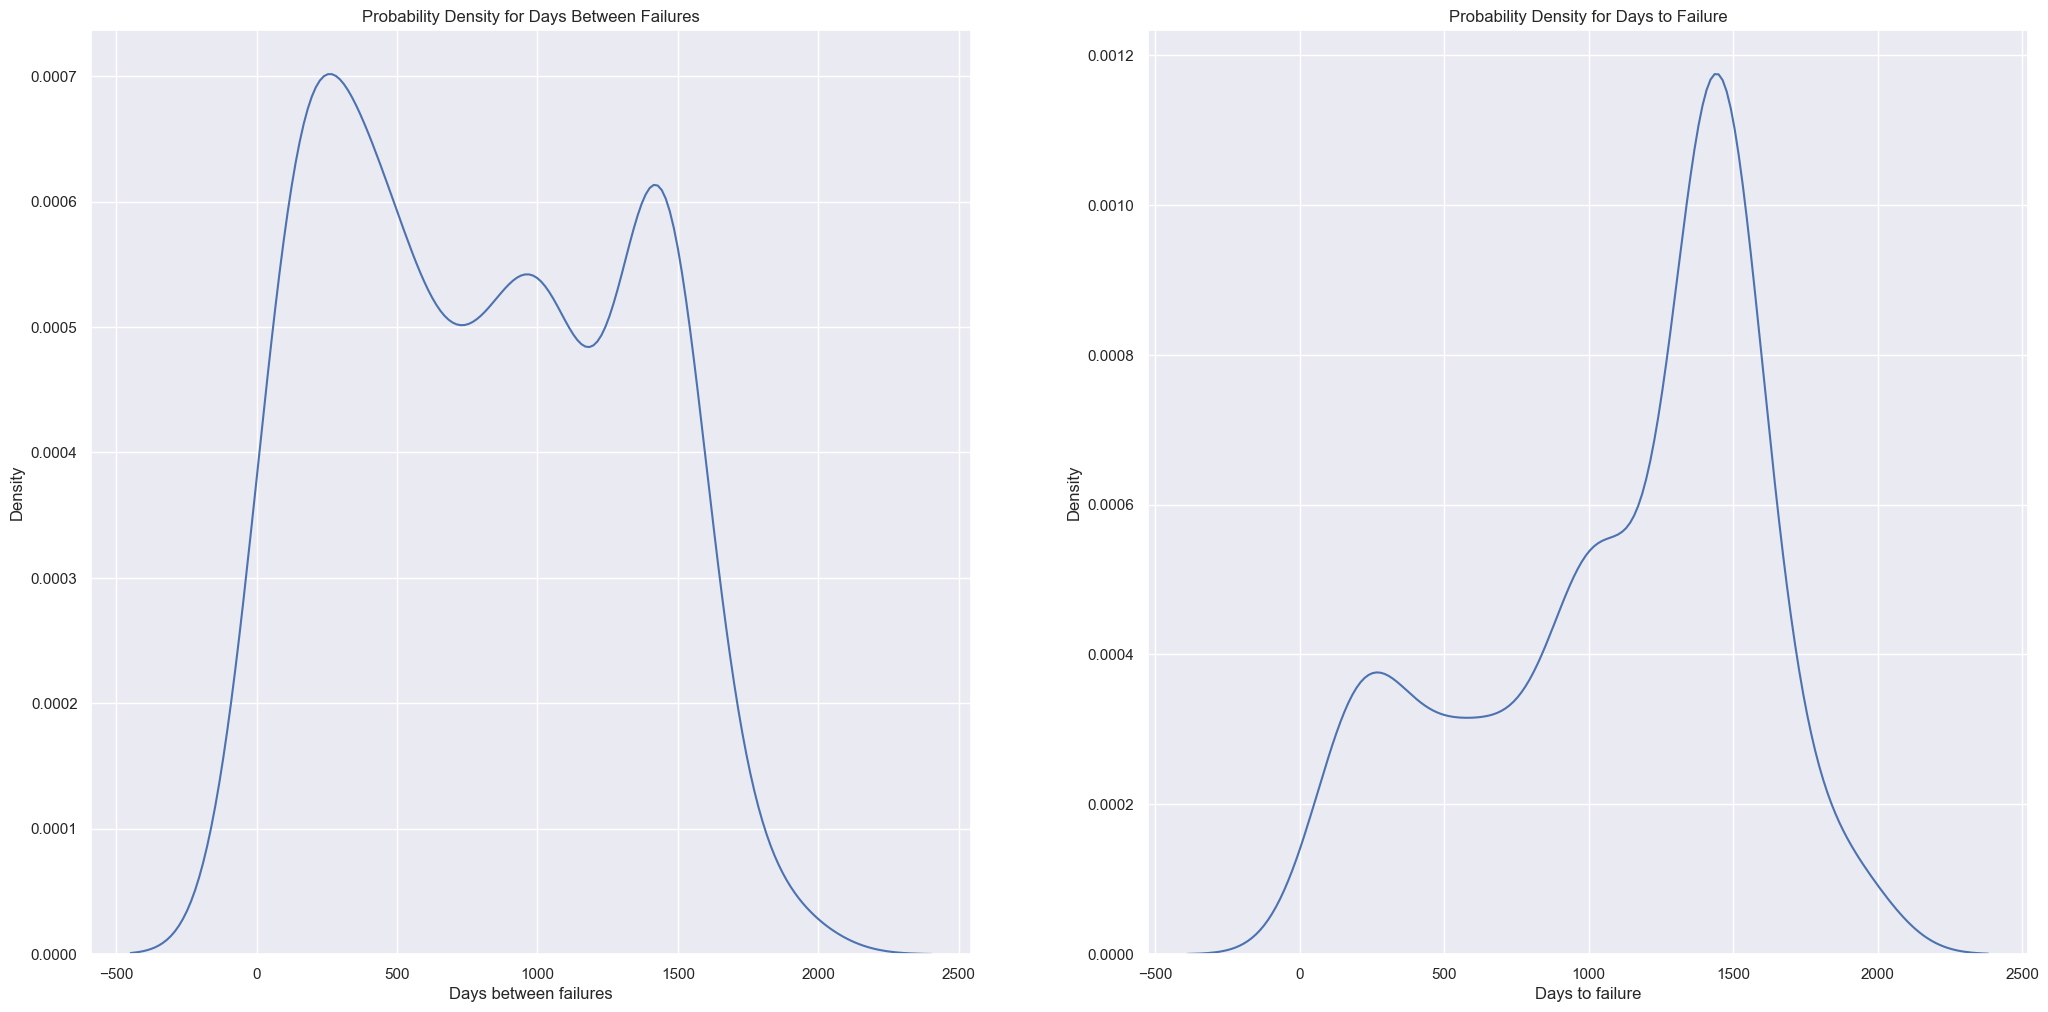

In [72]:
# charts for nummerical values
plt.subplot(1,2,1)
sns.kdeplot(df_analysis['ttf'])
plt.xlabel('Days between failures')
plt.title('Probability Density for Days Between Failures')

plt.subplot(1,2,2)
sns.kdeplot(df_analysis['arrival_days'])
plt.xlabel('Days to failure')
plt.title('Probability Density for Days to Failure')
plt.show(True)

## Categorical Attributes

In [73]:
# Visualize how many attributes each column has
cat_attributes.apply(lambda x: x.unique().shape[0]);

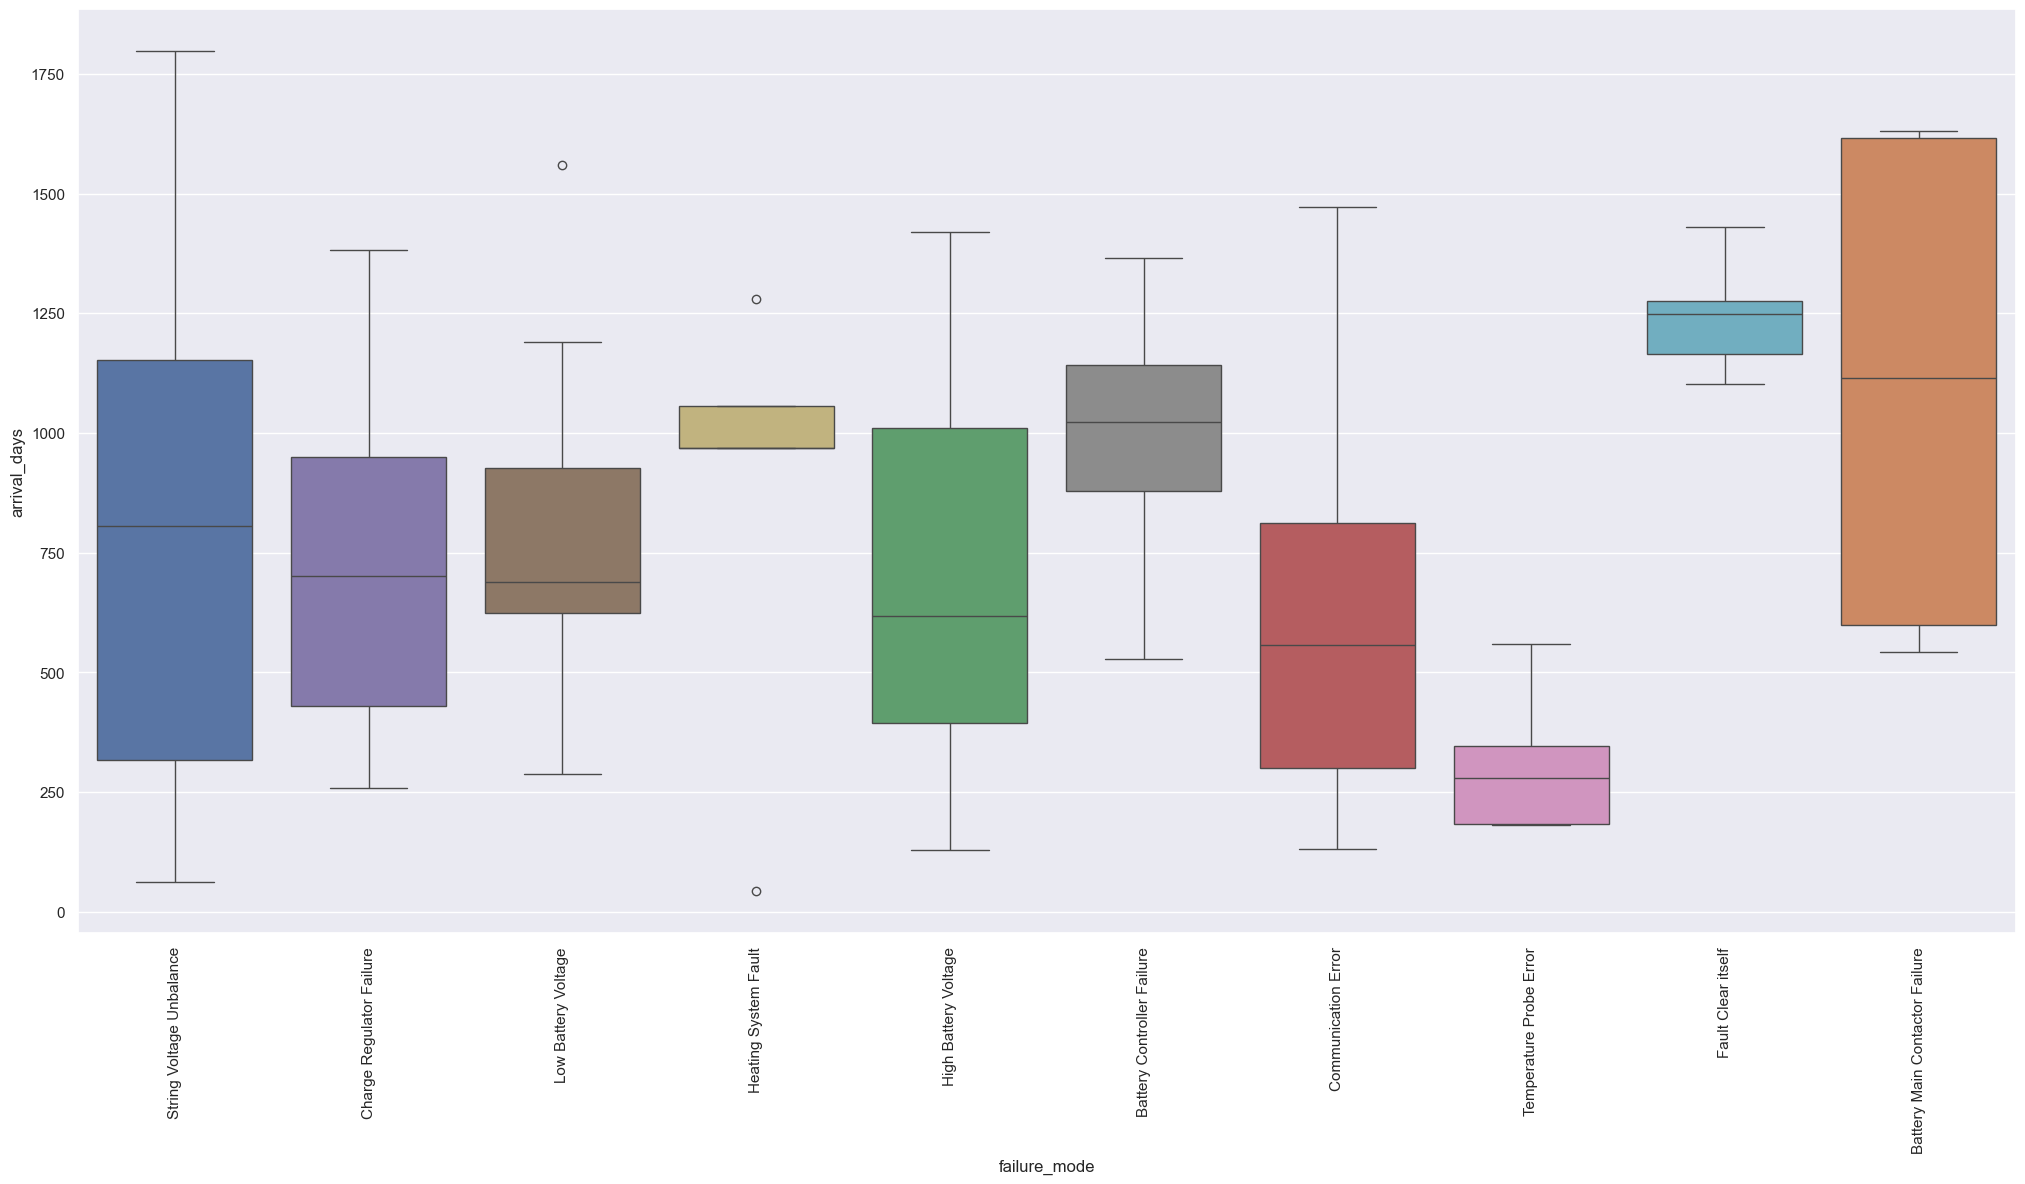

In [76]:
aux1 = df_analysis[df_analysis['type_failure'] == 'F']
sns.boxplot(x='failure_mode',y='arrival_days', data=aux1,hue='failure_mode',order=aux1['failure_mode'].value_counts().index)
plt.xticks(rotation=90);

# Exploratory Data Analysis

## Univariate Analysis

In [77]:
df_analysis.head()

,train,battery_config,full_config,failure_mode,serial_number,start_date,failure_date,type_failure,counter_fullconfig,ttf,hourstf,arrival_days,arrival_hours
65,TS01,BA11,TS01BA11,String Voltage Unbalance,1216456,2019-11-13,2021-06-06,F,1,571,13704,571,13704
0,TS01,BA11,TS01BA11,NaN,1217772,2021-06-06,2023-10-23,S,NaN,869,20856,1440,34560
36,TS01,BA12,TS01BA12,String Voltage Unbalance,1207865,2019-11-13,2020-09-22,F,1,314,7536,314,7536
57,TS01,BA12,TS01BA12,Battery Main Contactor Failure,1220755,2020-09-22,2021-05-09,F,2,229,5496,543,13032
73,TS01,BA12,TS01BA12,String Voltage Unbalance,1207524,2021-05-09,2021-08-11,F,3,94,2256,637,15288


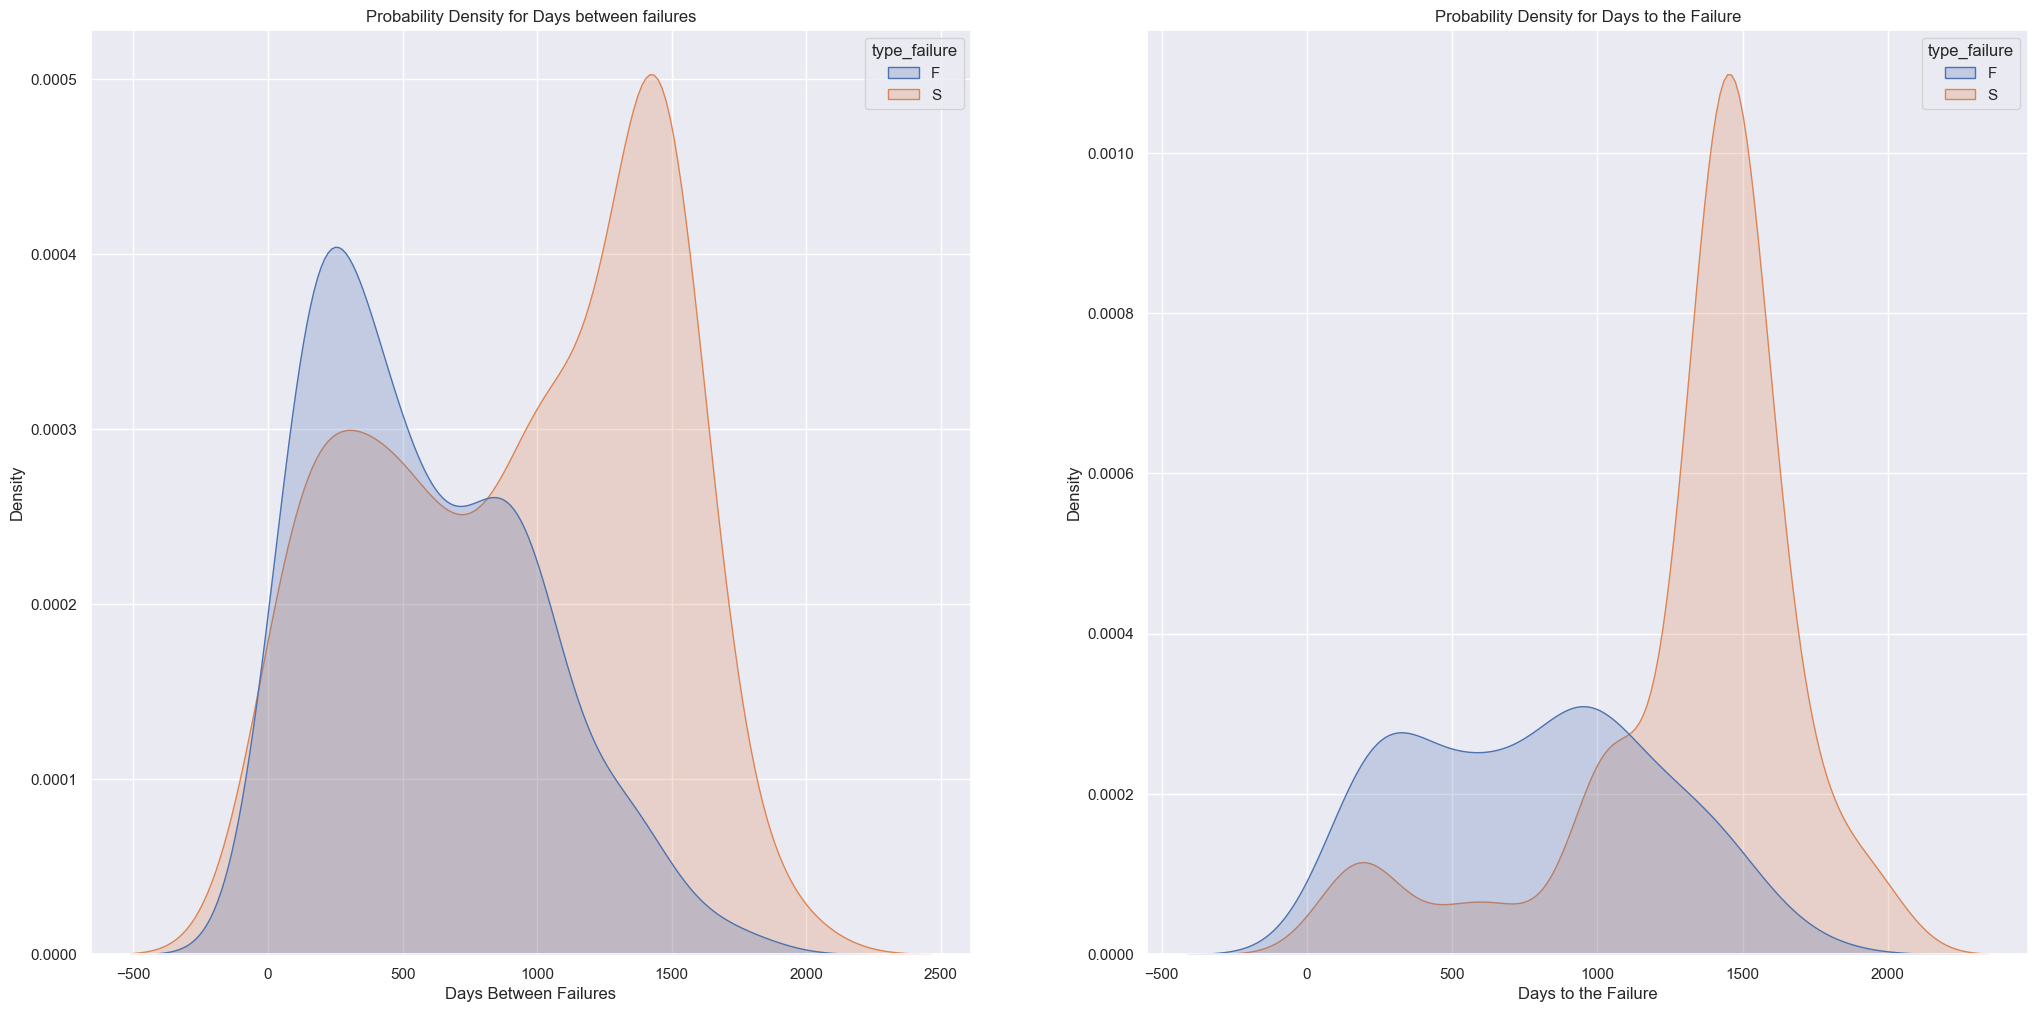

In [78]:
# charts for nummerical values
plt.subplot(1,2,1)
sns.kdeplot(data=df_analysis,x='ttf',hue='type_failure',shade=True)
plt.xlabel('Days Between Failures')
plt.title('Probability Density for Days between failures')

plt.subplot(1,2,2)
sns.kdeplot(data=df_analysis,x='arrival_days',hue='type_failure',shade=True)
plt.xlabel('Days to the Failure')
plt.title('Probability Density for Days to the Failure')
plt.show(True)

# # charts for nummerical values without 'hue'
# plt.subplot(2,2,3)
# sns.kdeplot(data=df_analysis,x='ttf',shade=True)
# plt.xlabel('Days Between Failures')
# plt.title('Probability Density for Days between failures')

# plt.subplot(2,2,4)
# sns.kdeplot(data=df_analysis,x='arrival_days',shade=True)
# plt.xlabel('Days to the Failure')
# plt.title('Probability Density for Days to the Failure')
# plt.show(True)

### Nummerical Variables

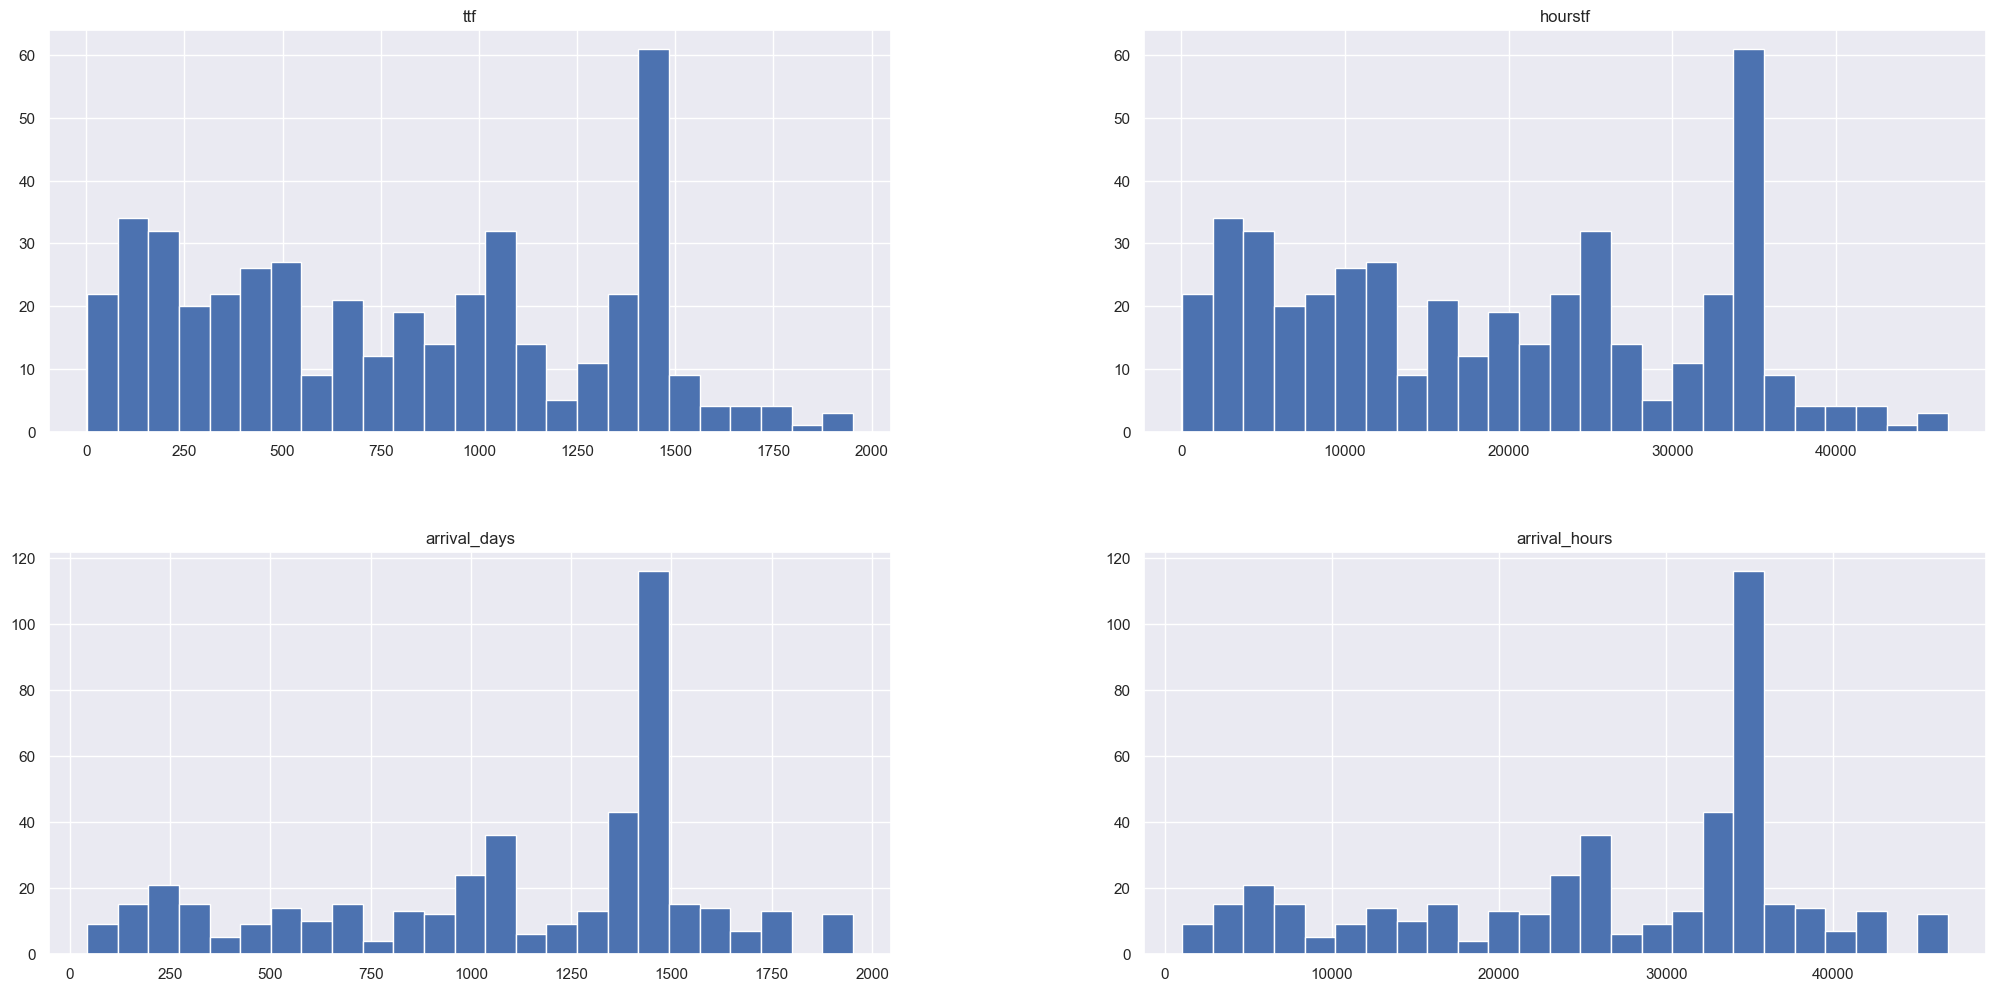

In [79]:
num_attributes.hist(bins=25);

### Categorical Variables

Text(0.5, 1.0, 'Quantity Data per Type')

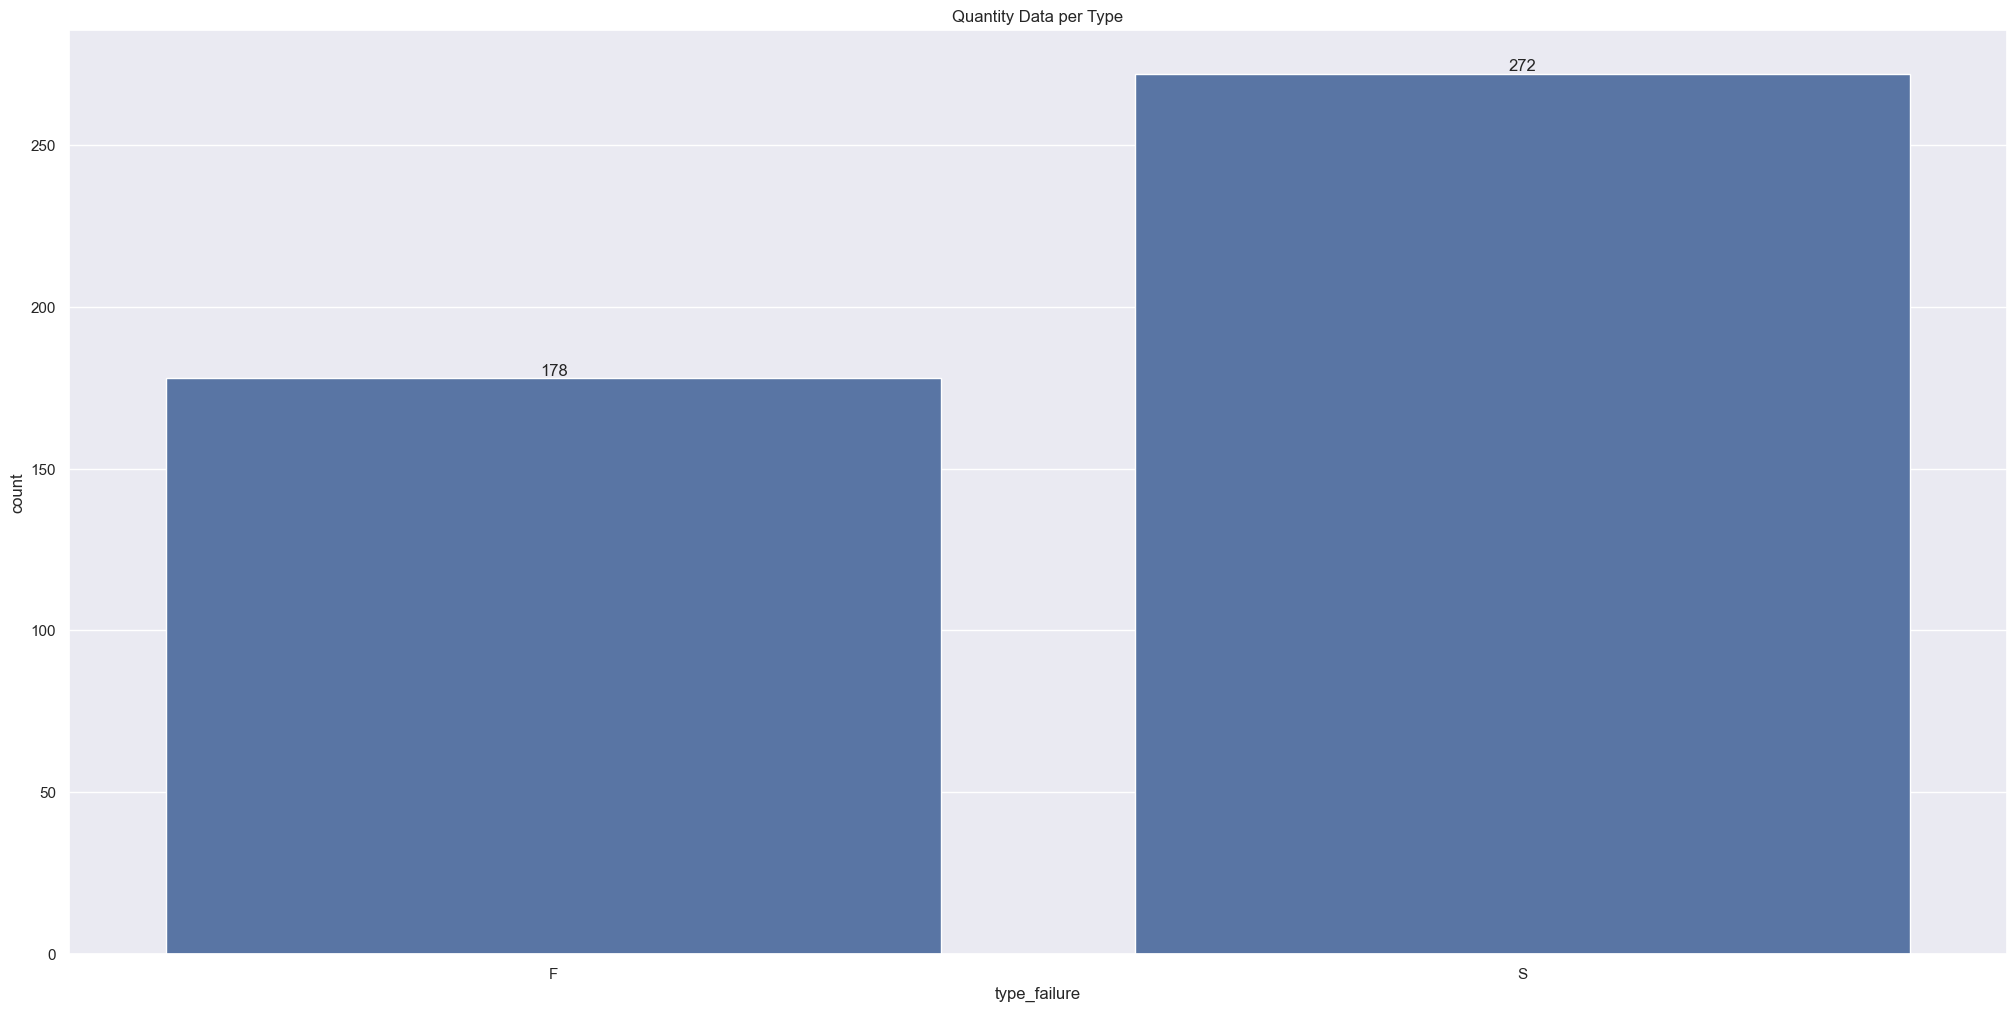

In [80]:
ax = sns.countplot(data=df_analysis,x='type_failure')
ax.bar_label(ax.containers[0]) # put the labels in the values of the graph
plt.title('Quantity Data per Type')

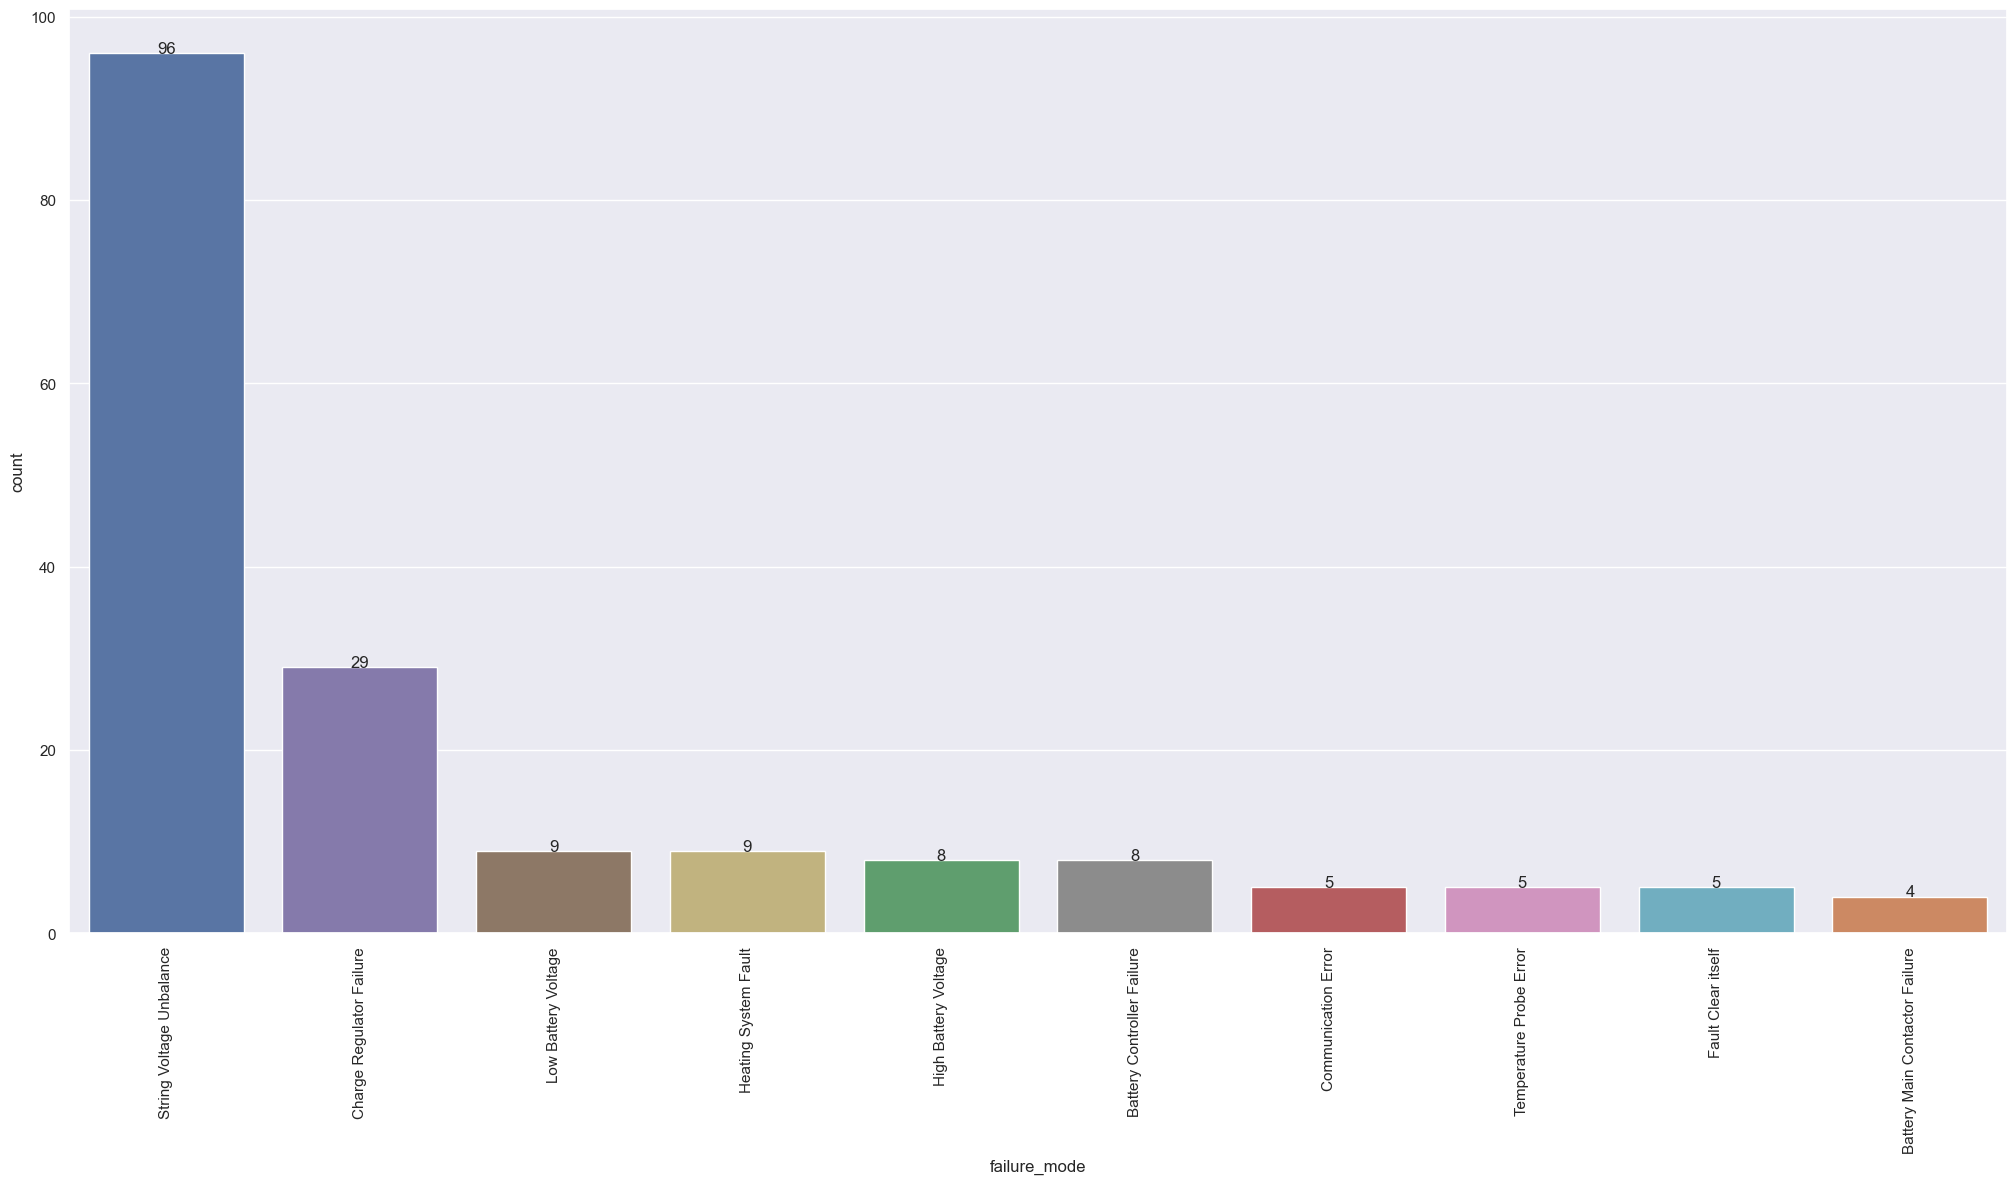

In [81]:
aux = df_analysis[df_analysis['type_failure']=='F']
sns.countplot(data=aux,x='failure_mode',order=aux['failure_mode'].value_counts().index,hue='failure_mode')
plt.xticks(rotation=90)
# put the labels in the values of the graph
for i in range(len(aux['failure_mode'].value_counts())):
    plt.text(i,aux['failure_mode'].value_counts()[i],aux['failure_mode'].value_counts()[i], ha = 'center')

<Axes: xlabel='arrival_days', ylabel='Density'>

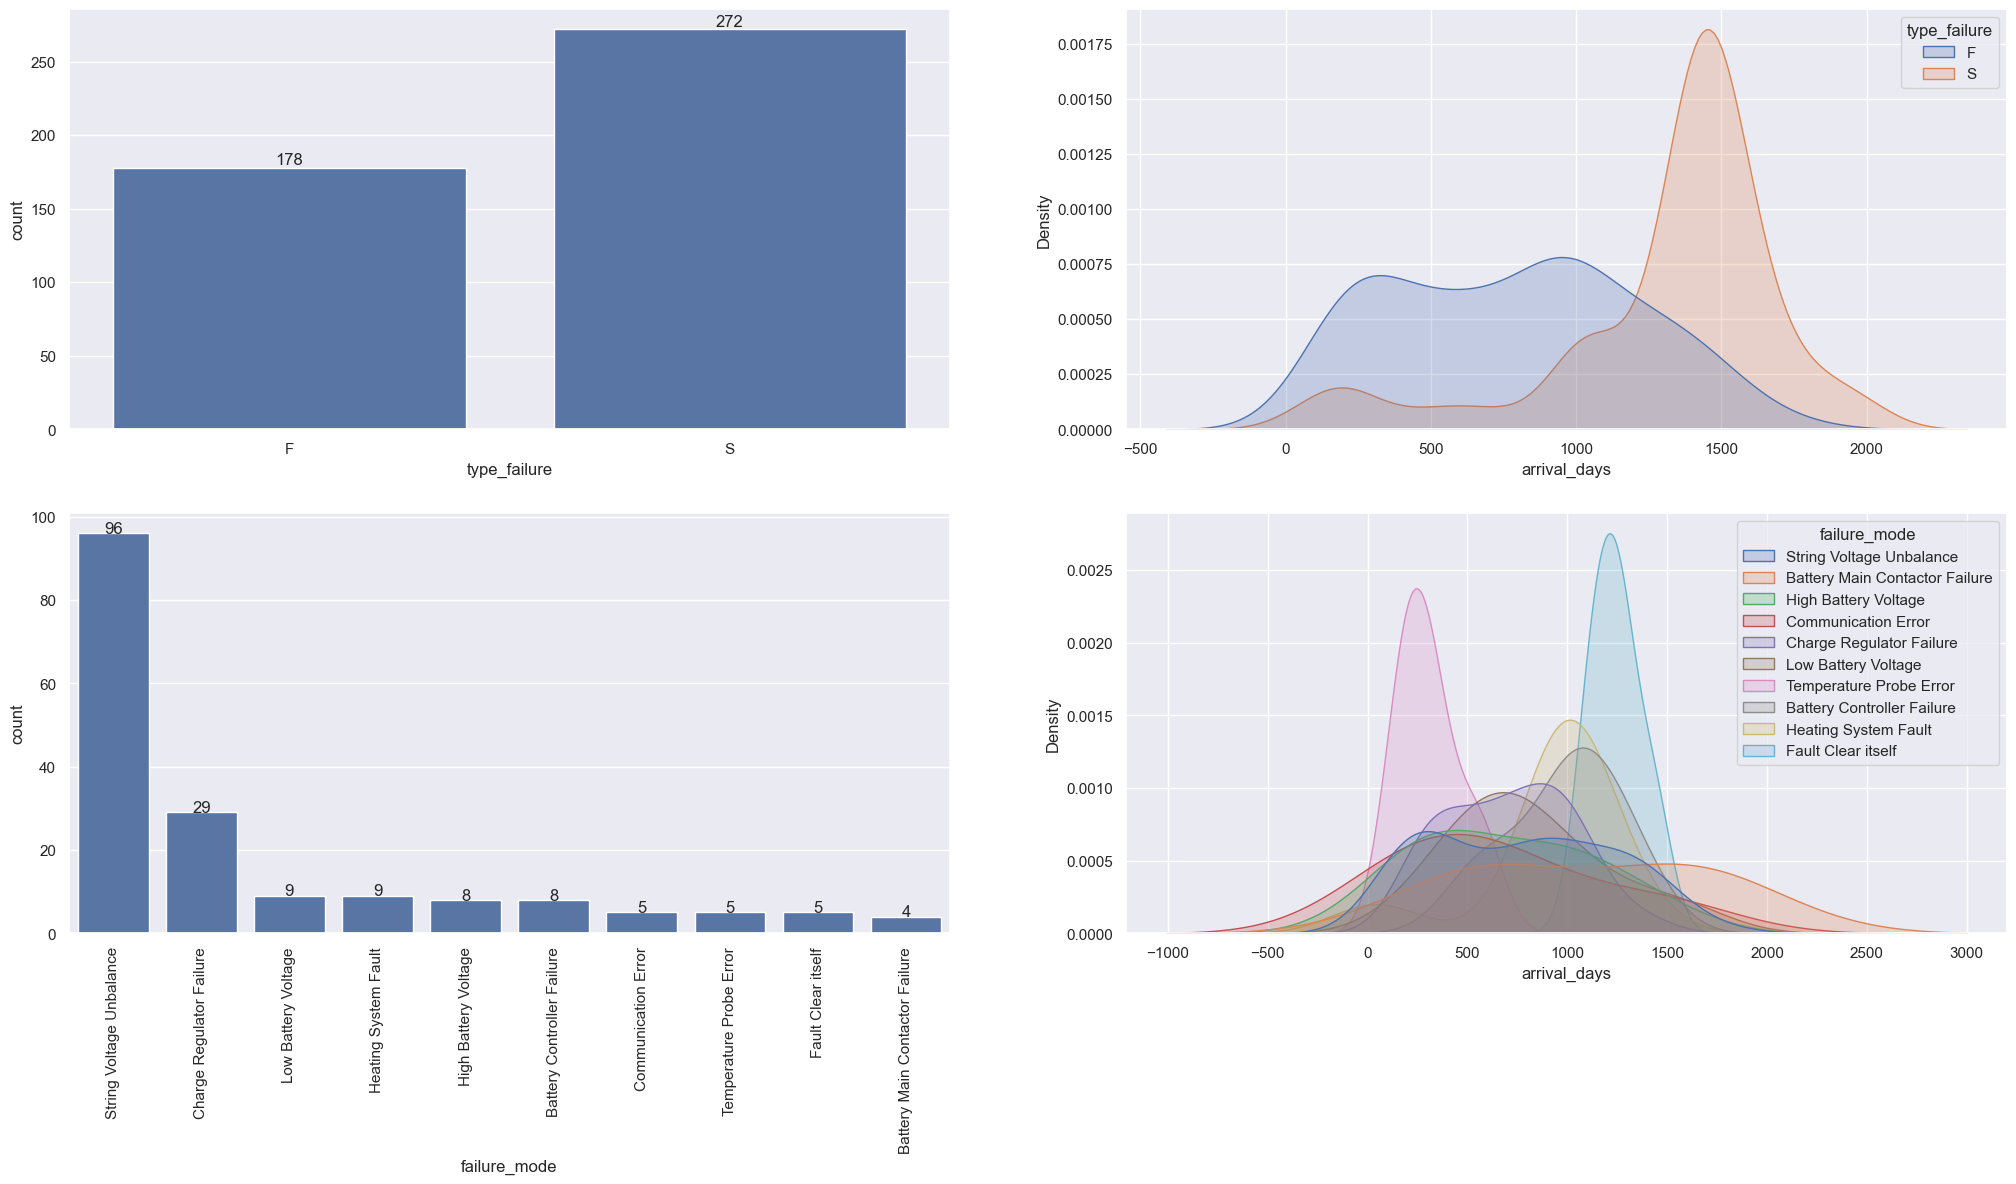

In [82]:
# chart for the type of failure
plt.subplot(2,2,1)
ax = sns.countplot(data=df_analysis,x='type_failure')
ax.bar_label(ax.containers[0]) # put the labels in the values of the graph

plt.subplot(2,2,2)
sns.kdeplot(data = df_analysis, x='arrival_days', hue = 'type_failure', common_norm = False, shade = True)

# chart for the mode of failure
aux = df_analysis[df_analysis['type_failure']=='F']
plt.subplot(2,2,3)
sns.countplot(data=aux,x='failure_mode',order=aux['failure_mode'].value_counts().index)
plt.xticks(rotation=90)
# put the labels in the values of the graph
for i in range(len(aux['failure_mode'].value_counts())):
    plt.text(i,aux['failure_mode'].value_counts()[i],aux['failure_mode'].value_counts()[i], ha = 'center')

plt.subplot(2,2,4)
sns.kdeplot(data = aux, x='arrival_days', hue = 'failure_mode', common_norm = False, shade = True)

# Questions

## How many failures for each period of time?

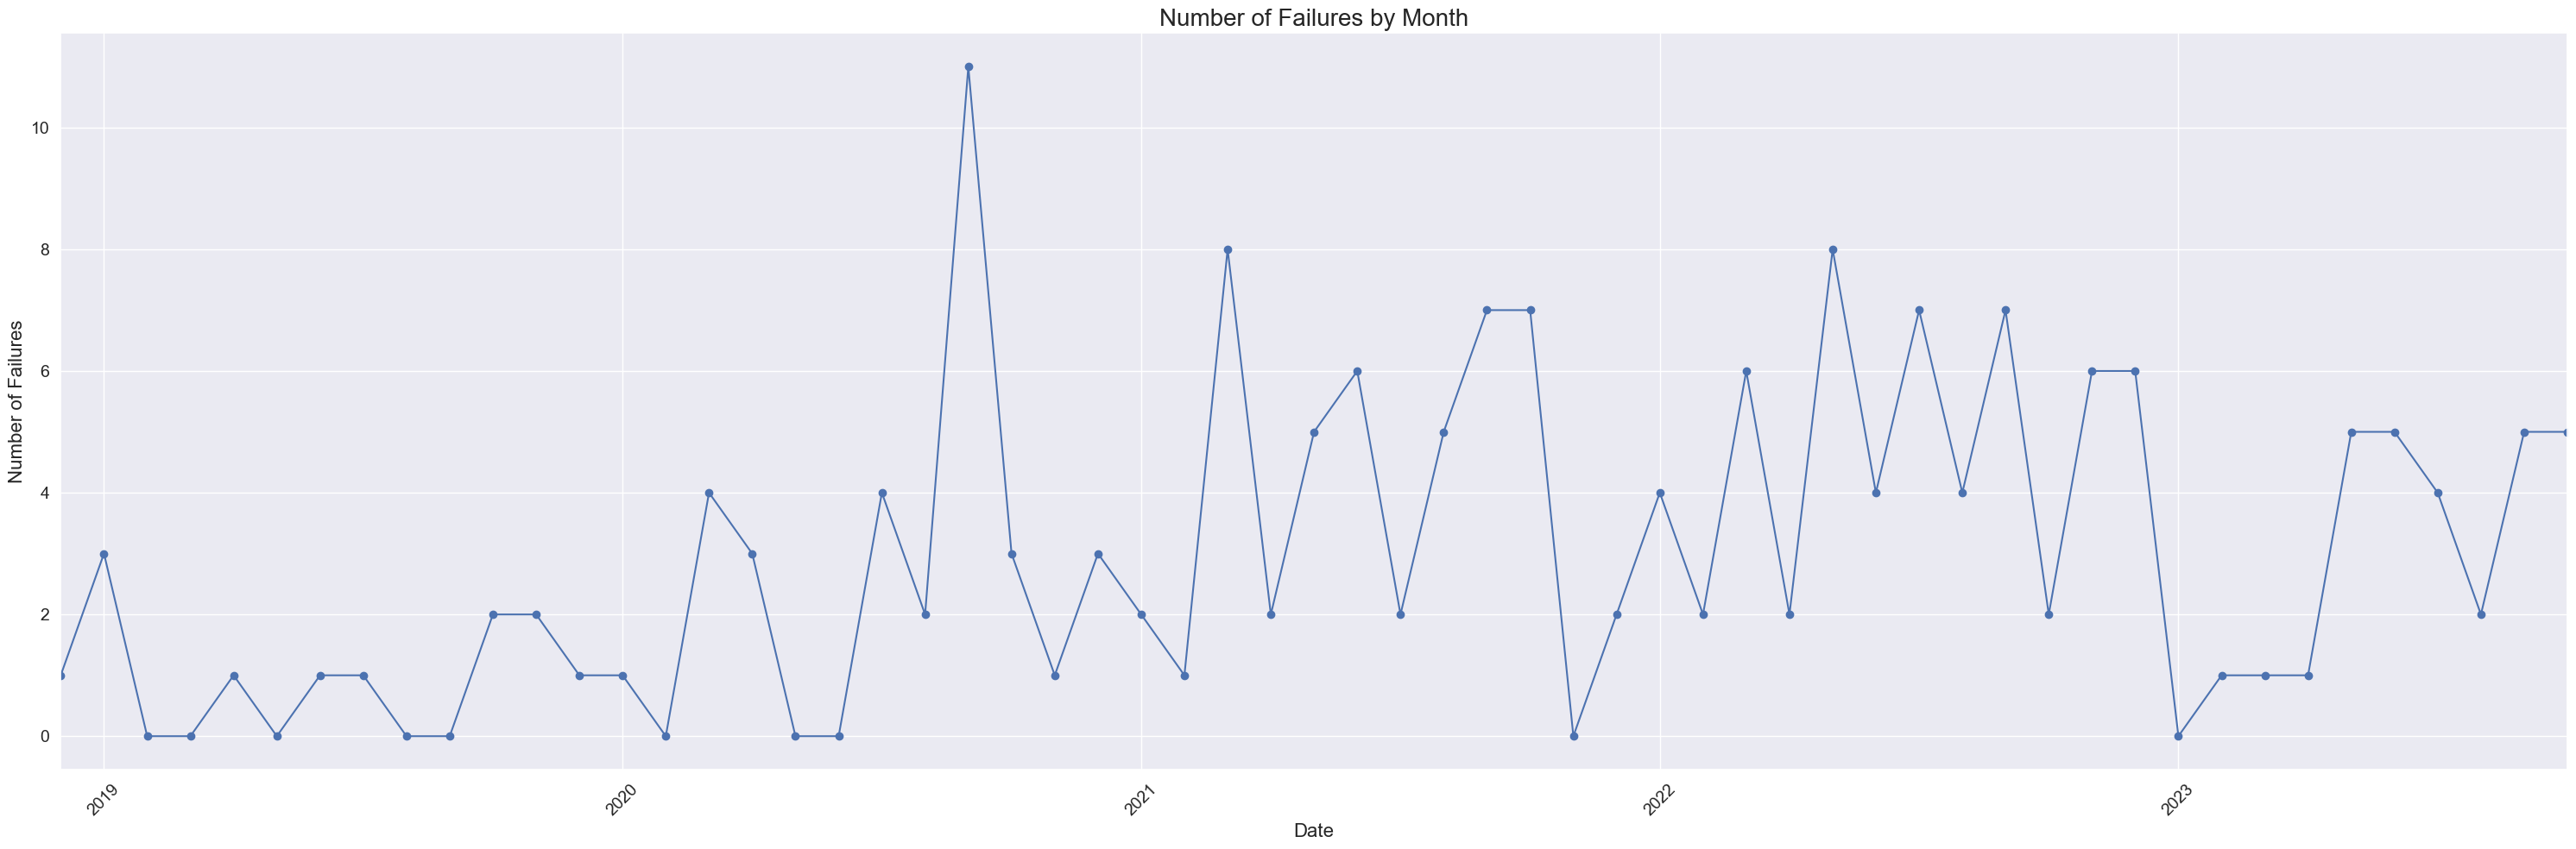

In [83]:
# Create a time series of failures over time
failures_series = df_analysis[df_analysis['type_failure'] == 'F'].set_index('failure_date').resample('M').size()



# Plotting the time series graph
plt.figure(figsize=(30, 10))
failures_series.plot(kind='line', marker='o')
plt.title('Number of Failures by Month', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Number of Failures')
plt.grid(True)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Failures', fontsize=16)
plt.tight_layout()

# Display the graph
plt.show()

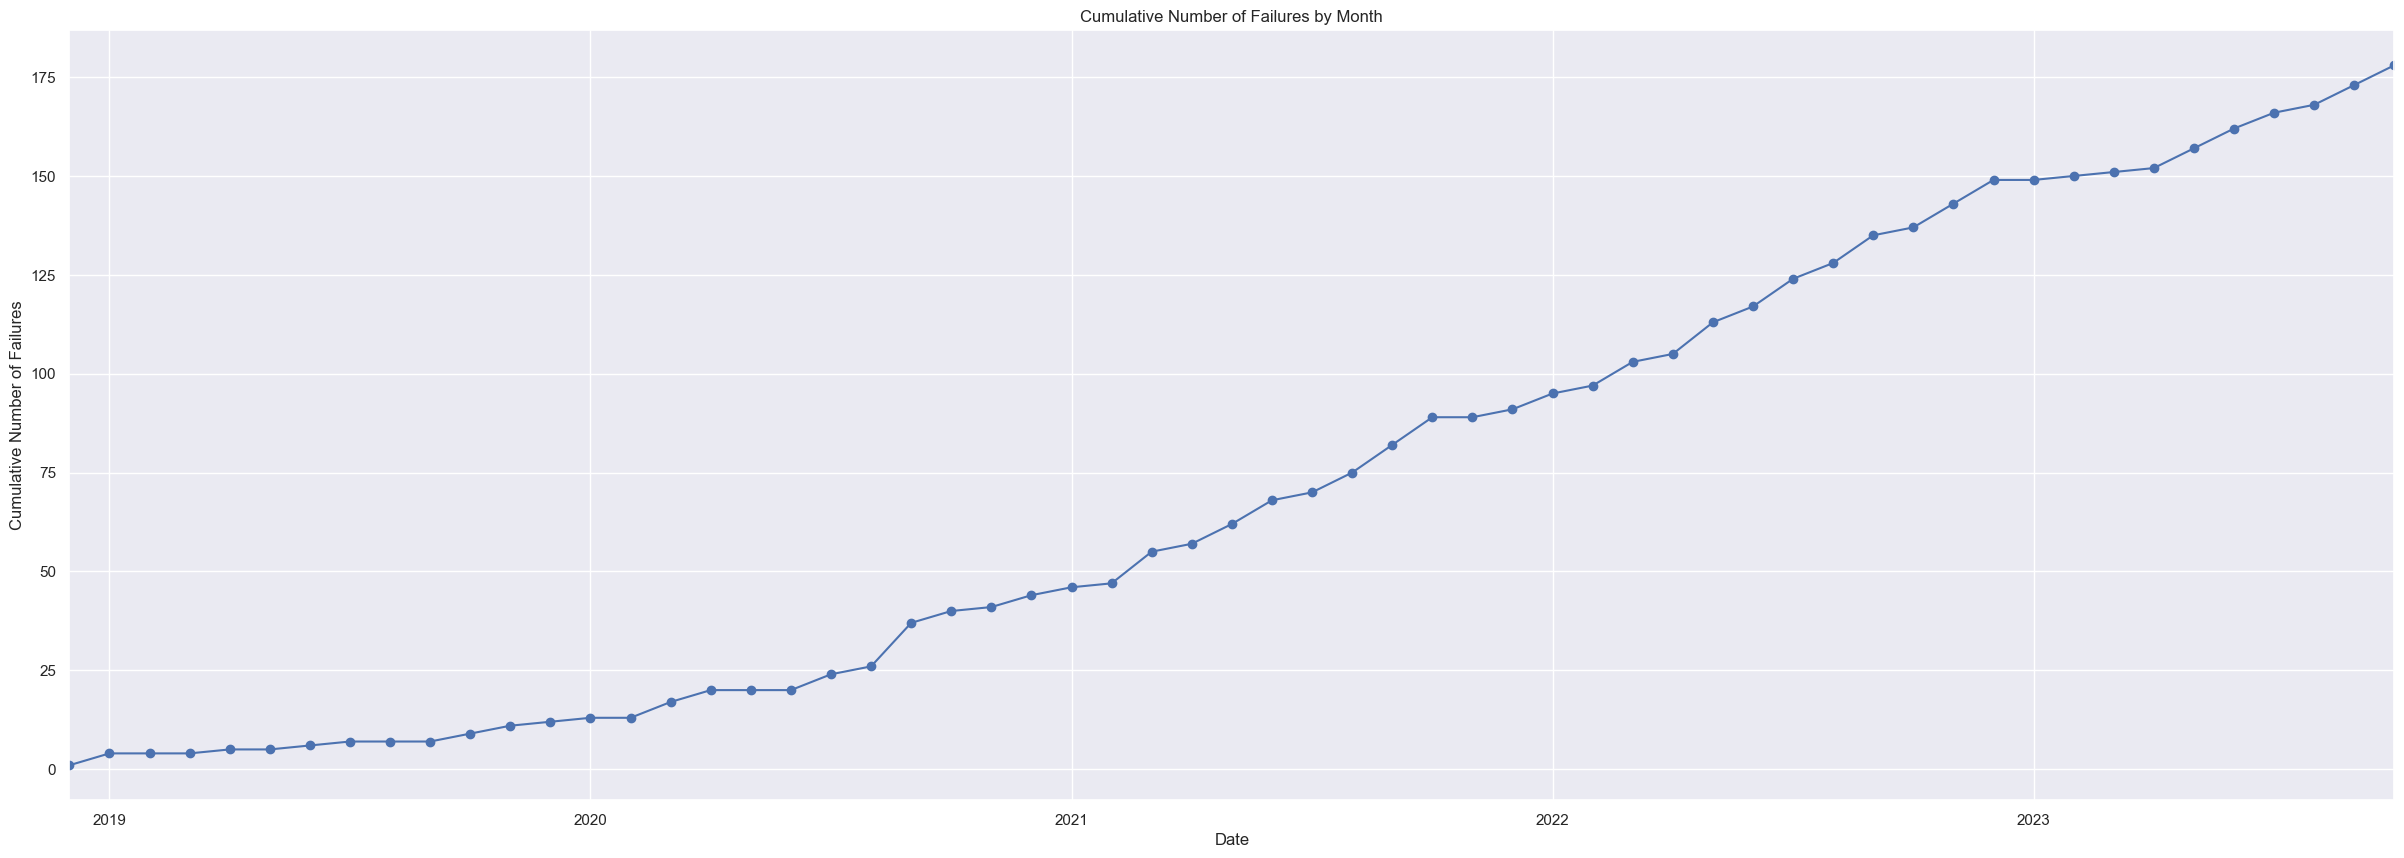

In [84]:
# Plot the cumulative number of failures by month

#Create a time series of failures over time
failures_series_cum = failures_series.cumsum()

# Plotting the time series graph
plt.figure(figsize=(30, 10))
failures_series_cum.plot(kind='line', marker='o')
plt.title('Cumulative Number of Failures by Month')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Failures')
plt.grid(True)


## How's the failure distribution overtime?

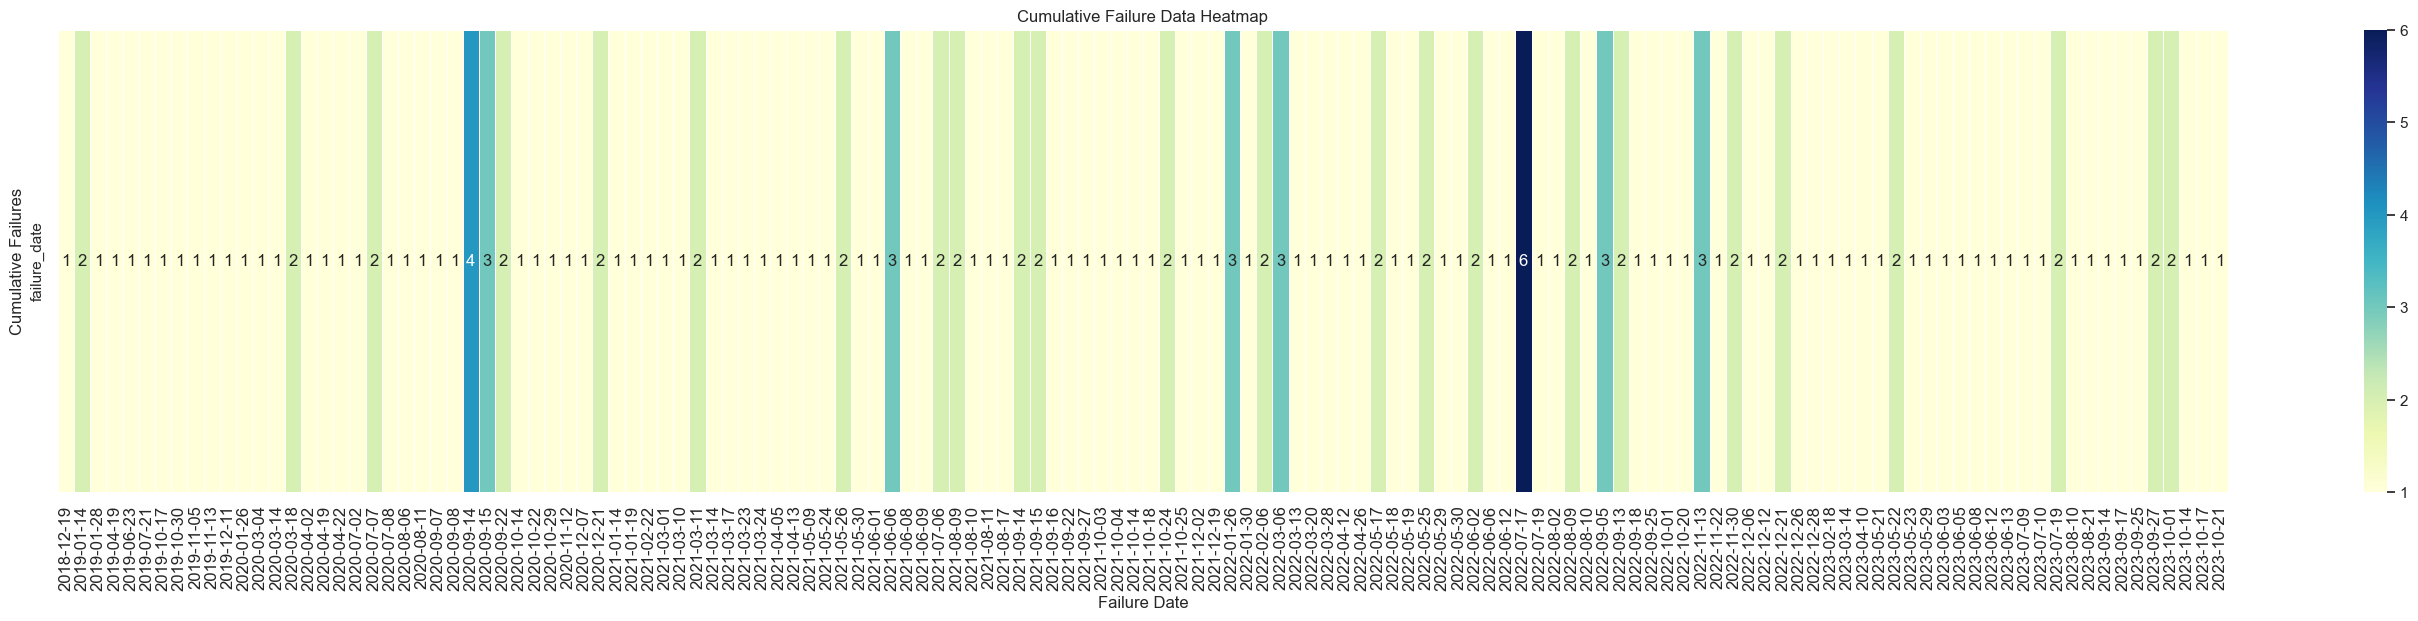

In [85]:
aux = df_analysis[df_analysis['type_failure']=='F']

# Group by 'Failure Date' and calculate the cumulative sum
grouped_df = aux.groupby('failure_date')['failure_date'].count()

# Create the heatmap
plt.figure(figsize=(35, 6))
sns.heatmap(grouped_df.to_frame().T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')

plt.xlabel('Failure Date')
plt.ylabel('Cumulative Failures')
plt.title('Cumulative Failure Data Heatmap')

# Format x-axis labels to show only the date
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df.index.strftime('%Y-%m-%d')))

plt.show()

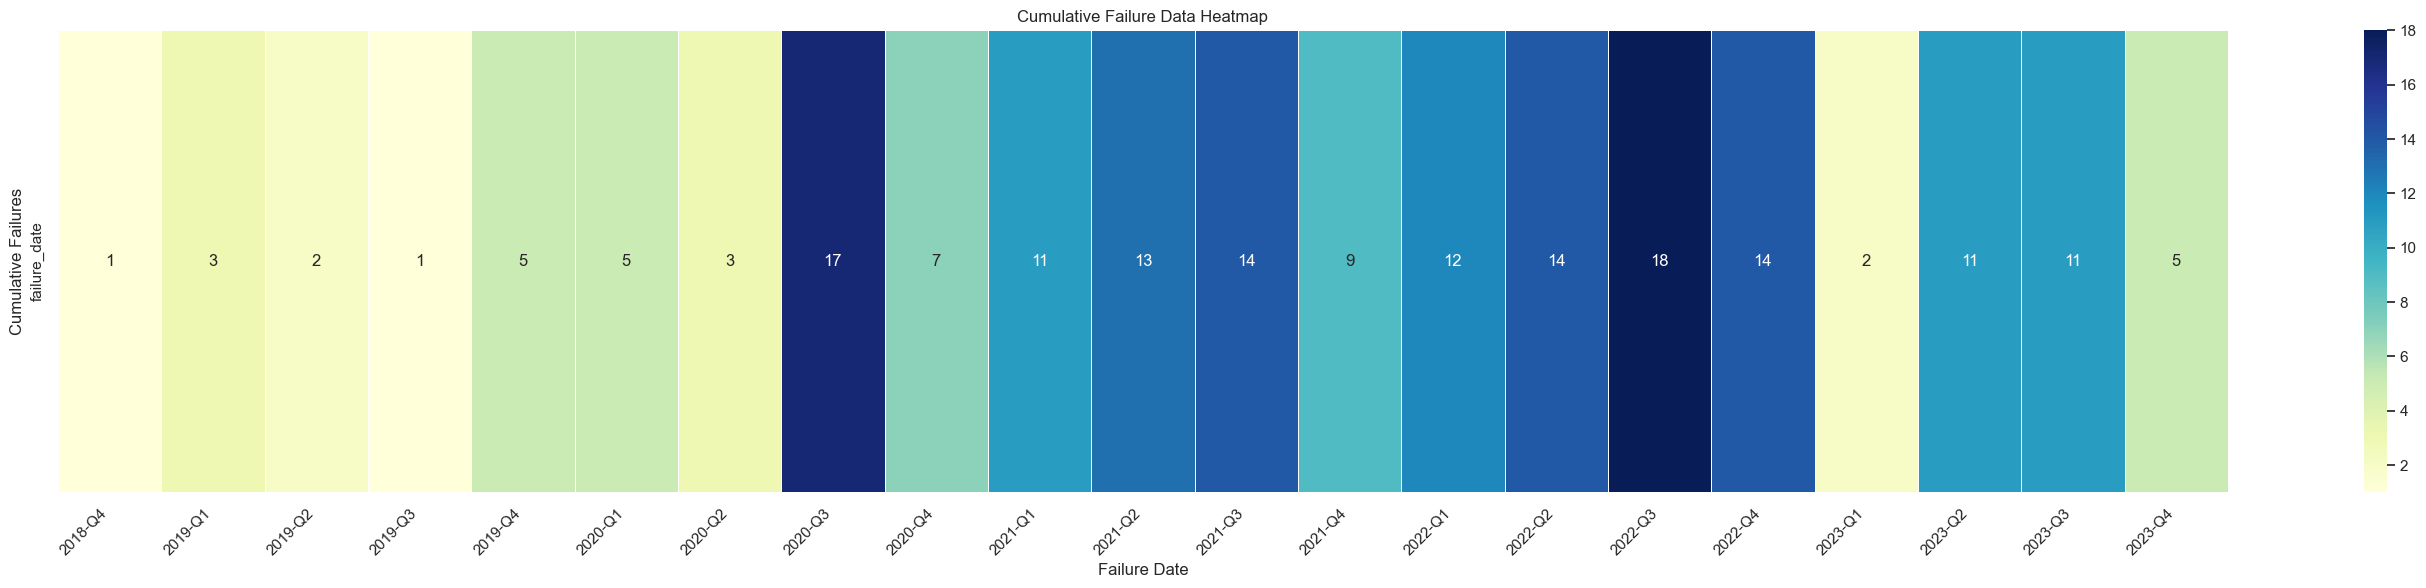

In [86]:
aux = df_analysis[df_analysis['type_failure']=='F']

# Group by quarter and calculate the cumulative sum
aux['Quarter'] = aux['failure_date'].dt.to_period('Q')
grouped_df = aux.groupby('Quarter')['failure_date'].count()

# Create the heatmap
plt.figure(figsize=(35, 6))
sns.heatmap(grouped_df.to_frame().T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')

plt.xlabel('Failure Date')
plt.ylabel('Cumulative Failures')
plt.title('Cumulative Failure Data Heatmap')

# Format x-axis labels to show only the date
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df.index.strftime('%Y-Q%q')))

plt.show()

In [87]:
aux.tail()

,train,battery_config,full_config,failure_mode,serial_number,start_date,failure_date,type_failure,counter_fullconfig,ttf,hourstf,arrival_days,arrival_hours,Quarter
69,TS42,BA11,TS42BA11,Low Battery Voltage,1216429,2021-05-30,2021-07-06,F,2,37,888,477,11448,2021Q3
13,TS43,BA13,TS43BA13,String Voltage Unbalance,1217560,2019-09-04,2020-03-04,F,1,182,4368,182,4368,2020Q1
155,TS44,BA11,TS44BA11,Charge Regulator Failure,1218498,2021-01-17,2023-05-23,F,1,856,20544,856,20544,2023Q2
102,TS44,BA22,TS44BA22,High Battery Voltage,1208212,2021-01-17,2022-03-28,F,1,435,10440,435,10440,2022Q1
124,TS46,BA22,TS46BA22,String Voltage Unbalance,1208210,2022-06-01,2022-08-02,F,1,62,1488,62,1488,2022Q3


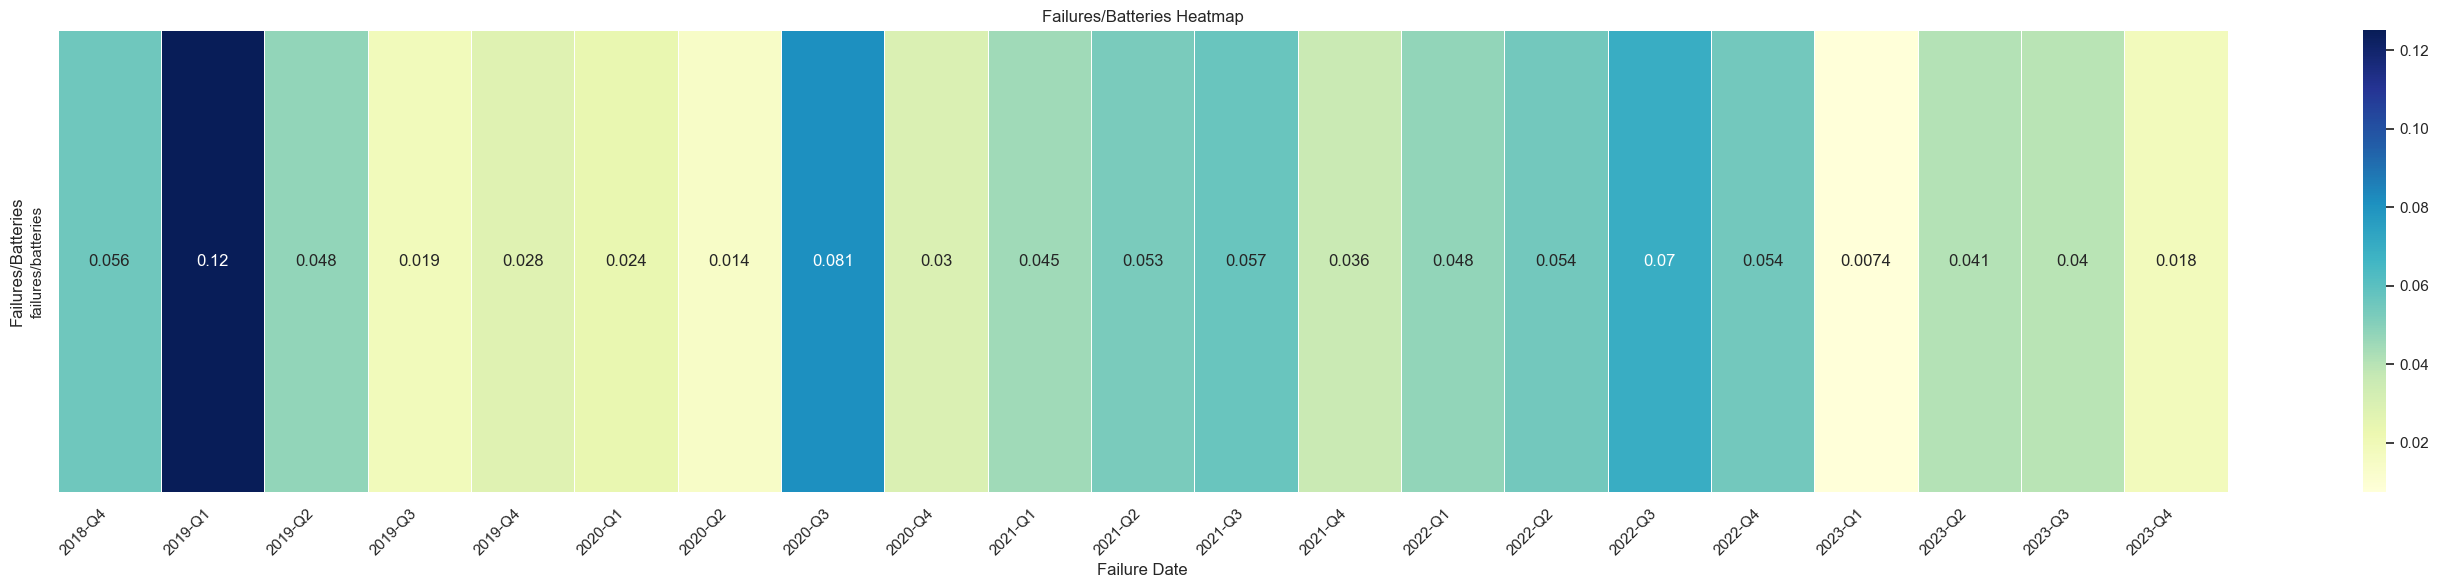

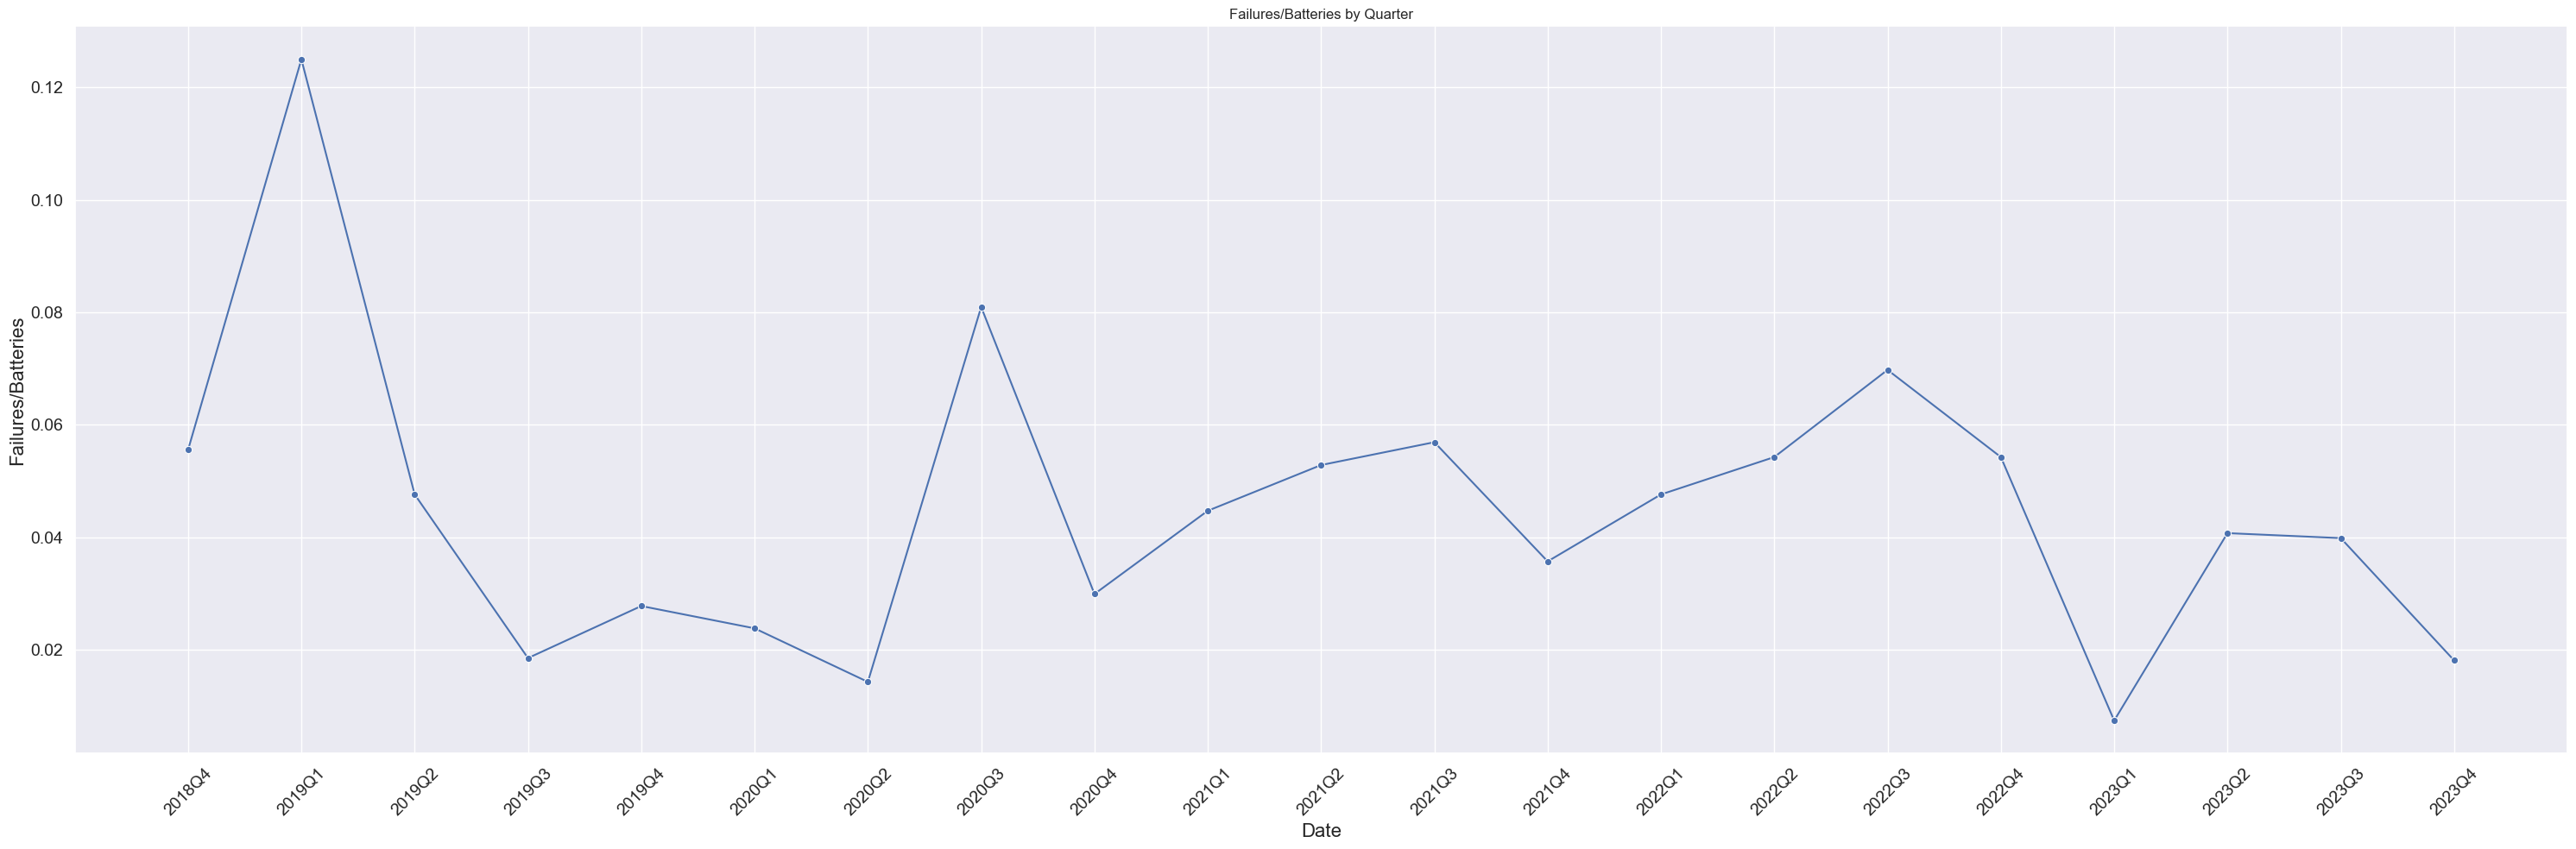

In [ ]:
# join the dataframes
#aux = df_analysis.merge(df_tpower[['full_config','power_on_date']], left_on='full_config', right_on='full_config', how='inner')

aux1 = df_analysis[df_analysis['type_failure']=='F']

# Group by quarter and calculate the cumulative sum
aux1['failure_date_quarter'] = aux1['failure_date'].dt.to_period('Q')
aux1_grouped_df = aux1.groupby('failure_date_quarter')['failure_date'].count()


aux2 = df_tpower.sort_values('power_on_date').copy()
aux2['cum_batteries_operating'] = aux2.reset_index().index+1
aux2['power_on_date_quarter'] = aux2['power_on_date'].dt.to_period('Q')

aux3 = aux1.merge(aux2[['power_on_date_quarter','cum_batteries_operating']], left_on='failure_date_quarter', right_on='power_on_date_quarter', how='inner')

aux2_grouped_df = aux2.groupby('power_on_date_quarter')['cum_batteries_operating'].max()

# transform aux1_grouped_df in a dataframe, combine with aux2_grouped_df
aux1_grouped_df = aux1_grouped_df.to_frame().reset_index()

grouped_df = aux1_grouped_df.merge(aux2_grouped_df.to_frame(), left_on='failure_date_quarter', right_on='power_on_date_quarter', how='left')
grouped_df

# on grouped_df, fill the NaN values in 'cum_batteries_operating' with the revious value
grouped_df['cum_batteries_operating'] = grouped_df['cum_batteries_operating'].fillna(method='ffill')

grouped_df['failures/batteries'] = grouped_df['failure_date']/grouped_df['cum_batteries_operating']
grouped_df

# create the heatmap ONLY with 'failures/batteries' column
plt.figure(figsize=(35, 6))
sns.heatmap(grouped_df[['failures/batteries']].T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')

plt.xlabel('Failure Date')
plt.ylabel('Failures/Batteries')
plt.title('Failures/Batteries Heatmap')

# Format x-axis labels to show only the date
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df['failure_date_quarter'].dt.strftime('%Y-Q%q')))
plt.show()

# create a lineplot with 'failures/batteries' column
plt.figure(figsize=(30, 10))
sns.lineplot(data=grouped_df, x=grouped_df['failure_date_quarter'].astype('str'), y='failures/batteries', marker='o')
plt.title('Failures/Batteries by Quarter')
plt.xlabel('Date')
plt.ylabel('Failures/Batteries')
plt.grid(True)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Failures/Batteries', fontsize=16)
plt.tight_layout()
plt.show()

### Distribution of failures by number of failures (per quarter)

## Is the interval between failures getting longer or shorter?

In [89]:
df_analysis.head()

,train,battery_config,full_config,failure_mode,serial_number,start_date,failure_date,type_failure,counter_fullconfig,ttf,hourstf,arrival_days,arrival_hours
65,TS01,BA11,TS01BA11,String Voltage Unbalance,1216456,2019-11-13,2021-06-06,F,1,571,13704,571,13704
0,TS01,BA11,TS01BA11,NaN,1217772,2021-06-06,2023-10-23,S,NaN,869,20856,1440,34560
36,TS01,BA12,TS01BA12,String Voltage Unbalance,1207865,2019-11-13,2020-09-22,F,1,314,7536,314,7536
57,TS01,BA12,TS01BA12,Battery Main Contactor Failure,1220755,2020-09-22,2021-05-09,F,2,229,5496,543,13032
73,TS01,BA12,TS01BA12,String Voltage Unbalance,1207524,2021-05-09,2021-08-11,F,3,94,2256,637,15288


Results from ROCOF analysis:
Laplace test results: U = -5.064, z_crit = (-1.96,+1.96)
At 95% confidence level the ROCOF is IMPROVING. Assume NHPP.
ROCOF assuming NHPP has parameters: Beta_hat = 0.696 , Lambda_hat = 0.0063


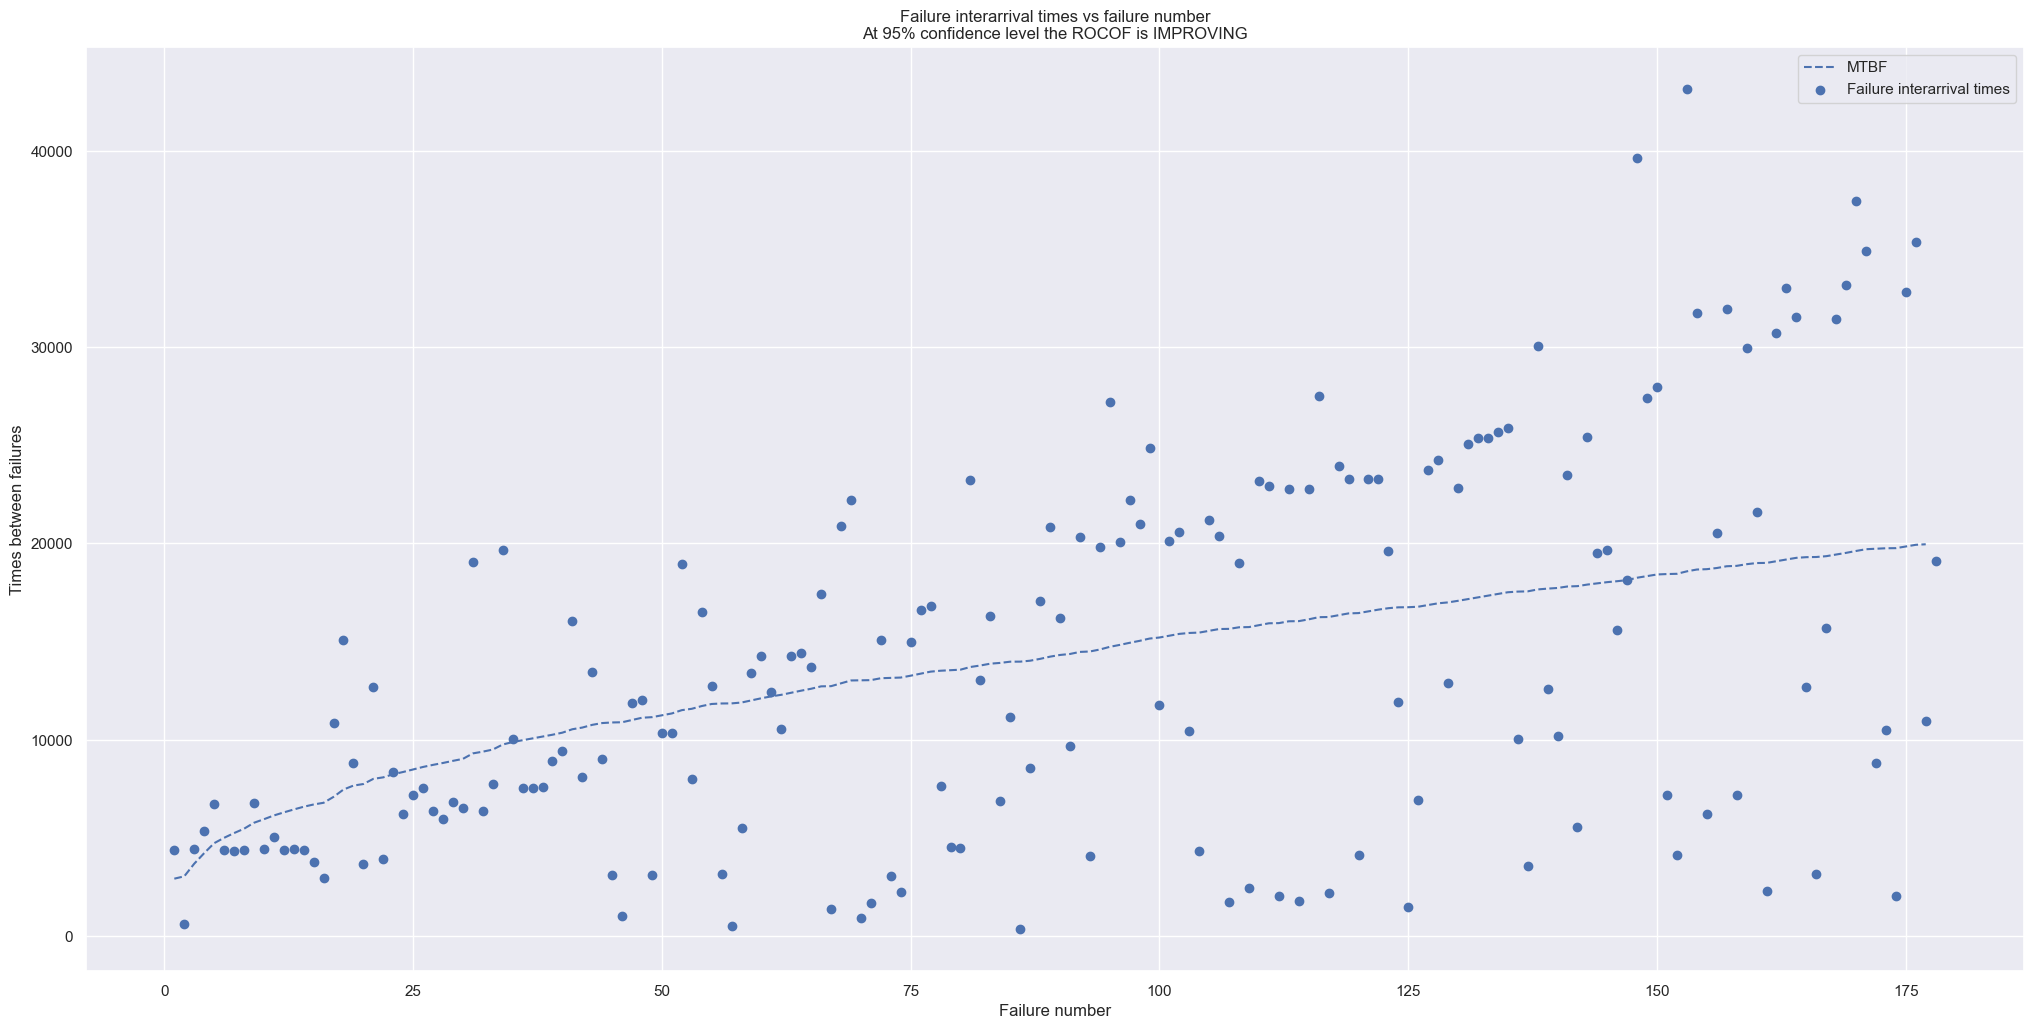

In [90]:
#aux = df_analysis[df_analysis['type_failure']=='F'].sort_values(by=['full_config','failure_date'])
aux = df_analysis[df_analysis['type_failure']=='F'].sort_values(by=['failure_date'])
#laplace_test = rs.ROCOF(times_between_failures=list(aux.hourstf))
laplace_test = rs.ROCOF(times_between_failures=list(aux.hourstf))

plt.show()

## What is the average number of failures in the fleet per operating time?

In [91]:
aux = df_analysis[df_analysis['type_failure']=='F']

# Create a list of lists for 'arrival_time' grouped by 'n_serie'
arrival_hours_lists = aux.groupby('full_config')['arrival_hours'].agg(list).tolist()

arrival_days_lists = aux.groupby('full_config')['arrival_days'].agg(list).tolist()

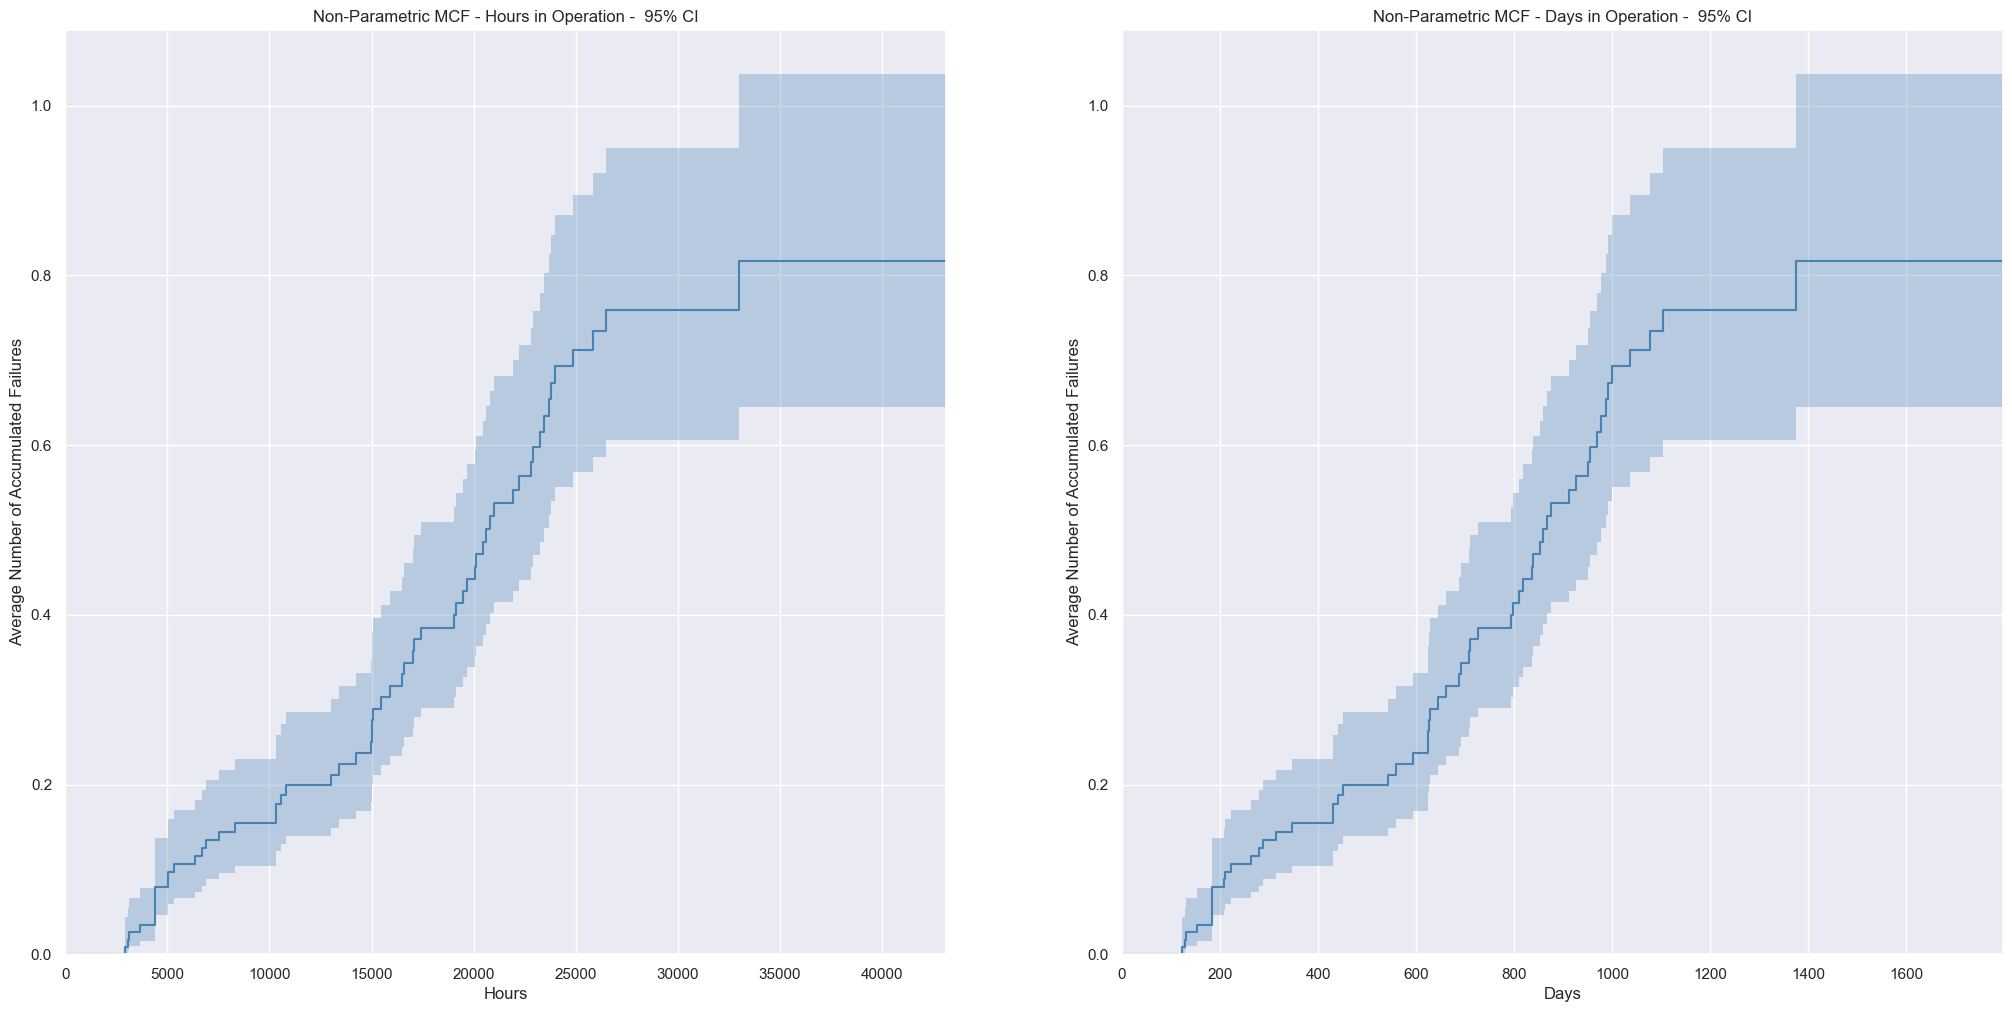

In [92]:
plt.subplot(1,2,1)
MCF_nonparametric(data=arrival_hours_lists,print_results=False)
plt.title('Non-Parametric MCF - Hours in Operation -  95% CI')
plt.xlabel('Hours')
plt.ylabel('Average Number of Accumulated Failures')

plt.subplot(1,2,2)
MCF_nonparametric(data=arrival_days_lists,print_results=False)
plt.title('Non-Parametric MCF - Days in Operation -  95% CI')
plt.xlabel('Days')
plt.ylabel('Average Number of Accumulated Failures')
plt.show()

### Parametric MCF

Mean Cumulative Function Parametric Model (95% CI):
MCF = (t/α)^β
Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha          31.459         2.78914    26.441   37.4294
     Beta         0.74815       0.0102196  0.728386  0.768451 

Since Beta is less than 1, the system repair rate is IMPROVING over time.


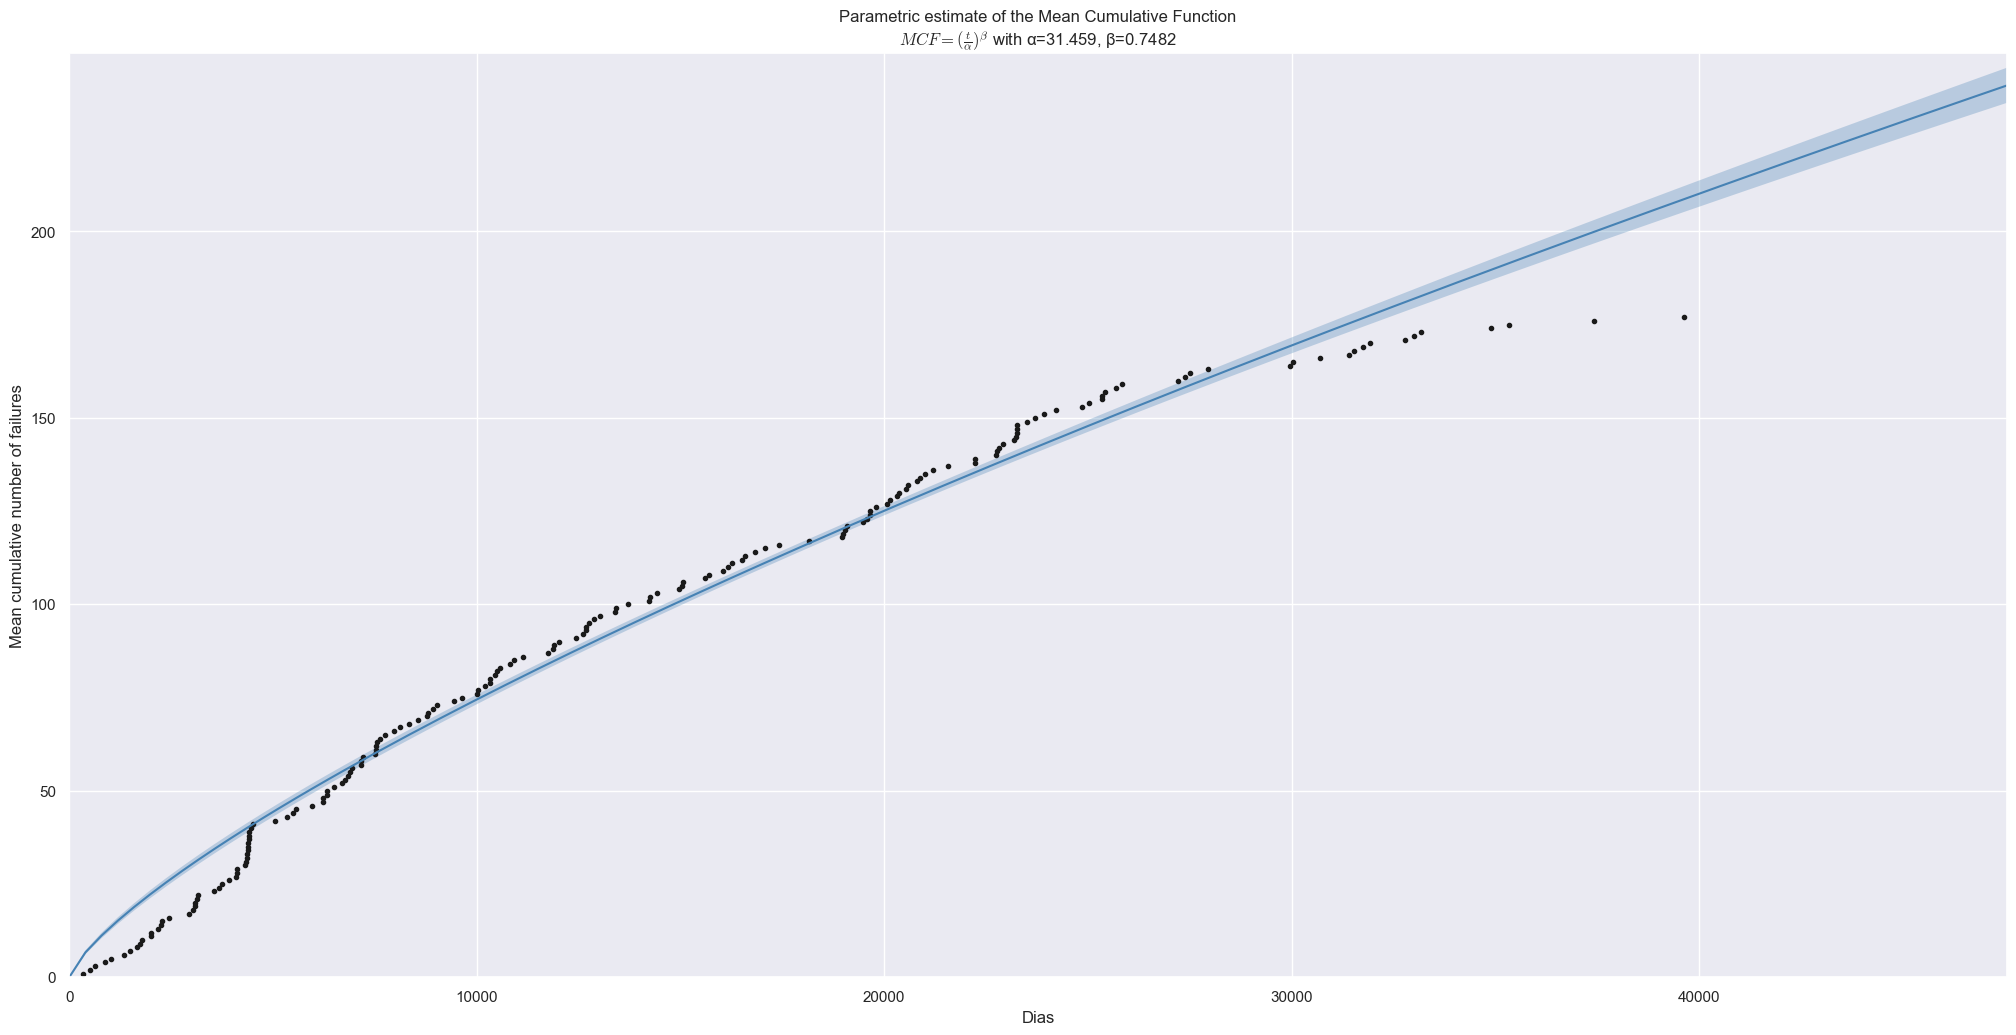

In [93]:
MCF_parametric(data=df_analysis[df_analysis['type_failure']=='F'].sort_values('hourstf').hourstf.tolist(),CI=0.95)
#plt.title('Parametric MCF - Operating Days -  95% de IC')
plt.xlabel('Dias')
plt.show()

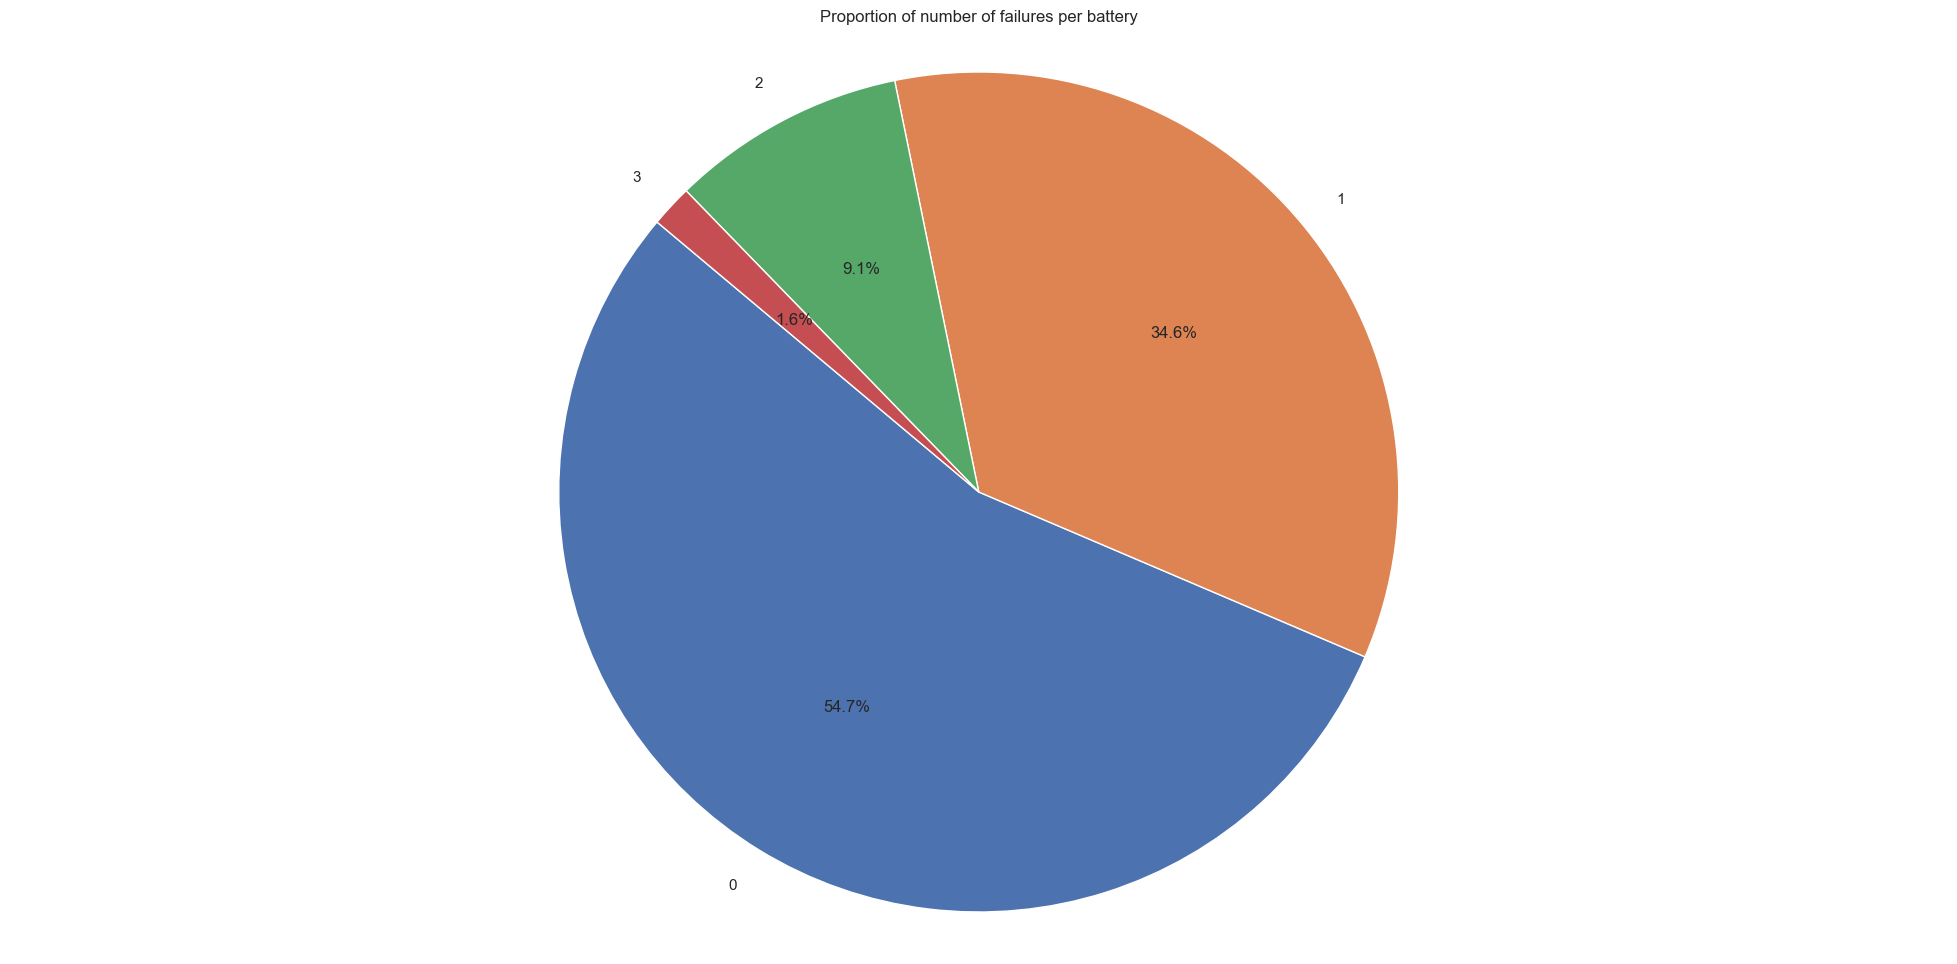

In [94]:
failure_counts = df_analysis[df_analysis['type_failure'] == 'F'].groupby('serial_number')['type_failure'].count()
failure_counts = failure_counts.reset_index()

# Count items with 'S' and add them as 0 failures
items_censored = df_analysis[df_analysis['type_failure'] == 'S']['serial_number'].unique()
items_censored = [item for item in items_censored if item not in failure_counts['serial_number'].values]

s_counts = pd.DataFrame({'n_serie': items_censored, 'type_failure': [0] * len(items_censored)})
failure_counts = pd.concat([failure_counts, s_counts])

# Count the number of items with each failure count
count_of_items = failure_counts['type_failure'].value_counts().sort_index()

# Create data for the pie chart
labels = count_of_items.index.astype(str)
sizes = count_of_items.values

# Create data for the pie char
# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of number of failures per battery')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

## How's the behavior of each failure?

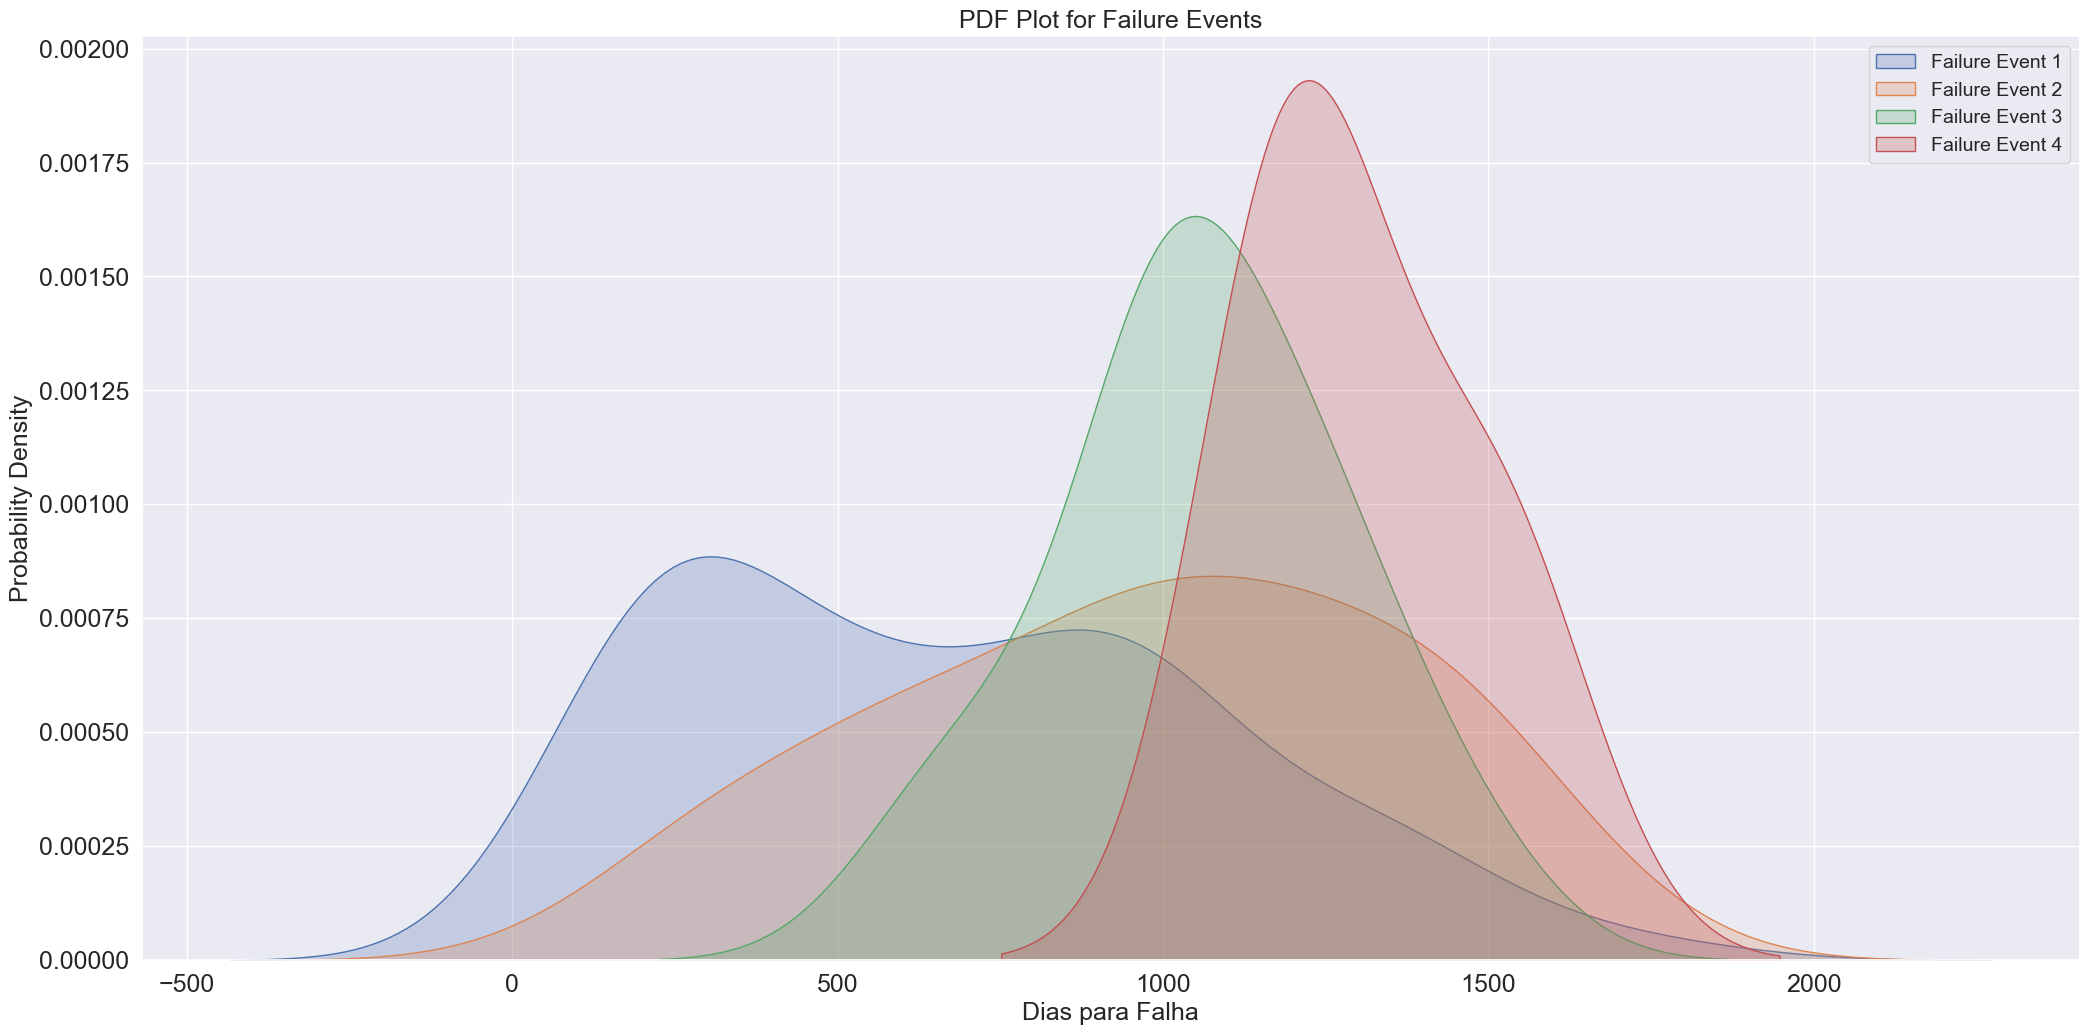

In [95]:
# Create a list to store all the data to be plotted
all_data_to_plot = []

# Determine the maximum list length
max_length = max(len(lst) for lst in arrival_days_lists)

# Create separate KDE plots for each item with up to max_length failures
for i in range(max_length):
    data_to_plot = [lst[i] for lst in arrival_days_lists if i < len(lst)]
    
    if data_to_plot:
        all_data_to_plot.append(data_to_plot)

# Create a single plot for all the data
plt.figure()
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
for i, data in enumerate(all_data_to_plot):
    sns.kdeplot(data, shade=True, cumulative=False, label=f'Failure Event {i+1}')

plt.title('PDF Plot for Failure Events', fontsize=18)
plt.xlabel('Dias para Falha', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.legend(fontsize=14)
plt.show()


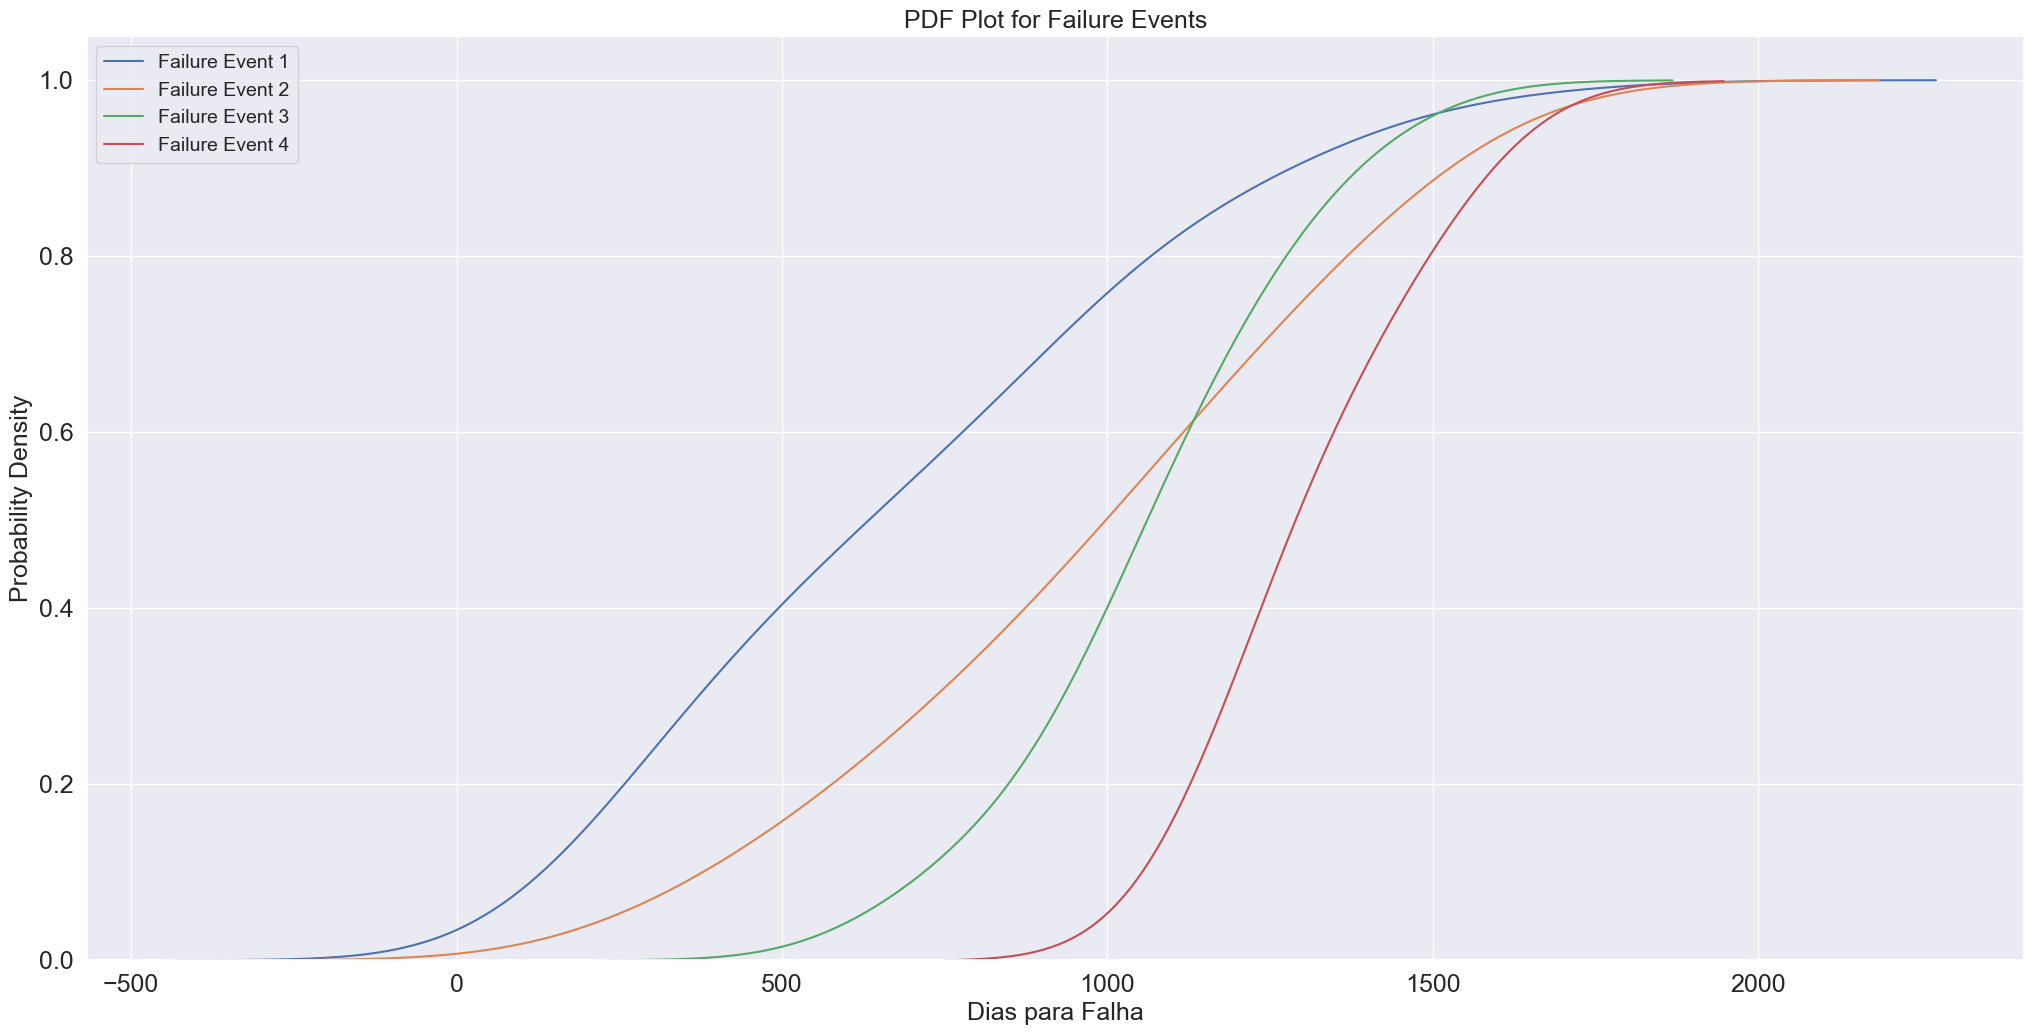

In [96]:
# Create a single plot for all the data
plt.figure()
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
for i, data in enumerate(all_data_to_plot):
    sns.kdeplot(data, shade=False, cumulative=True, label=f'Failure Event {i+1}')

plt.title('PDF Plot for Failure Events', fontsize=18)
plt.xlabel('Dias para Falha', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.legend(fontsize=14)
plt.show()

## Is there a specific day of the week that is more prone to failures?

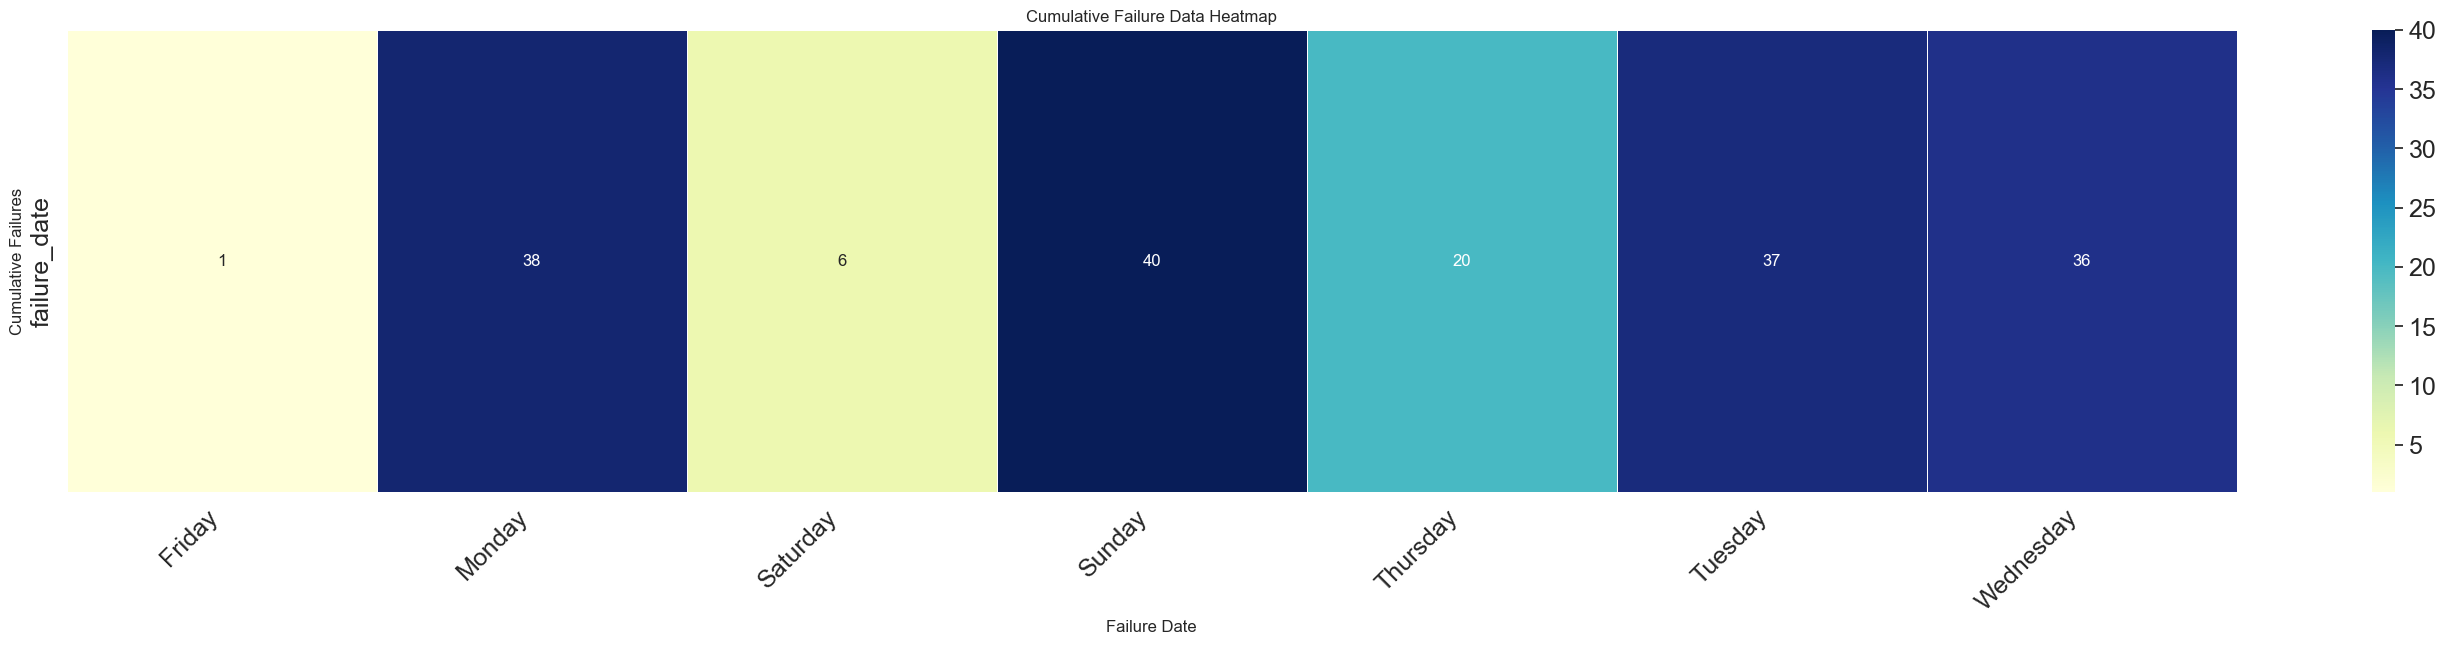

In [97]:
# I want to analyse if there's a trend of failures for any specific day of the week
aux = df_analysis[df_analysis['type_failure']=='F']
aux['day_of_week'] = aux['failure_date'].dt.day_name()

# Group by 'Failure Date' and calculate the cumulative sum
grouped_df = aux.groupby('day_of_week')['failure_date'].count()

# Create the heatmap
plt.figure(figsize=(35, 6))
sns.heatmap(grouped_df.to_frame().T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')

plt.xlabel('Failure Date')
plt.ylabel('Cumulative Failures')
plt.title('Cumulative Failure Data Heatmap')

# Format x-axis labels to show only the date
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df.index))

plt.show()

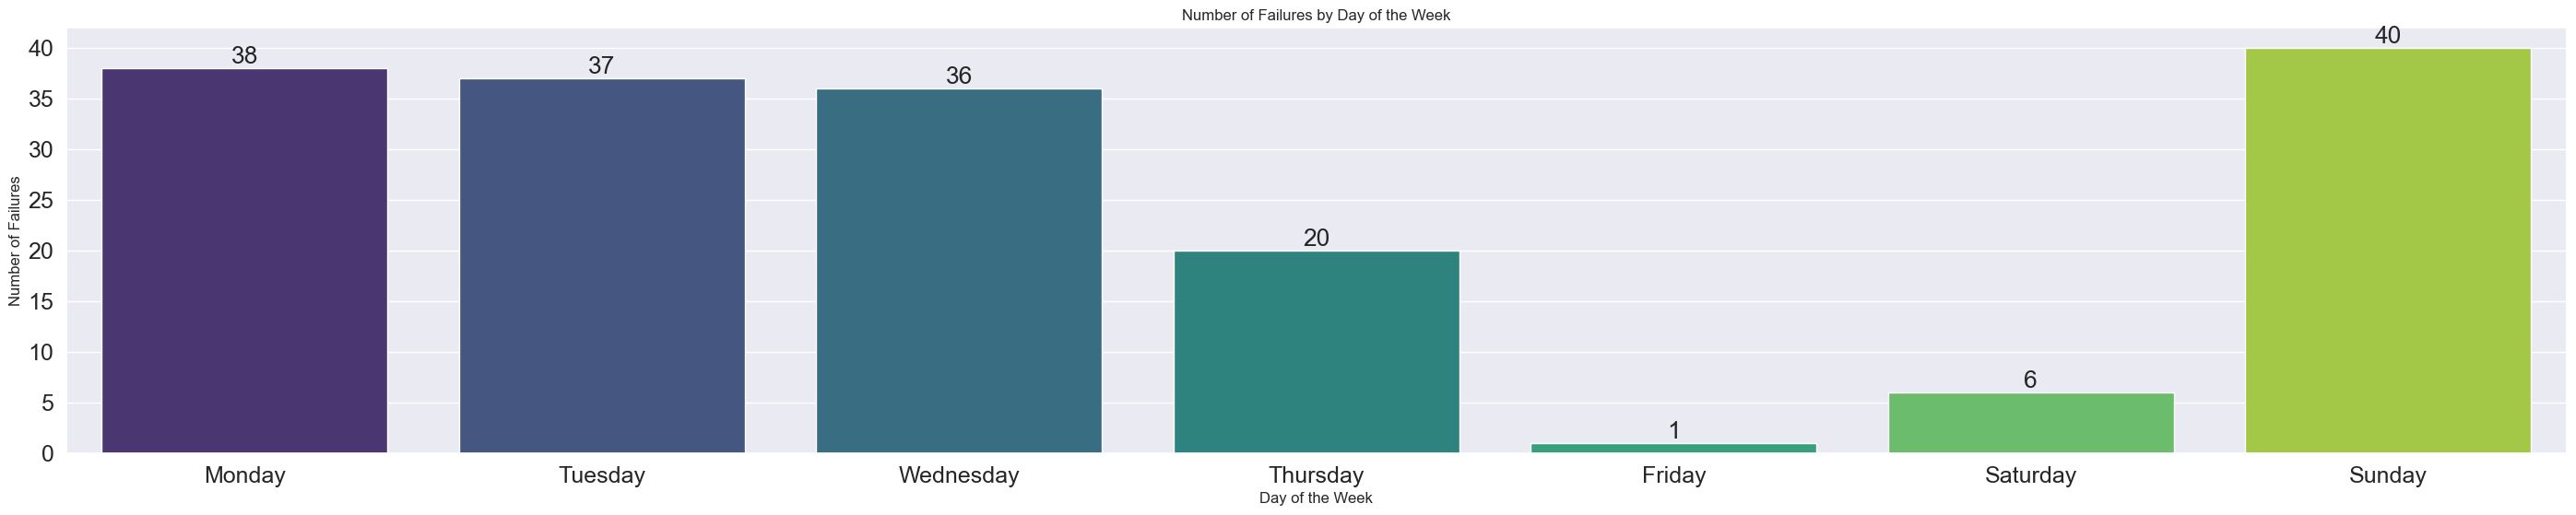

In [98]:
# I want to analyze if there's a high/low pearson correlation between the number of failures and the day of the week
aux = df_analysis[df_analysis['type_failure']=='F']
aux['day_of_week'] = aux['failure_date'].dt.dayofweek

# transform the day of the week into a categorical variable, and put into the right order
aux['day_of_week'] = aux['day_of_week'].replace({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
aux['day_of_week'] = pd.Categorical(aux['day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

# Group by 'Failure Date' and calculate the cumulative sum
grouped_df = aux.groupby('day_of_week')['failure_date'].count()

# Create the barplot
plt.figure(figsize=(35, 6))
ax = sns.barplot(x=grouped_df.index, y=grouped_df.values, palette='viridis')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Failures')
plt.title('Number of Failures by Day of the Week')
# put the labels in the values of the graph
for i in ax.containers:
    ax.bar_label(i,fontsize=19)

# create the heatmap
#sns.heatmap(grouped_df.to_frame().T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')
# plt.xlabel('Failure Date')
# plt.ylabel('Cumulative Failures')
# plt.title('Cumulative Failure Data Heatmap')
# Format x-axis labels to show only the date
# plt.xticks(rotation=45, ha='right')
# plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df.index))

plt.show()


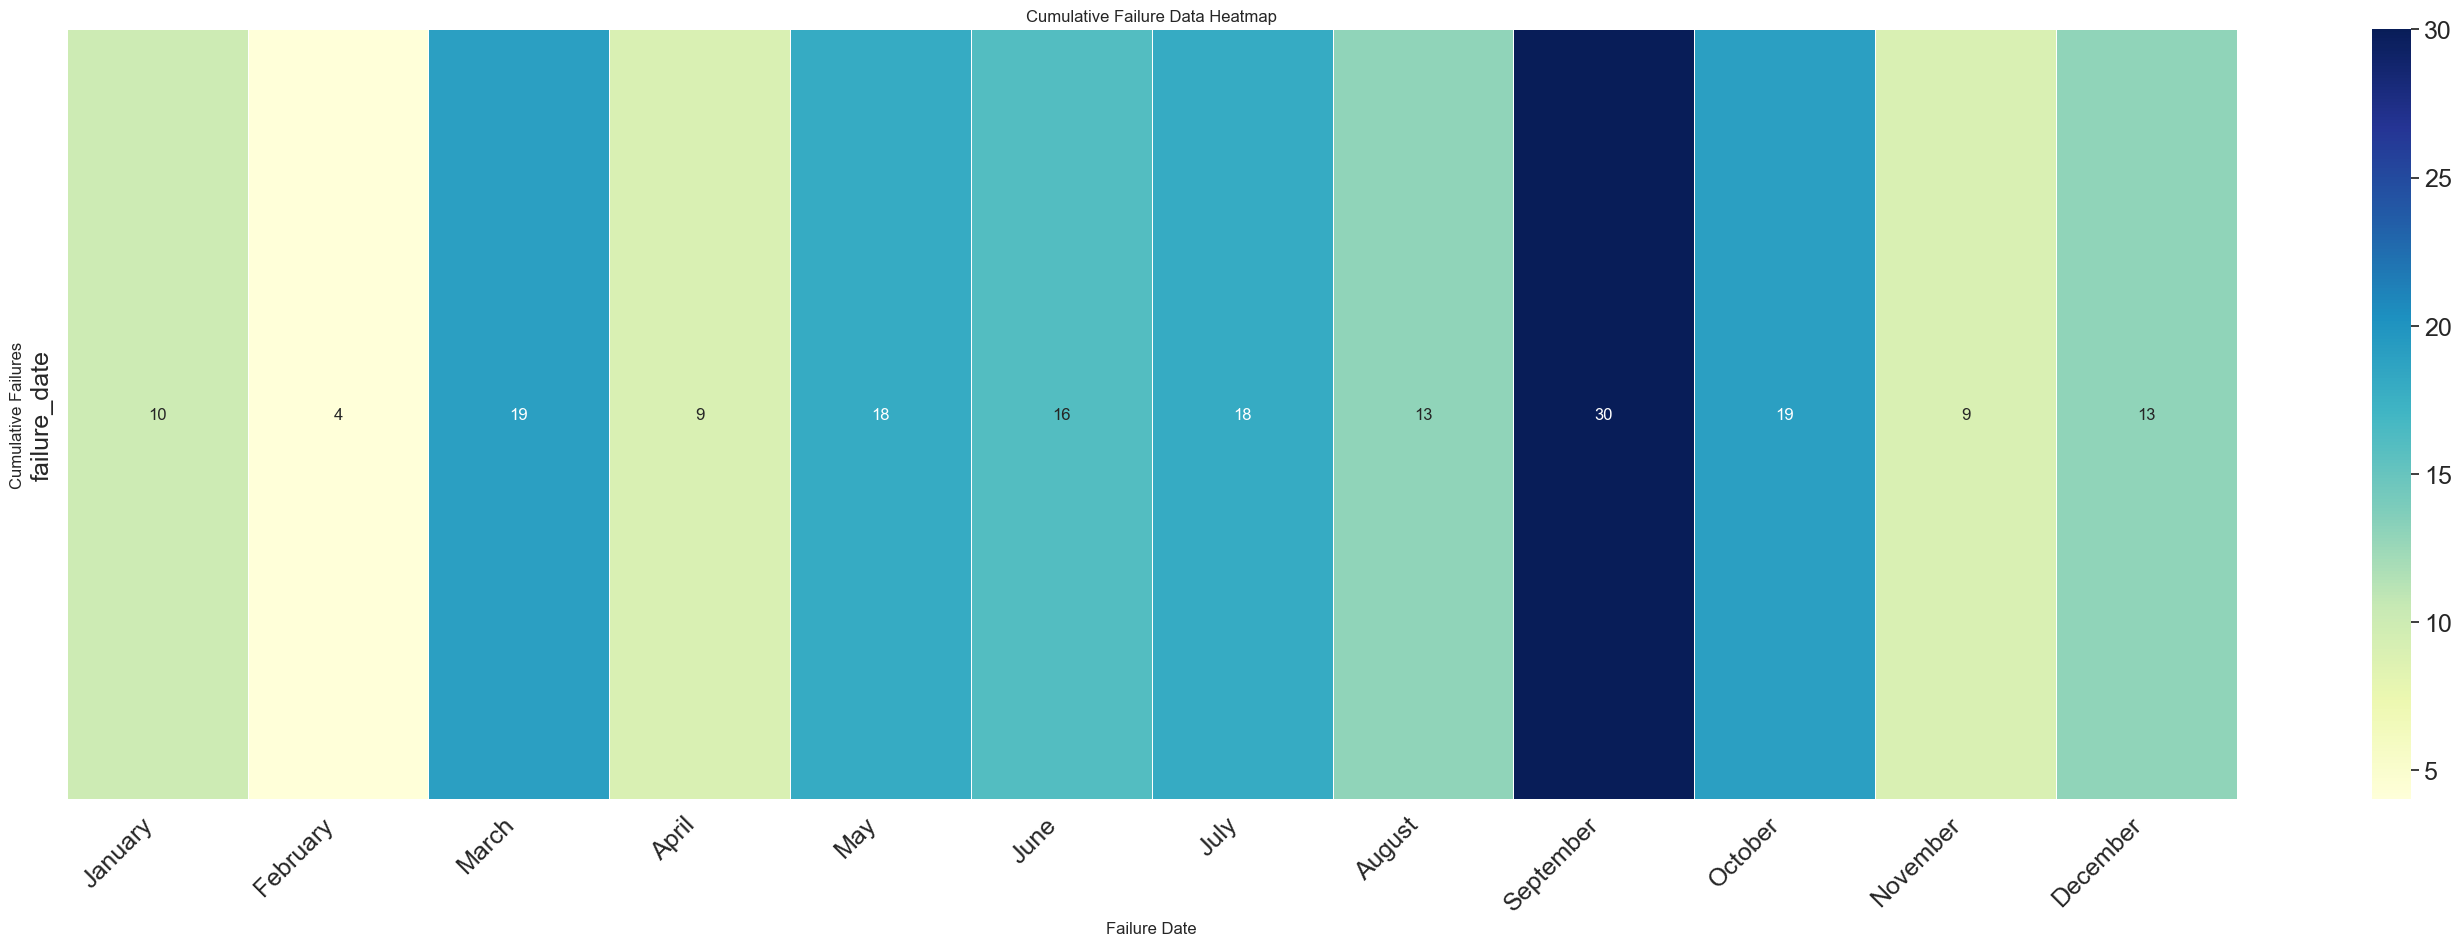

In [99]:
# I want to analyze if there's a trend of failures for any specific month
aux = df_analysis[df_analysis['type_failure']=='F']
aux['month'] = aux['failure_date'].dt.month_name()

month_order = {name: num for num, name in enumerate(calendar.month_name) if num}


# Group by 'Failure Date' and calculate the cumulative sum
grouped_df = aux.groupby('month')['failure_date'].count()
grouped_df = grouped_df.sort_index(key=lambda x: x.map(month_order))

# Create the heatmap
plt.figure(figsize=(35, 10))
#plt.subplot(2,1,1)

sns.heatmap(grouped_df.to_frame().T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')

plt.xlabel('Failure Date')
plt.ylabel('Cumulative Failures')
plt.title('Cumulative Failure Data Heatmap')

# Format x-axis labels to show only the date
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df.index))

# create a barplot with same values
# plt.subplot(2,1,2)
# grouped_df.plot(kind='bar')
# plt.title('Number of Failures by Month')
# plt.xlabel('Date')
# plt.ylabel('Number of Failures')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()

plt.show()

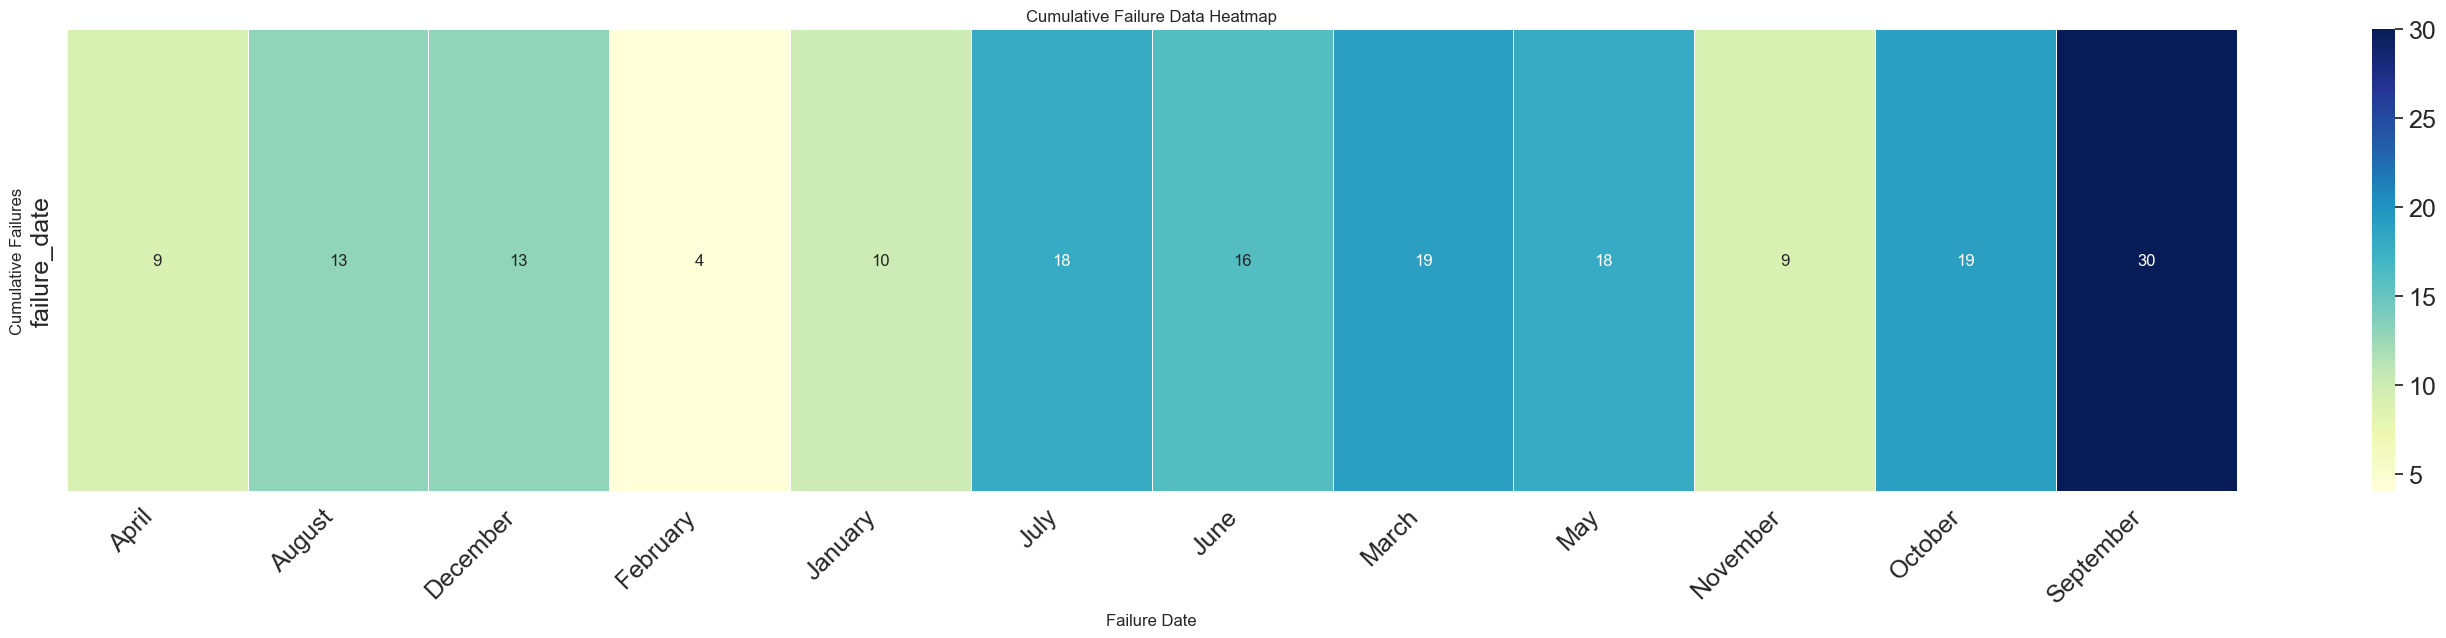

In [100]:
# I want to analyze if there's a trend of failures for any specific month
aux = df_analysis[df_analysis['type_failure']=='F']
aux['month'] = aux['failure_date'].dt.month_name()

# Group by 'Failure Date' and calculate the cumulative sum
grouped_df = aux.groupby('month')['failure_date'].count()

# Create the heatmap
plt.figure(figsize=(35, 6))
sns.heatmap(grouped_df.to_frame().T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')

plt.xlabel('Failure Date')
plt.ylabel('Cumulative Failures')
plt.title('Cumulative Failure Data Heatmap')

# Format x-axis labels to show only the date
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df.index))

plt.show()



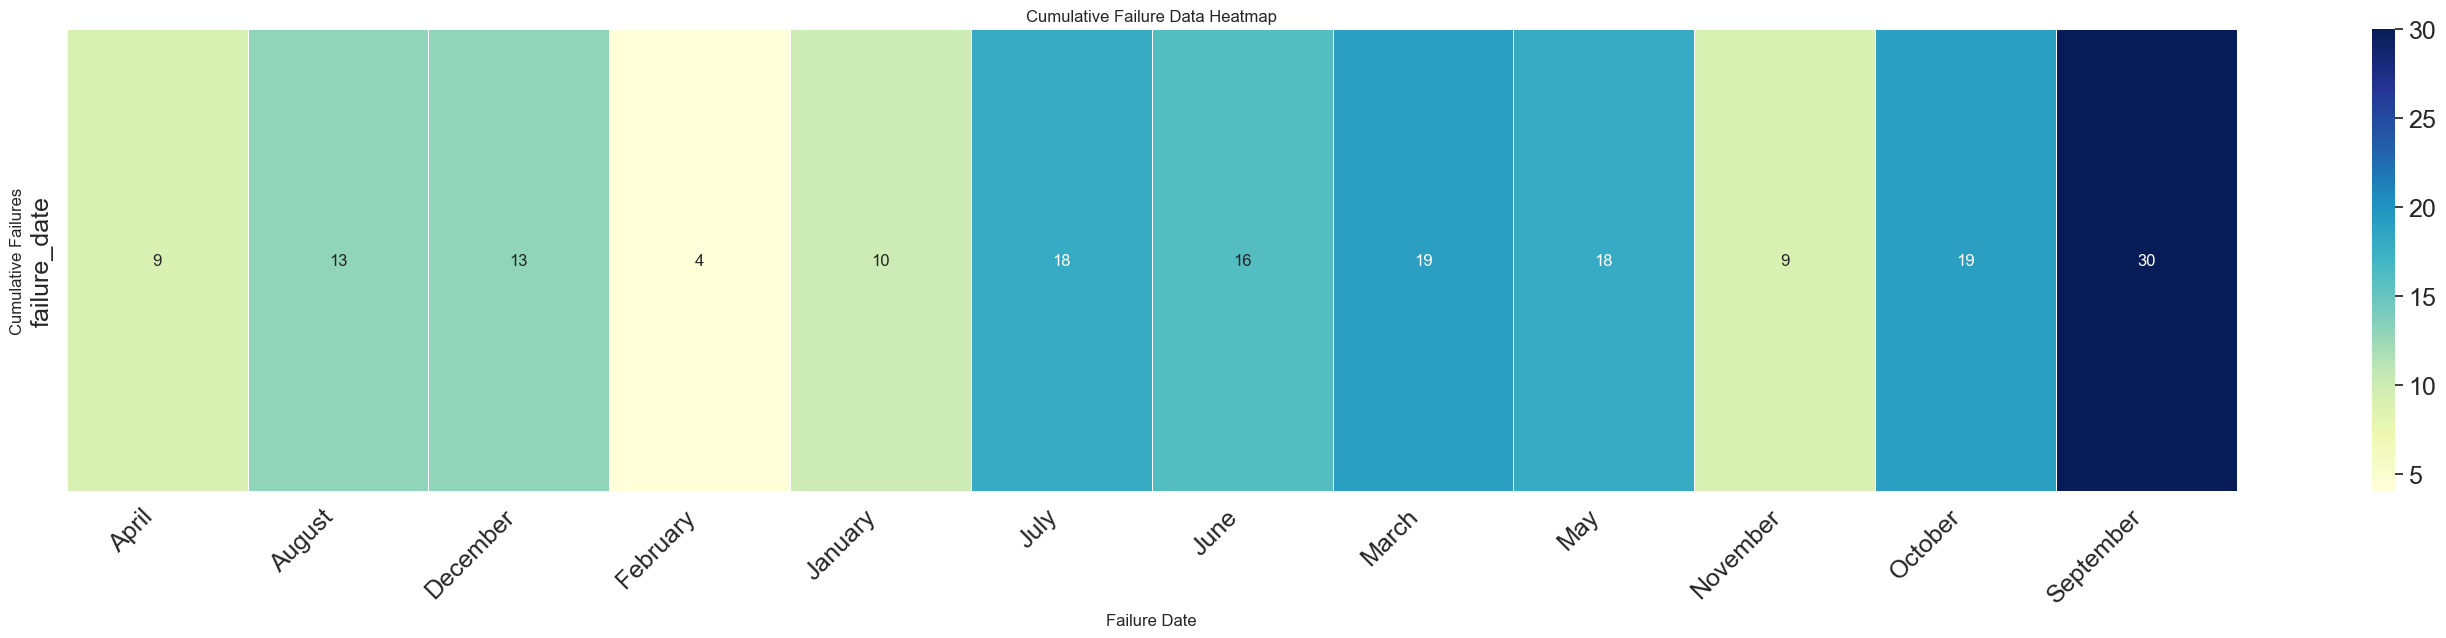

In [101]:
# I want to analyze if there's a trend of failures for any specific month
aux = df_analysis[df_analysis['type_failure']=='F']
aux['month'] = aux['failure_date'].dt.month_name()

# Group by 'Failure Date' and calculate the cumulative sum
grouped_df = aux.groupby('month')['failure_date'].count()

# Create the heatmap
plt.figure(figsize=(35, 6))
sns.heatmap(grouped_df.to_frame().T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')

plt.xlabel('Failure Date')
plt.ylabel('Cumulative Failures')
plt.title('Cumulative Failure Data Heatmap')

# Format x-axis labels to show only the date
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df.index))

plt.show()



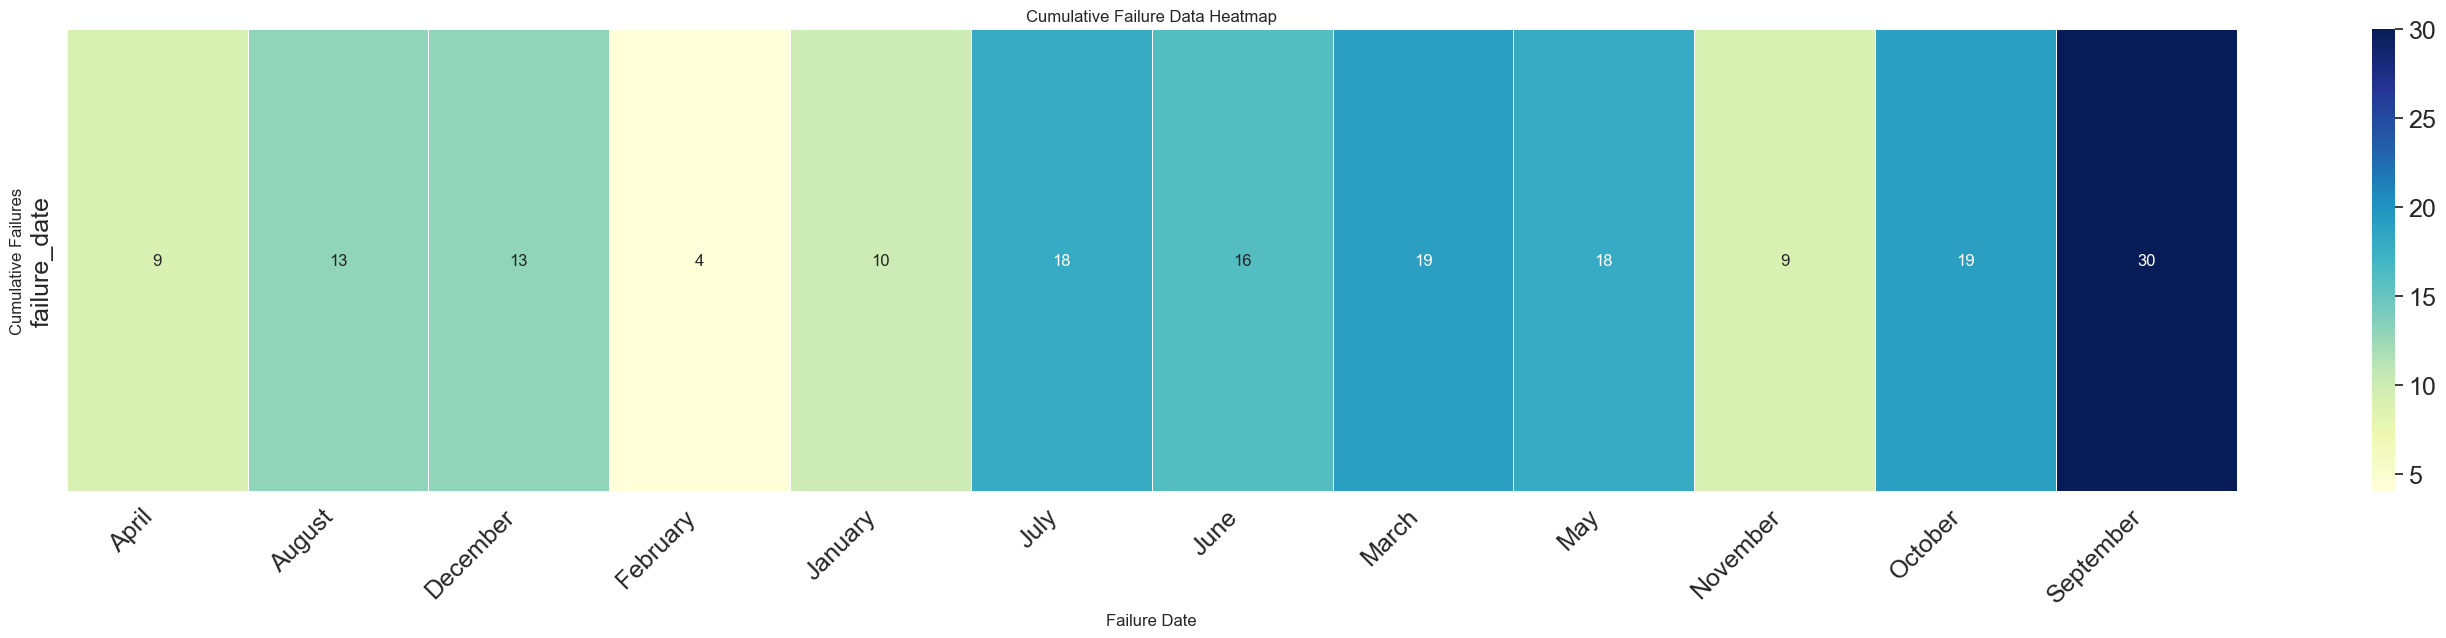

In [102]:
# I want to analyze if there's a trend of failures for any specific month
aux = df_analysis[df_analysis['type_failure']=='F']
aux['month'] = aux['failure_date'].dt.month_name()

# Group by 'Failure Date' and calculate the cumulative sum
grouped_df = aux.groupby('month')['failure_date'].count()

# Create the heatmap
plt.figure(figsize=(35, 6))
sns.heatmap(grouped_df.to_frame().T, cmap='YlGnBu', annot=True, cbar=True, linewidths=0.5, linecolor='white')

plt.xlabel('Failure Date')
plt.ylabel('Cumulative Failures')
plt.title('Cumulative Failure Data Heatmap')

# Format x-axis labels to show only the date
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(grouped_df.index))

plt.show()



Duane reliability growth model parameters:
Alpha: 0.26345
A: 0.00376
Demonstrated MTBF (cumulative): 12868.19077
Demonstrated MTBF (instantaneous): 17470.8697
Demonstrated failure intensity (cumulative): 7.77110e-05
Demonstrated failure intensity (instantaneous): 5.72381e-05

Crow-AMSAA reliability growth model parameters:
Beta: 0.95803
Lambda: 0.00646
Growth rate: 0.04197
Demonstrated MTBF (cumulative): 242.29213
Demonstrated MTBF (instantaneous): 252.90616
Demonstrated failure intensity (cumulative): 0.00413
Demonstrated failure intensity (instantaneous): 0.00395



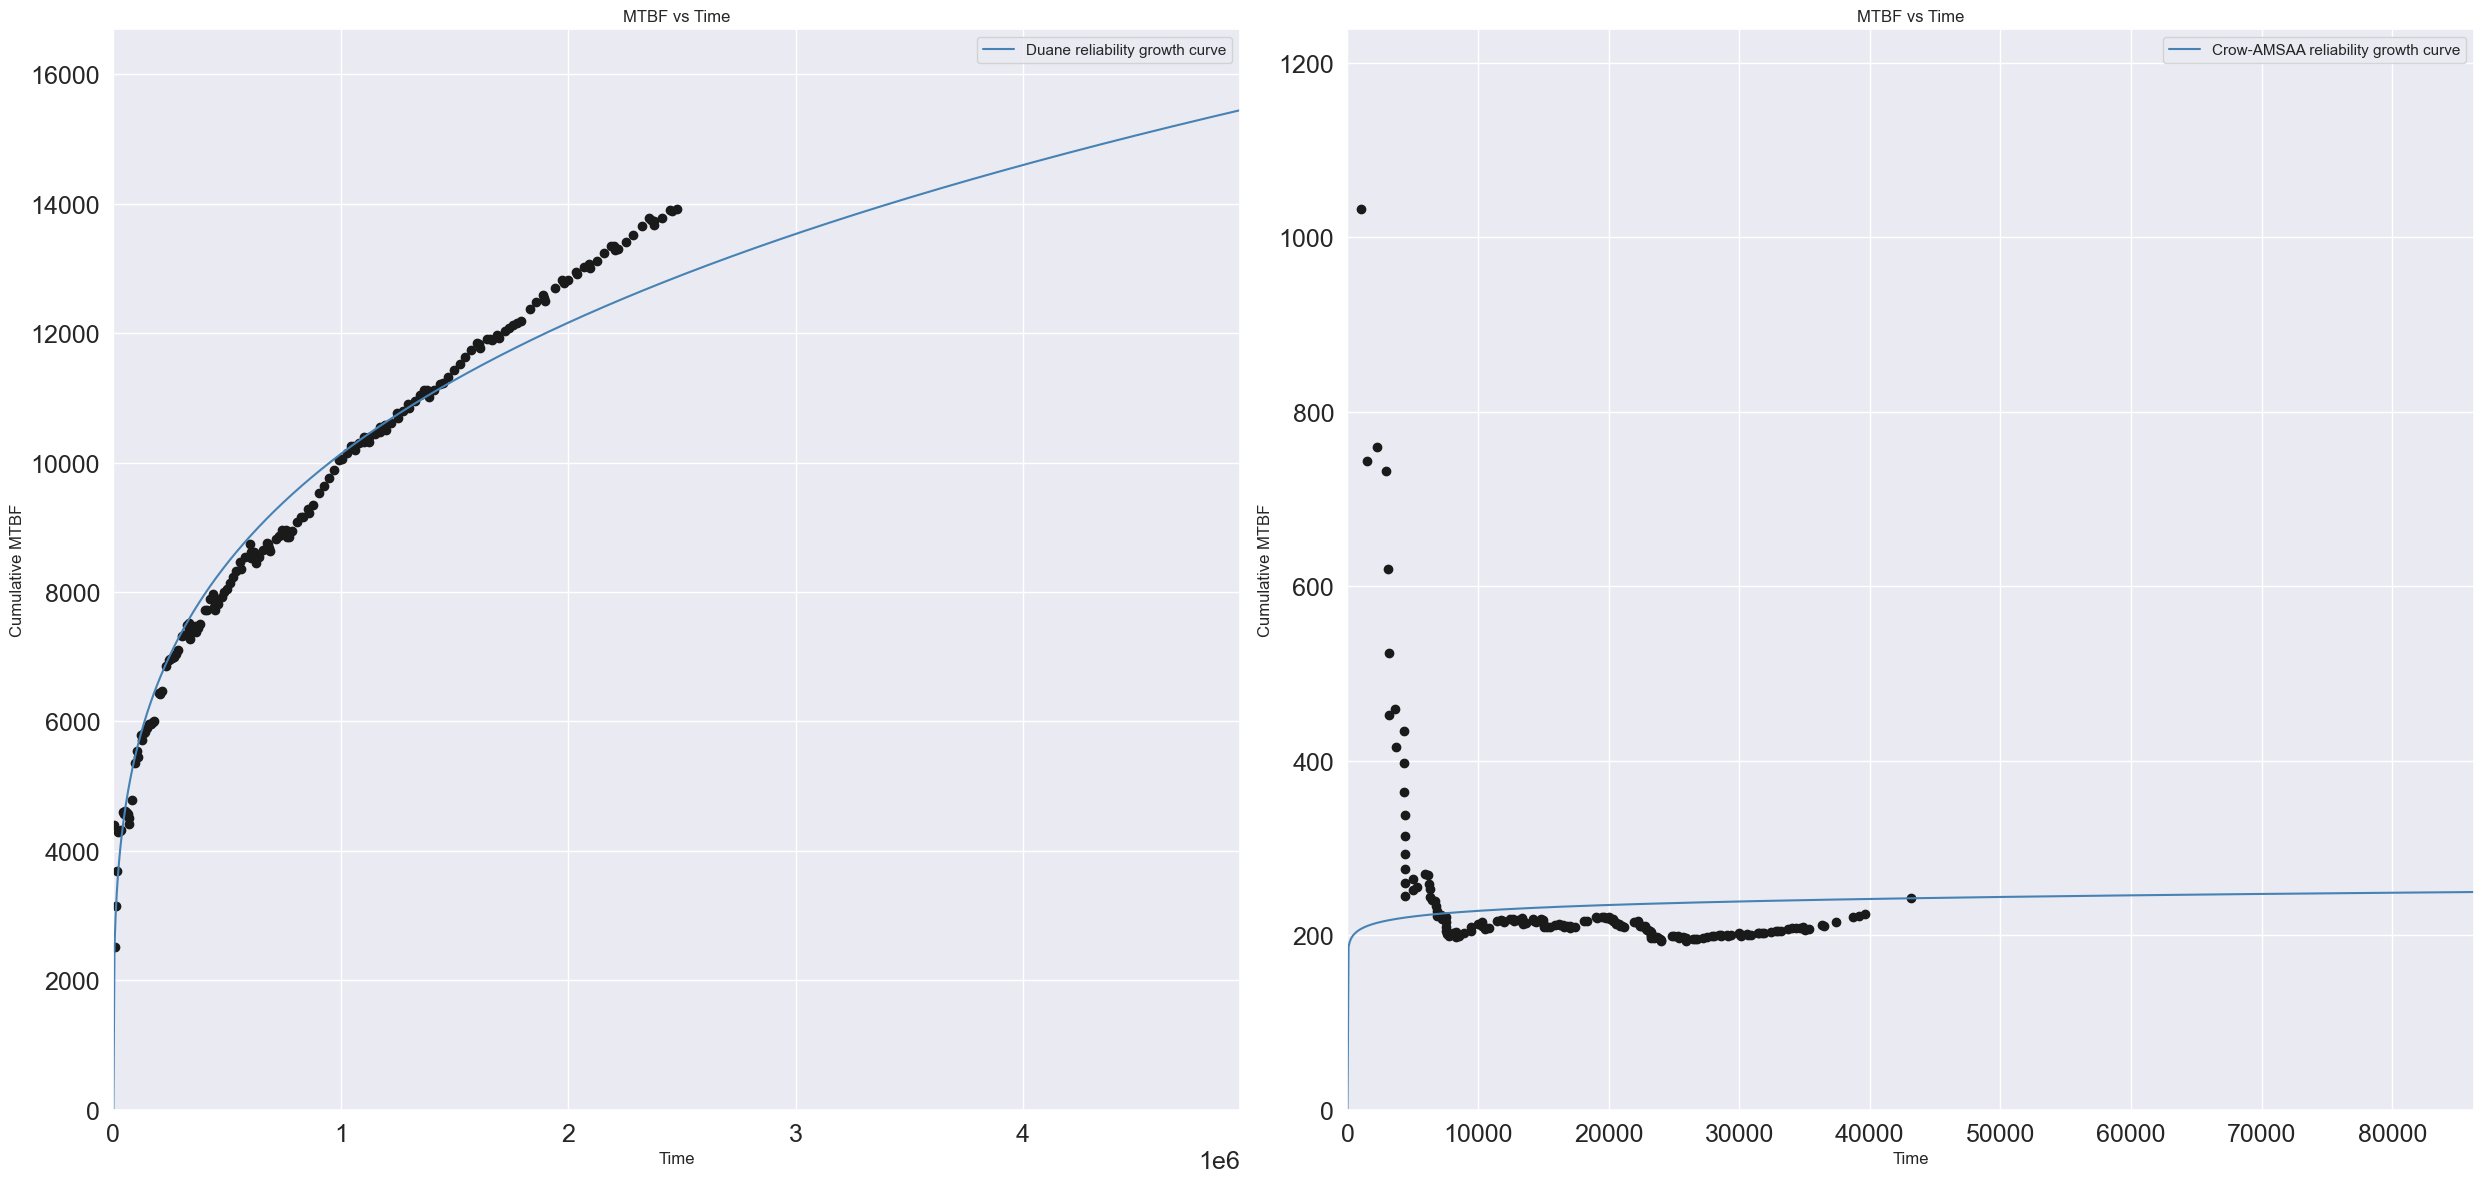

In [103]:
from reliability.Repairable_systems import reliability_growth
from reliability.Datasets import system_growth
import matplotlib.pyplot as plt

aux = df_analysis[df_analysis['type_failure']=='F'].sort_values('failure_date').hourstf.cumsum().to_list()

plt.subplot(1,2,1)
reliability_growth(times=aux, model="Duane")

aux = df_analysis[df_analysis['type_failure']=='F'].sort_values('failure_date').arrival_hours.to_list()

plt.subplot(1,2,2)
reliability_growth(times=aux, model="Crow-AMSAA")

In [104]:
# create a dataframe that will be used to calculate the crow-amsaa model, for MTBF analysis
df_crow_amsaa = df_rga[['hourstf','classification','failure_mode','full_config','arrival_hours']][df_rga['type_failure']=='F'].sort_values(['full_config','hourstf']).hourstf
df_crow_amsaa.to_excel('Data/df_crow_amsaa.xlsx', index=False)

## Are there any significant differences between manufacture dates?

The logic is to group the time to failures for each serial number, according to each year of fabrication date

In [ ]:
# merge the dataframes to get the 'manufacture dates' for each 'serial number'
df_manufacture = pd.merge(df_analysis[['full_config','failure_mode','serial_number','failure_date','hourstf']][df_analysis['type_failure']=='F'],df_pyear,on='serial_number',how='left').sort_values('hourstf')

# create separate dataframes, one for each year of manufacture.
df_manufacture['production_year'] = df_manufacture['production_month'].dt.year.astype('Int64')

In [239]:
# creating one dataframe for each year of manufacture
df_manufacture_2015 = df_manufacture[df_manufacture['production_year']==2015]
df_manufacture_2017 = df_manufacture[df_manufacture['production_year']==2017]
df_manufacture_2018_2021 = df_manufacture[df_manufacture['production_year']>2018]


# export to excel file all dataframes, in the same file, but one dataframe in each sheet
with pd.ExcelWriter('Data/df_production_dates.xlsx') as writer:  
    df_manufacture.to_excel(writer, sheet_name='df_manufacture', index=False)
    df_manufacture_2015.to_excel(writer, sheet_name='df_manufacture_2015', index=False)
    df_manufacture_2017.to_excel(writer, sheet_name='df_manufacture_2017', index=False)
    df_manufacture_2018_2021.to_excel(writer, sheet_name='df_manufacture_2018_2021', index=False)

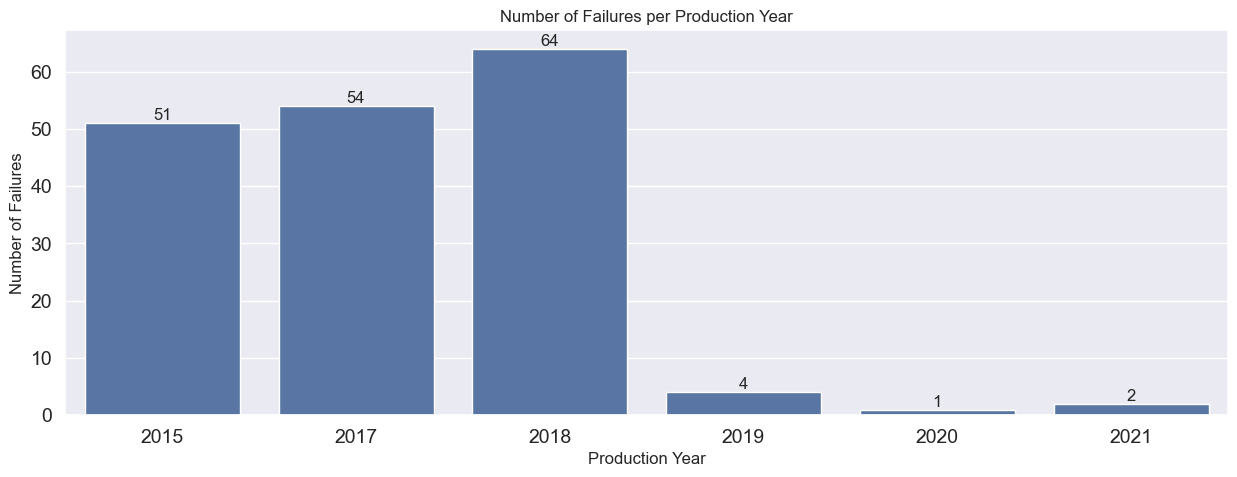

In [240]:
# create a countplot for the amount of data for year 'production_year'
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df_manufacture,x='production_year')
plt.title('Number of Failures per Production Year')
plt.xlabel('Production Year')
plt.ylabel('Number of Failures')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12)
plt.show()


The data that was exported to excel was used in Weibull++ for further countour plot analysis, to compare the behavior between the considered periods.

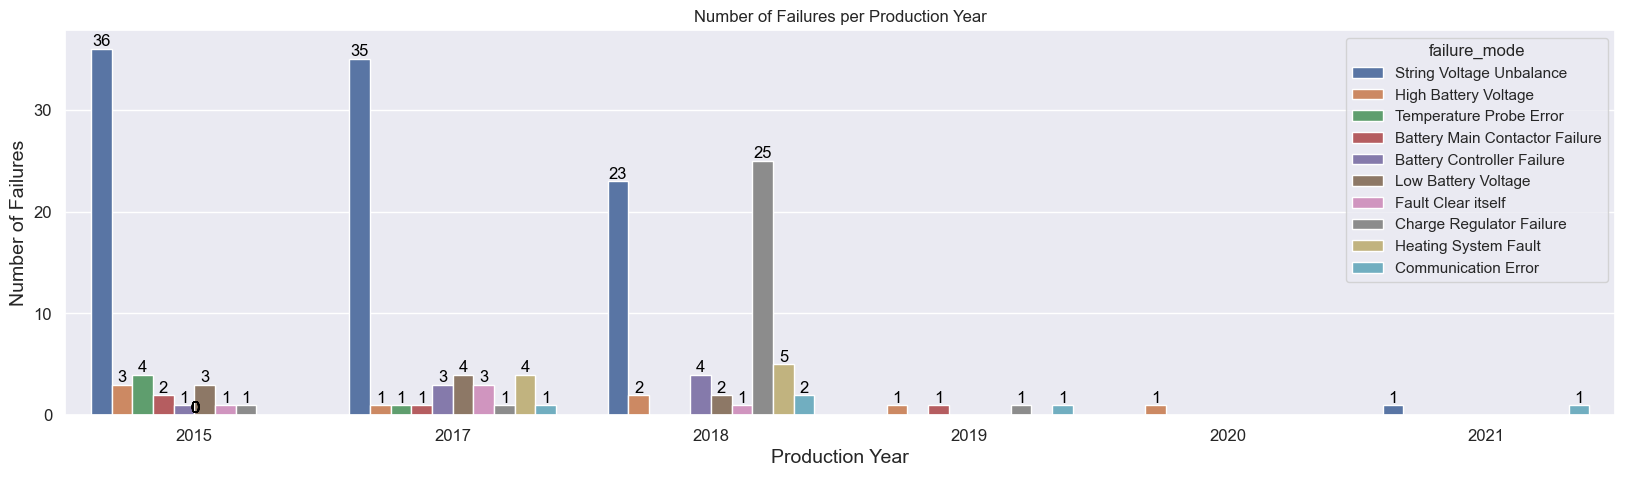

In [241]:
# To check the failure modes by number of failures per production year
plt.figure(figsize=(20,5))
ax = sns.countplot(data=df_manufacture,x='production_year',hue='failure_mode')
plt.title('Number of Failures per Production Year')
plt.xlabel('Production Year',fontsize=14)
plt.ylabel('Number of Failures',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=12,
                color='black',
                xytext=(0, 5),
                textcoords='offset points')
    
plt.show()

## How's the distribution of cumulative batteries in operation over time?

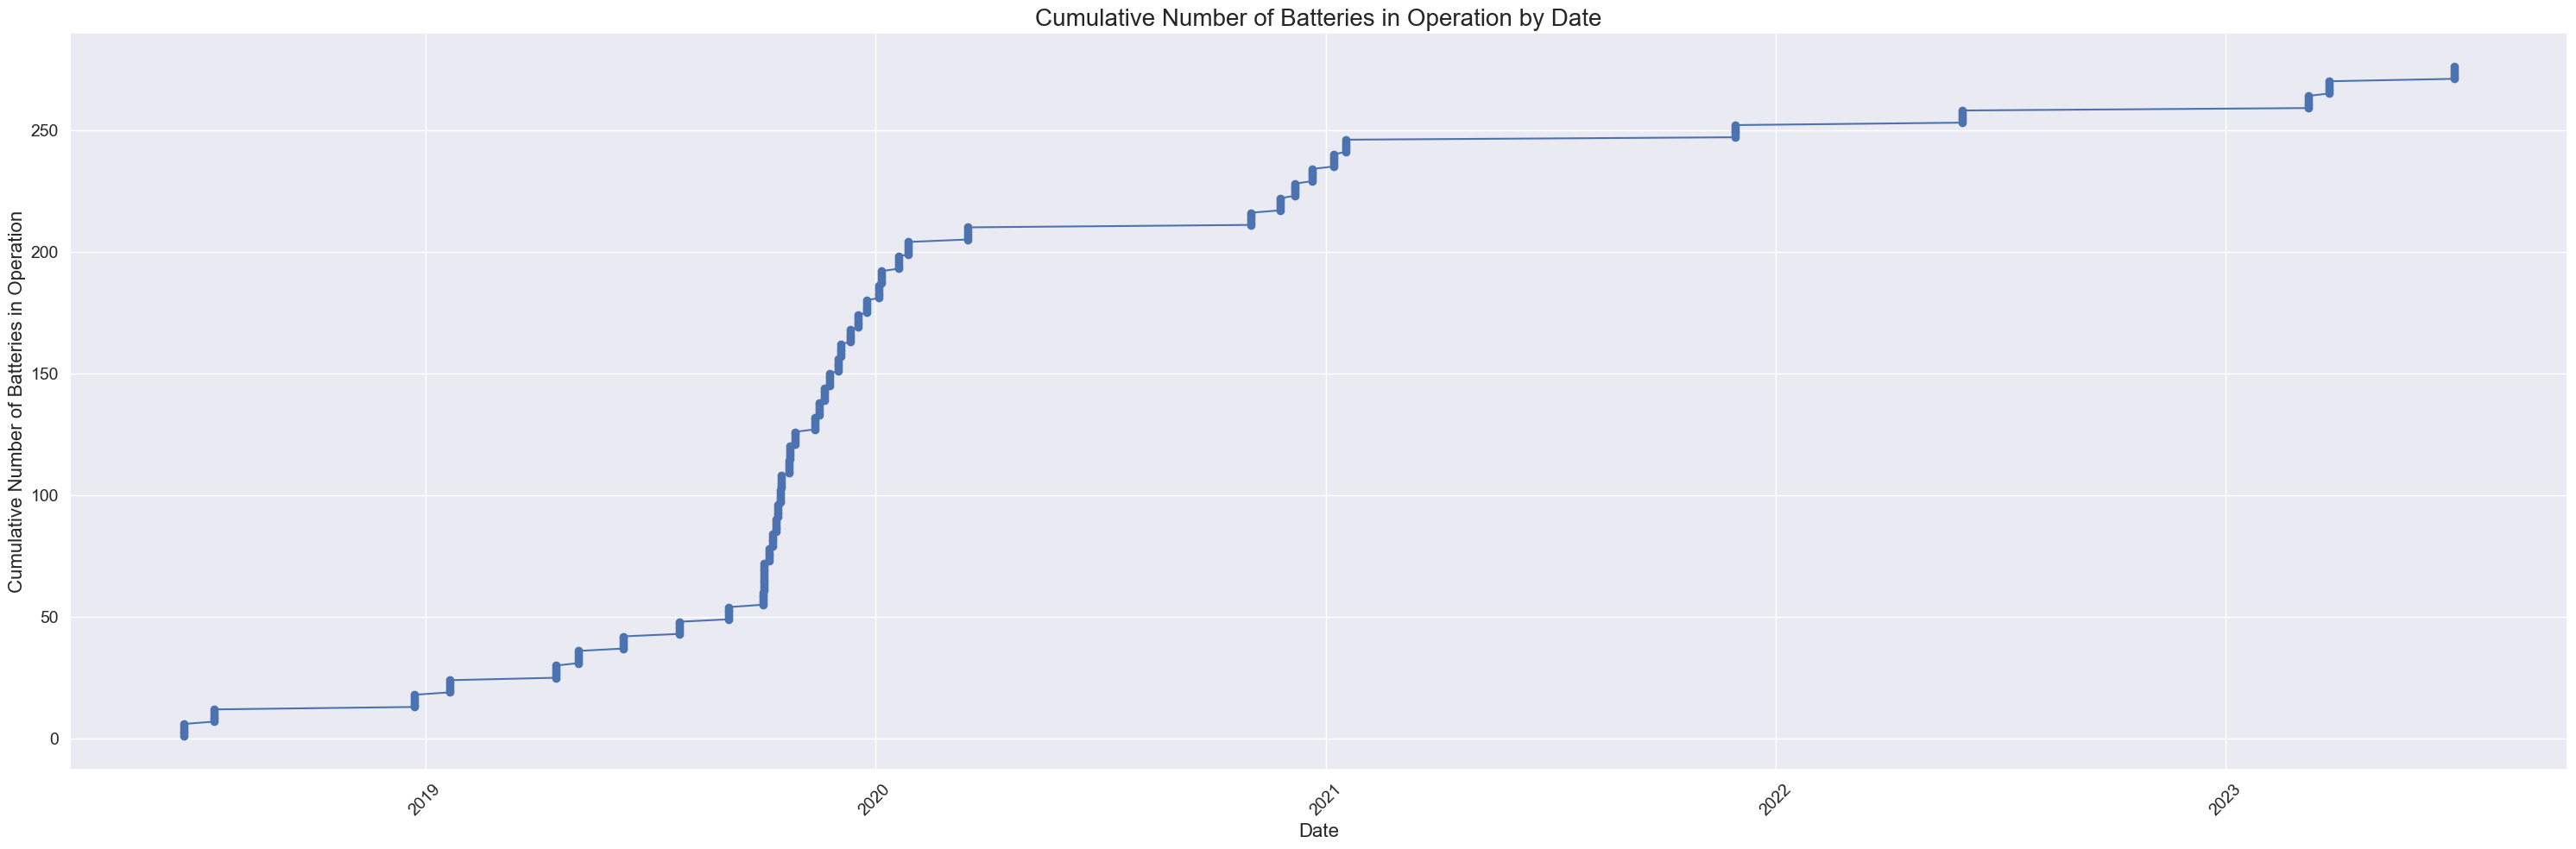

In [215]:
## How's the cumulative amount of trains in operation by date? Use df_tpower to get the 'power_on_date' for each 'train', and use countsum to get the cumulative amount of trains in operation by date
aux = df_tpower.sort_values('power_on_date').copy()
aux['cum_batteries_operating'] = aux.reset_index().index+1

# Create the line plot
plt.figure(figsize=(30, 10))
plt.plot(aux['power_on_date'], aux['cum_batteries_operating'], marker='o')
plt.title('Cumulative Number of Batteries in Operation by Date', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative Number of Batteries in Operation', fontsize=16)
plt.grid(True)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Display the graph
plt.show()


### Total hours for operating batteries for 90 days moving window

This information will be used to calculate the instantaneous MTBF in Weibull++

In [232]:
# considering the last date as '2024-07-11' and the first date as '2018-06-19', I want to obtain a list with equally distributed dates, considering a 90days moving window.
# I'll use this list to create a dataframe that will contain the amount of batteries in operation for each date in the list
# I'll use this dataframe to calculate the crow-amsaa model, and to create a plot with the cumulative amount of batteries in operation by date

# create a list with equally distributed dates, considering a 90days moving window
date_list = pd.date_range(start='2018-06-19',end='2025-02-02',freq='90D',inclusive='both').tolist()

# Check if the end date is included, if not add it
end_date = pd.Timestamp('2025-02-02')
if end_date not in date_list:
    date_list.append(end_date)

In [233]:
date_list

[Timestamp('2018-06-19 00:00:00'),
 Timestamp('2018-09-17 00:00:00'),
 Timestamp('2018-12-16 00:00:00'),
 Timestamp('2019-03-16 00:00:00'),
 Timestamp('2019-06-14 00:00:00'),
 Timestamp('2019-09-12 00:00:00'),
 Timestamp('2019-12-11 00:00:00'),
 Timestamp('2020-03-10 00:00:00'),
 Timestamp('2020-06-08 00:00:00'),
 Timestamp('2020-09-06 00:00:00'),
 Timestamp('2020-12-05 00:00:00'),
 Timestamp('2021-03-05 00:00:00'),
 Timestamp('2021-06-03 00:00:00'),
 Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2022-02-28 00:00:00'),
 Timestamp('2022-05-29 00:00:00'),
 Timestamp('2022-08-27 00:00:00'),
 Timestamp('2022-11-25 00:00:00'),
 Timestamp('2023-02-23 00:00:00'),
 Timestamp('2023-05-24 00:00:00'),
 Timestamp('2023-08-22 00:00:00'),
 Timestamp('2023-11-20 00:00:00'),
 Timestamp('2024-02-18 00:00:00'),
 Timestamp('2024-05-18 00:00:00'),
 Timestamp('2024-08-16 00:00:00'),
 Timestamp('2024-11-14 00:00:00'),
 Timestamp('2025-02-02 00:00:00')]

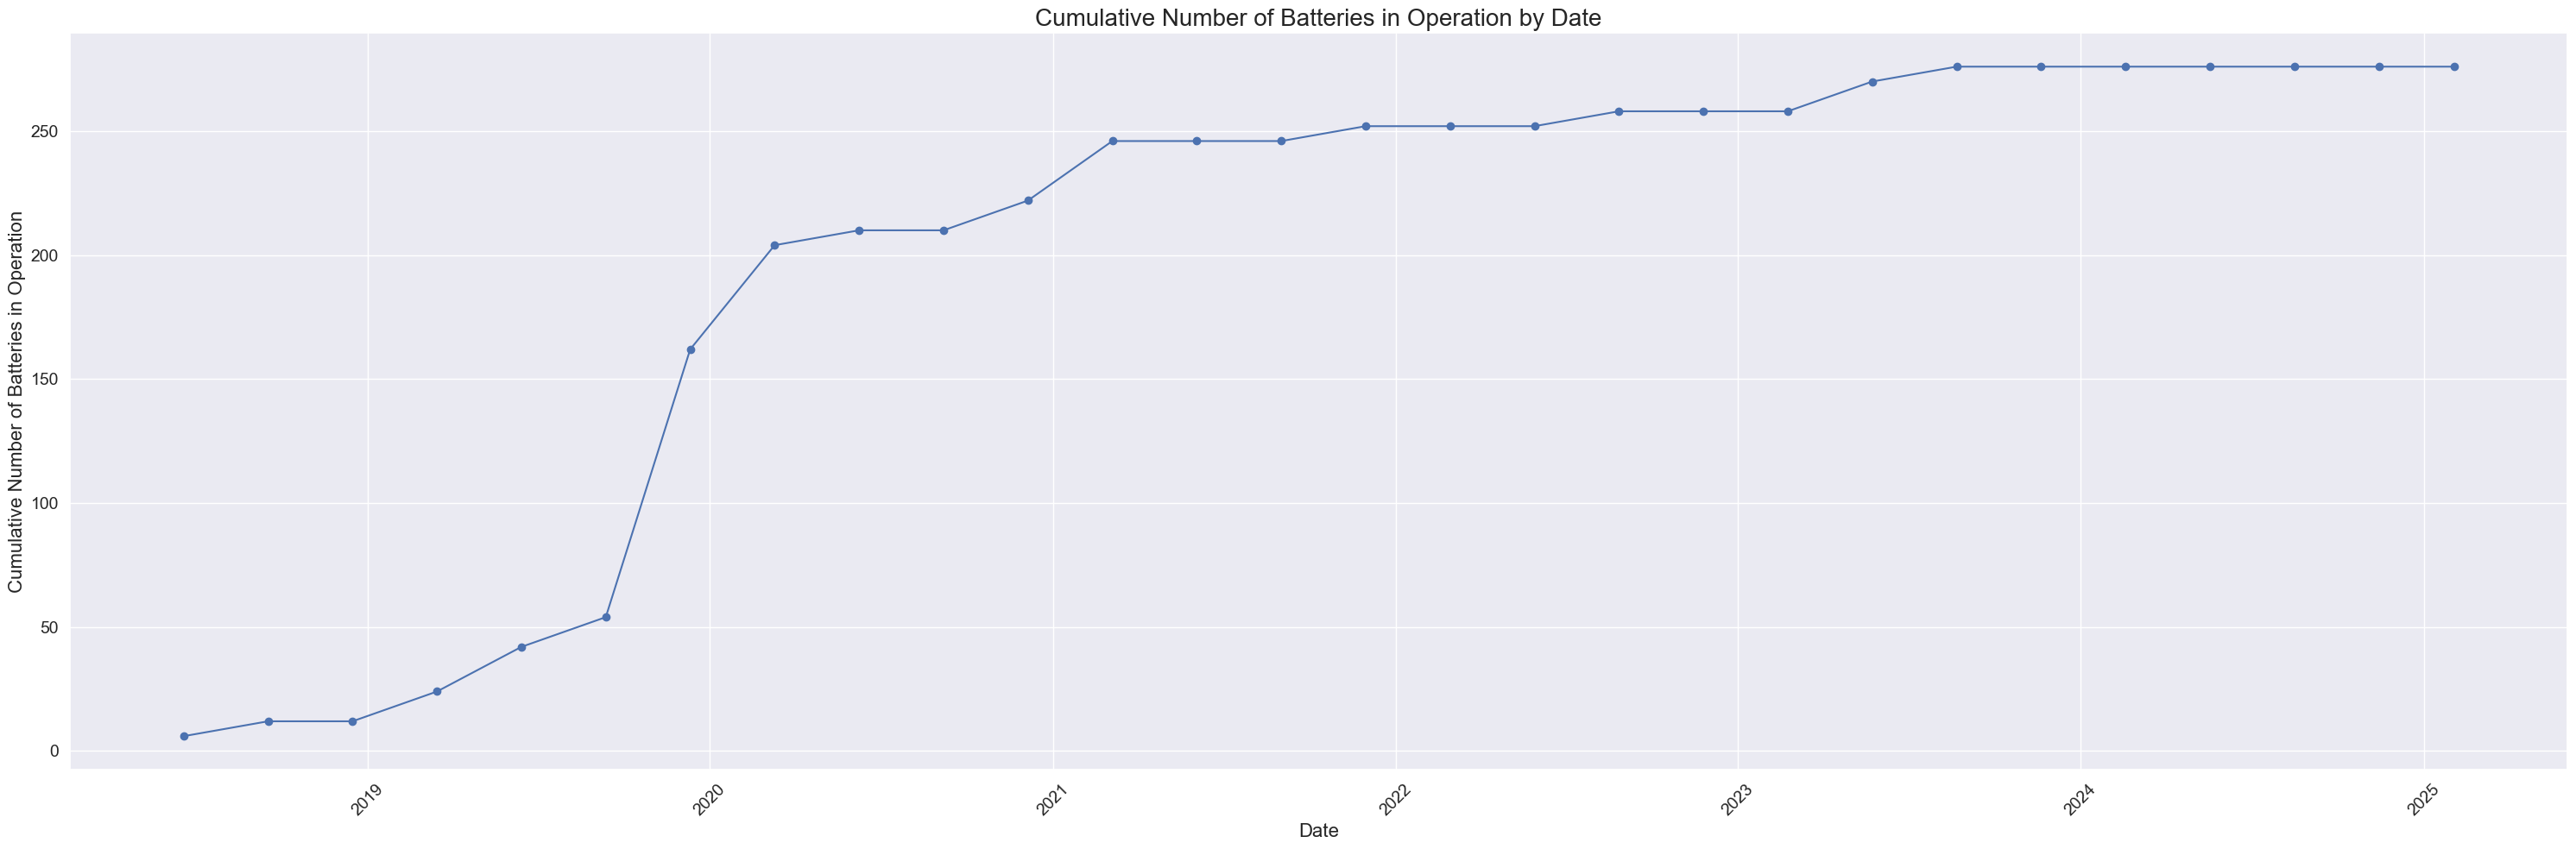

In [234]:
# now, I want to obtain the amount of batteries in operation for each date in the list
# I'll use the 'power_on_date' from df_tpower to do this
# I'll create a dataframe that will contain the amount of batteries in operation for each date in the list
# I'll use this dataframe to calculate the crow-amsaa model, and to create a plot with the cumulative amount of batteries in operation by date

# create a dataframe that will contain the amount of batteries in operation for each date in the list
df_batteries_in_operation = pd.DataFrame(columns=['date','cum_batteries_operating'])

# iterate through each date in the list

for date in date_list:
    # get the amount of batteries in operation for each date in the list
    cum_batteries_operating = aux[aux['power_on_date']<=date]['cum_batteries_operating'].max()
    
    # create a new row for df_batteries_in_operation
    df_batteries_in_operation = pd.concat([df_batteries_in_operation, pd.DataFrame({
        'date': [date],
        'cum_batteries_operating': [cum_batteries_operating]
    })], ignore_index=True)

# Create the line plot
plt.figure(figsize=(30, 10))
plt.plot(df_batteries_in_operation['date'], df_batteries_in_operation['cum_batteries_operating'], marker='o')
plt.title('Cumulative Number of Batteries in Operation by Date', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative Number of Batteries in Operation', fontsize=16)
plt.grid(True)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Display the graph
plt.show()

In [235]:
# create a column that will contain the amount of hours related to the amount of batteries in operation for each date in the list
df_batteries_in_operation['hours_in_operation'] = (df_batteries_in_operation['cum_batteries_operating'] * 24 * 90).cumsum()
df_batteries_in_operation

,date,cum_batteries_operating,hours_in_operation
0,2018-06-19,6,12960
1,2018-09-17,12,38880
2,2018-12-16,12,64800
3,2019-03-16,24,116640
4,2019-06-14,42,207360
5,2019-09-12,54,324000
6,2019-12-11,162,673920
7,2020-03-10,204,1114560
8,2020-06-08,210,1568160
9,2020-09-06,210,2021760


In [311]:
# Calculate total hours difference directly in one line
total_hours = (datetime.datetime(2024,9,25) - datetime.datetime(2018,6,19)).total_seconds() / 3600
total_hours

54960.0

## Do we have differences by using 'full_config' instead of 'serial_numbers'?

The example below shows a problem with the data that I used for the analysis, but this was the only one I found so far

In [112]:
df_analysis[df_analysis['serial_number']=='1207524']

,train,battery_config,full_config,failure_mode,serial_number,start_date,failure_date,type_failure,counter_fullconfig,ttf,hourstf,arrival_days,arrival_hours
73,TS01,BA12,TS01BA12,String Voltage Unbalance,1207524,2021-05-09,2021-08-11,F,3,94,2256,637,15288
157,TS02,BA22,TS02BA22,String Voltage Unbalance,1207524,2022-08-09,2023-06-03,F,2,298,7152,1286,30864
8,TS02,BA22,TS02BA22,NaN,1207524,2023-06-03,2023-10-23,S,NaN,142,3408,1428,34272
16,TS07,BA13,TS07BA13,NaN,1207524,2021-10-24,2023-10-23,S,NaN,729,17496,1086,26064
21,TS12,BA13,TS12BA13,Temperature Probe Error,1207524,2020-01-26,2020-07-07,F,2,163,3912,347,8328
